In [ ]:
# Import
import os
import sys
sys.path.insert(0, os.path.abspath('bqp_data_science'))
from data_generation import make_parity_application
from data_generation import write_csv, random_functions

import pandas as pd
import random

from collections import Counter, defaultdict
from itertools import combinations 

import numpy as np
import operator
import math
import itertools
import matplotlib.pyplot as plt

import scipy.stats as stats

In [ ]:
path_to_data_folder = '/work/bqp_data_science/data/'
path_to_500 = '/work/bqp_data_science/data/applications_500/'
path_to_1000 = '/work/bqp_data_science/data/applications_1000/'

In [ ]:
#名字可能还需要改一改
def import_data(path):
    application_sector = pd.read_csv(path+'application_sector.csv')
    application_department = pd.read_csv(path+'application_department.csv')
    application_positions = pd.read_csv(path+'application_positions.csv')
    application_areas_of_expertise = pd.read_csv(path+'application_areas_of_expertise.csv')
    application_management_systems = pd.read_csv(path+'application_management_systems.csv')
    application_carriers = pd.read_csv(path+'application_carriers.csv')
    application_computer_skill = pd.read_csv(path+'application_computer_skills.csv')
    application_languages = pd.read_csv(path+'application_languages.csv')
    application_job_functions = pd.read_csv(path+'application_job_functions.csv')
    application_degree_level = pd.read_csv(path+'application_degree_level.csv')
    application_licenses = pd.read_csv(path+'application_licenses.csv')
    application_certs = pd.read_csv(path+'application_certs.csv')
    application_candidate_traits = pd.read_csv(path+'application_candidate_traits.csv')
    application_company_traits = pd.read_csv(path+'application_company_traits.csv')

    job_sector = pd.read_csv(path+'job_sector.csv')
    job_department = pd.read_csv(path+'job_department.csv')
    job_positions = pd.read_csv(path+'job_positions.csv')
    job_areas_of_expertise = pd.read_csv(path+'job_areas_of_expertise.csv')
    job_management_systems = pd.read_csv(path+'job_management_systems.csv')
    job_carriers = pd.read_csv(path+'job_carriers.csv')
    job_computer_skill = pd.read_csv(path+'job_computer_skills.csv')
    job_languages = pd.read_csv(path+'job_languages.csv')
    job_job_functions = pd.read_csv(path+'job_job_functions.csv')
    job_degree_level = pd.read_csv(path+'job_degree_level.csv')
    job_licenses = pd.read_csv(path+'job_licenses.csv')
    job_certs = pd.read_csv(path+'job_certs.csv')
    job_candidate_traits = pd.read_csv(path+'job_candidate_traits.csv')
    job_company_traits = pd.read_csv(path+'job_company_traits.csv')

    # Set all importances for rows where disqualifying is true to 25
    IMPORTANCE = "Importance"
    disqualifying_importance = 25
    job_sector[IMPORTANCE] = np.where(job_sector.Disqualifying, disqualifying_importance, job_sector[IMPORTANCE])
    job_department[IMPORTANCE] = np.where(job_department.Disqualifying, disqualifying_importance, job_department[IMPORTANCE])
    job_positions[IMPORTANCE] = np.where(job_positions.Disqualifying, disqualifying_importance, job_positions[IMPORTANCE])
    job_degree_level[IMPORTANCE] = np.where(job_degree_level.Disqualifying, disqualifying_importance, job_degree_level[IMPORTANCE])
    job_licenses[IMPORTANCE] = np.where(job_licenses.Disqualifying, disqualifying_importance, job_licenses[IMPORTANCE])
    job_certs[IMPORTANCE] = np.where(job_certs.Disqualifying, disqualifying_importance, job_certs[IMPORTANCE])

    #Set up two lists which contains all the job's csv and application's csv file
    job_csv_array = [job_sector, job_department,  job_positions,job_areas_of_expertise,
                                job_management_systems,job_carriers ,job_computer_skill,job_languages ,job_job_functions ,
                                job_degree_level ,job_licenses 
                                ,job_certs,job_candidate_traits,job_company_traits]

    application_csv_array = [application_sector, application_department,  application_positions,application_areas_of_expertise,
                                application_management_systems,application_carriers ,application_computer_skill,application_languages,
                                application_job_functions,
                                application_degree_level ,application_licenses,
                                application_certs,application_candidate_traits,application_company_traits]
    return job_csv_array, application_csv_array


### 提取想要的job

In [ ]:
#Function which extract specific job
def extract_specific_job(job_cluster_dataset, job_id):
    return job_cluster_dataset[job_cluster_dataset['Job_Id']== job_id]

In [ ]:
#Function that create small dataframe according to the Title.
#The small dataframe contains all the applicants who have this specific skills. 
def find_skill(job_cluster_dataset, job_id, applicant_cluster_dataset):
    matchers = extract_specific_job(job_cluster_dataset,job_id)['Title']
    new_skill_data = applicant_cluster_dataset[applicant_cluster_dataset['Title'].isin(matchers)]
    return new_skill_data

In [ ]:
def filter_application_for_specific_job(job_id,job_csv_array,application_csv_array):
    #For application csv.
    #Combined Importance and caculate the relative importance
    application_specific_job = []
    for i in np.arange(14):
        if(i<12):
            cur_dataframe = find_skill(job_csv_array[i], job_id, application_csv_array[i])
            importance = extract_specific_job(job_csv_array[i], job_id).loc[:, ['Job_Id','Importance','Title']]
            total_importance = extract_specific_job(job_csv_array[i], job_id)['Importance'].sum()
            cur_dataframe = pd.merge(cur_dataframe, importance, left_on= 'Title',right_on='Title')
            cur_dataframe['Relative_importance'] = cur_dataframe['Importance']/total_importance
            application_specific_job.append(cur_dataframe.drop('Job_Id', axis = 1))
        else:
            cur_dataframe = find_skill(job_csv_array[i], job_id, application_csv_array[i])
            application_specific_job.append(cur_dataframe)
    return application_specific_job

### 计算一个cluster里面的relative importance

In [ ]:
def relative_importance_within_cluster(job_array,job_id):
    #Caculate cluster realtive importance.
    sector_importance = []
    for i in np.arange(12):
        sector_total_importance = extract_specific_job(job_array[i], job_id)['Importance'].sum()
        sector_importance.append(sector_total_importance)

    sector_relative_importance = []
    for i in np.arange(12):
        if (i <=2):
            relative_importance = sector_importance[i]/sum(sector_importance[:3])
            sector_relative_importance.append(relative_importance)
        elif (2< i < 8):
            relative_importance = sector_importance[i]/sum(sector_importance[3:8])
            sector_relative_importance.append(relative_importance)
        elif (i == 8):
            relative_importance = 1
            sector_relative_importance.append(relative_importance)
        else:
            relative_importance = sector_importance[i]/sum(sector_importance[9:])
            sector_relative_importance.append(relative_importance)
    return sector_relative_importance

### Data transformation

In [ ]:
# Data details
# # Titles - match through join
# # Yrs_Exp - sigmoid / log / identity transformation, compare with parity in end
# # Proficiency - compare with job in levels of 'far below', 'below', 'meets', 'above', and 'far above'
# # Last Used - sigmoid / log / identity transformation, compare with parity in end
# # Ranking - comparison of ranked lists, matched through title joins
# # Disqualifying - remove all importance
# # Importance- relative within cluster after other transformations

# Do all comparisons to parity after initial transformations!
# Proficiency requires direct comparison to job...
# Binary fields depend on whether or not there is a match with job


def col_sigmoid(df, col, slope, horizontal_shift):
    """
    Changes col of df to be a sigmoid transformation of col's values. Use negative slope to reverse sigmoid.
    :param df: Dataframe to update
    :param col: Column to apply function
    :param slope: Slope parameter for sigmoid
    :param horizontal_shift: Horizontal shift parameter for sigmoid
    :return: df updated with sigmoid function transformation replacing col
    """
    df[col] = 1 / (1 + math.e ** (-slope * (df[col] - horizontal_shift)))


def col_log(df, col,slope, horizontal_shift):
    """
    Changes col of df to be a log transformation of col's values
    :param df: Dataframe to update
    :param col: Column to apply function
    :return: df updated with log function transformation replacing col
    """
    df[col] = np.log(df[col])


def proficiency(df_applicant, df_job, job_id, far_below, below, meets, above, far_above):
    job_data = extract_specific_job(df_job, job_id)
    job_data = job_data.loc[:, ['Job_Id', 'Proficiency','Title']]
    
    df = pd.merge(df_applicant, job_data, left_on= 'Title',right_on='Title')

    mapping = {'BEGINNER': 1, 'INTERMEDIATE': 2, 'EXPERT': 3, None: 10}
    application_profs = np.array([mapping.get(prof) for prof in df['Proficiency_x']])
    application_profs = np.array([10 if num is None else num for num in application_profs])
    job_profs = np.array([mapping.get(prof) for prof in df['Proficiency_y']])

    #print(application_profs)
    #print(job_profs)
    comparison = application_profs - job_profs
    parameter_mapping = {-2: far_below, -1: below, 0: meets, 1: above, 2: far_above,
                         9: 0, 8: 0, 7: 0}
    df['Proficiency_Score'] = [parameter_mapping.get(i) for i in comparison]
    return df

def col_MAE(df_applicant, df_job, job_id, total_traits=17):
    job_data = extract_specific_job(df_job, job_id)
    job_array = job_data.loc[:,'Ranking'].tolist()

    reverse_dict = dict(zip(np.arange(total_traits), np.arange(total_traits - 1, -1, -1)))
    worst_applicant = [reverse_dict.get(i) for i in job_array]
    
    new_job_data = job_data.copy()
    new_job_data['reverse_rank'] = worst_applicant

    df = pd.merge(df_applicant, new_job_data, left_on= 'Title',right_on='Title')


    df['applicant_score'] = np.abs(df.loc[:,'Ranking_y'] - df.loc[:,'Ranking_x'])
    df['worst_score'] = np.abs(df.loc[:,'reverse_rank'] - df.loc[:,'Ranking_y'])

    df_new = df.groupby('Application_Id').mean()
    df_new['Total_Score'] = df_new['worst_score'] - df_new['applicant_score']
    df_new['Application_Id'] = df_new.index

    df_new = pd.DataFrame(df_new.loc[:, ['Application_Id','worst_score','applicant_score','Total_Score']])

    return df_new

### Perfect applicants

In [ ]:
def col_MAE_job(df_applicant, df_job, job_id, total_traits=17):
    job_data = extract_specific_job(df_job, job_id)
    job_array = job_data.loc[:,'Ranking'].tolist()

    #total_traits = max(df_applicant['Ranking'].unique())+1
    reverse_dict = dict(zip(np.arange(total_traits), np.arange(total_traits - 1, -1, -1)))
    worst_applicant = [reverse_dict.get(i) for i in job_array]
    
    df = job_data.copy()
    df['reverse_rank'] = worst_applicant


    Total_Score = np.mean(np.abs(df.loc[:,'reverse_rank'] - df.loc[:,'Ranking']))

    return Total_Score

In [ ]:
def parity_weight(Job_id, job_csv_array,sector_relative_importance,application_specific_job,Expert_yrs_set_up, 
                    Intermediate_yrs_set_up, Beginner_yrs_set_up,
                        proficiency_far_below, proficiency_below, proficiency_meets, 
                            proficiency_above, proficiency_far_above,
                                yrs_exp_function_name, last_used_function_name, 
                                    yrs_slope = 1, yrs_horizontal_shift = 0,
                                        last_slope = -1, last_horizontal_shift = 0):

    perfect_score = []

    for i in np.arange(14):
        if (i < 3):
            perfect_applicant = extract_specific_job(job_csv_array[i], Job_id)
            total_important = perfect_applicant.loc[:,'Importance'].sum()
            new_perfect_applicant = perfect_applicant.copy()
            new_perfect_applicant['Relative_importance'] = perfect_applicant.loc[:,'Importance']/total_important
            new_perfect_applicant['Last_Used'] = [0] * len(perfect_applicant)

            yrs_exp_function_name(new_perfect_applicant, 'Yrs_Exp', yrs_slope, yrs_horizontal_shift)
            last_used_function_name(new_perfect_applicant, 'Last_Used', last_slope, last_horizontal_shift)


            new_perfect_applicant['Total_score'] = new_perfect_applicant['Yrs_Exp']* new_perfect_applicant['Last_Used']* new_perfect_applicant['Relative_importance']*sector_relative_importance[i]
            new_perfect_applicant = new_perfect_applicant.groupby('Job_Id').sum()
            perfect_score.append(new_perfect_applicant['Total_score'].tolist()[0])

        elif (2< i< 8):

            perfect_applicant = extract_specific_job(job_csv_array[i], Job_id)
            new_perfect_applicant = perfect_applicant.copy()

            total_important = perfect_applicant.loc[:,'Importance'].sum()
            new_perfect_applicant['Relative_importance'] = perfect_applicant.loc[:,'Importance']/total_important

            new_perfect_applicant['Last_Used'] = [0] * len(perfect_applicant)
            new_perfect_applicant['Yrs_Exp'] = [Expert_yrs_set_up if i == 'EXPERT' else (Intermediate_yrs_set_up if i == 'INTERMEDIATE' else Beginner_yrs_set_up) for i in perfect_applicant['Proficiency']]

            new_perfect_applicant = proficiency(new_perfect_applicant, new_perfect_applicant, Job_id, 
                                                        proficiency_far_below, proficiency_below, proficiency_meets, proficiency_above, proficiency_far_above)
            yrs_exp_function_name(new_perfect_applicant, 'Yrs_Exp', yrs_slope, yrs_horizontal_shift)
            last_used_function_name(new_perfect_applicant, 'Last_Used', last_slope, last_horizontal_shift)


            new_perfect_applicant['Total_score'] = (new_perfect_applicant['Yrs_Exp'] + new_perfect_applicant['Proficiency_Score'])* new_perfect_applicant['Last_Used']* new_perfect_applicant['Relative_importance']*sector_relative_importance[i]
            new_perfect_applicant = new_perfect_applicant.groupby('Job_Id_x').sum()
            perfect_score.append(new_perfect_applicant['Total_score'].tolist()[0])
    
        elif (i == 8):

            perfect_applicant = extract_specific_job(job_csv_array[i], Job_id)
            new_perfect_applicant = perfect_applicant.copy()

            total_important = perfect_applicant.loc[:,'Importance'].sum()
            new_perfect_applicant['Relative_importance'] = perfect_applicant.loc[:,'Importance']/total_important


            new_perfect_applicant = proficiency(new_perfect_applicant, new_perfect_applicant, Job_id, 
                                                        proficiency_far_below, proficiency_below, proficiency_meets, proficiency_above, proficiency_far_above)

            new_perfect_applicant['Total_score'] = (new_perfect_applicant['Proficiency_Score']) * new_perfect_applicant['Relative_importance']*sector_relative_importance[i]
            new_perfect_applicant = new_perfect_applicant.groupby('Job_Id_x').sum()
            perfect_score.append(new_perfect_applicant['Total_score'].tolist()[0])


        elif(8< i < 12):

            perfect_applicant = extract_specific_job(job_csv_array[i], Job_id)
            new_perfect_applicant = perfect_applicant.copy()

            total_important = perfect_applicant.loc[:,'Importance'].sum()
            new_perfect_applicant['Relative_importance'] = perfect_applicant.loc[:,'Importance']/total_important


            new_perfect_applicant['Total_score'] = 1 * new_perfect_applicant['Relative_importance']*sector_relative_importance[i]
            new_perfect_applicant = new_perfect_applicant.groupby('Job_Id').sum()
            perfect_score.append(new_perfect_applicant['Total_score'].tolist()[0])


        else:

            total_score = col_MAE_job(application_specific_job[i],job_csv_array[i], Job_id)
            perfect_score.append(total_score)

    parity_cluster1 = sum(perfect_score[:3])
    parity_cluster2 = sum(perfect_score[3:8])
    parity_cluster3 = perfect_score[8]
    parity_cluster4 = sum(perfect_score[9:12])
    parity_cluster5 = sum(perfect_score[12:])
    parity_cluster = [parity_cluster1,parity_cluster2,parity_cluster3,parity_cluster4,parity_cluster5]

    return parity_cluster


### Generate cluster score

In [ ]:
def Applicant_total_score(Job_id, job_csv_array,sector_relative_importance,application_specific_job,
                            proficiency_far_below, proficiency_below, proficiency_meets, 
                                proficiency_above, proficiency_far_above,
                                    yrs_exp_function_name, last_used_function_name, 
                                        yrs_slope = 1, yrs_horizontal_shift = 0,
                                            last_slope = -1, last_horizontal_shift = 0):

    grouped = []
    for i in np.arange(14):
        if (i<3):
            yrs_exp_function_name(application_specific_job[i], 'Yrs_Exp', yrs_slope, yrs_horizontal_shift)
            last_used_function_name(application_specific_job[i], 'Last_Used', last_slope, last_horizontal_shift)
            application_specific_job[i]['Total_Score'] = application_specific_job[i]['Yrs_Exp']* application_specific_job[i]['Last_Used']*application_specific_job[i]['Relative_importance']*sector_relative_importance[i]
        
            grouped_by_applicant = application_specific_job[i].copy()
            grouped_by_applicant = application_specific_job[i].groupby('Application_Id').sum()
            grouped_by_applicant['Applicant_Id'] = grouped_by_applicant.index
            grouped.append(grouped_by_applicant)
    
        elif (2<i<8):
            application_specific_job[i] = proficiency(application_specific_job[i],job_csv_array[i], Job_id,
                                                        proficiency_far_below, proficiency_below, proficiency_meets, proficiency_above, proficiency_far_above)
            yrs_exp_function_name(application_specific_job[i], 'Yrs_Exp', yrs_slope, yrs_horizontal_shift)
            last_used_function_name(application_specific_job[i], 'Last_Used', last_slope, last_horizontal_shift)
            application_specific_job[i]['Total_Score'] = (application_specific_job[i]['Yrs_Exp'] + application_specific_job[i]['Proficiency_Score'])* application_specific_job[i]['Last_Used']*application_specific_job[i]['Relative_importance']*sector_relative_importance[i]

            grouped_by_applicant = application_specific_job[i].copy()
            grouped_by_applicant['Applicant_Id'] = grouped_by_applicant['Application_Id']
            grouped.append(grouped_by_applicant)

        elif (i == 8):
            application_specific_job[i] = proficiency(application_specific_job[i],job_csv_array[i], Job_id,
                                                        proficiency_far_below, proficiency_below, proficiency_meets, proficiency_above, proficiency_far_above)
            application_specific_job[i]['Total_Score'] = ( application_specific_job[i]['Proficiency_Score'])*application_specific_job[i]['Relative_importance']*sector_relative_importance[i]

            grouped_by_applicant = application_specific_job[i].copy()
            grouped_by_applicant = application_specific_job[i].groupby('Application_Id').sum()
            grouped_by_applicant['Applicant_Id'] = grouped_by_applicant.index
            grouped.append(grouped_by_applicant)
        elif (8 < i <12):
            application_specific_job[i]['Total_Score'] = 1*application_specific_job[i]['Relative_importance']*sector_relative_importance[i]

            grouped_by_applicant = application_specific_job[i].groupby('Application_Id').sum()
            grouped_by_applicant['Applicant_Id'] = grouped_by_applicant.index
            grouped.append(grouped_by_applicant)
        else:
            
            grouped_by_applicant = col_MAE(application_specific_job[i], job_csv_array[i], Job_id)
            grouped_by_applicant['Applicant_Id'] = grouped_by_applicant['Application_Id']
            grouped.append(grouped_by_applicant)
    return grouped


In [ ]:
# extract two columns named Applicant_id and Total_Score from a list of dataframes
def extract_columns(df_list):
    new_df = []
    for item in df_list:
        new_df.append(item[['Applicant_Id', 'Total_Score']])
    return new_df

# sum Total_Score with same Applicant_Id from a list of dataframes
def get_total_score(df_list):
    temp_df = pd.concat(extract_columns(df_list))
    return temp_df.groupby('Applicant_Id').sum()

In [ ]:
def applicant_cluster_score(grouped):
    cluster1 = get_total_score([grouped[0], grouped[1], grouped[2]])
    cluster2 = get_total_score([grouped[3], grouped[4], grouped[5], grouped[6], grouped[7]])
    cluster3 = get_total_score([grouped[8]])
    cluster4 = get_total_score([grouped[9], grouped[10],grouped[11]])
    cluster5 = get_total_score([ grouped[12], grouped[13]])
    cluster = [cluster1,cluster2,cluster3,cluster4,cluster5]
    return cluster

### Baseline

In [ ]:
def baseline_df(baseline_weight,parity_cluster,cluster_score_list):

    weight1 = baseline_weight[0]/parity_cluster[0]
    weight2 = baseline_weight[1]/parity_cluster[1]
    weight3 = baseline_weight[2]/parity_cluster[2]
    weight4 = baseline_weight[3]/parity_cluster[3]
    weight5 = baseline_weight[4]/parity_cluster[4]

    cluster1 = cluster_score_list[0].rename(columns={'Total_Score' : 'Cluster1'})
    cluster2 = cluster_score_list[1].rename(columns={'Total_Score' : 'Cluster2'})
    cluster3 = cluster_score_list[2].rename(columns={'Total_Score' : 'Cluster3'})
    cluster4 = cluster_score_list[3].rename(columns={'Total_Score' : 'Cluster4'})
    cluster5 = cluster_score_list[4].rename(columns={'Total_Score' : 'Cluster5'})

    baseline = pd.concat([cluster1, cluster2, cluster3, cluster4, cluster5], axis=1)
    baseline = baseline.fillna(0)

    baseline['Final_score'] = baseline['Cluster1']*weight1+baseline['Cluster2']*weight2+baseline['Cluster3']*weight3+baseline['Cluster4']*weight4+baseline['Cluster5']*weight5
    baseline['Final_score_ranking'] = len(baseline['Final_score'])-stats.rankdata(baseline['Final_score'])
    baseline = baseline.sort_values('Final_score', ascending= False)
    return baseline

### Iteration

In [ ]:
def iteration(baseline_weight, sd, baseline_df, iter_times, parity_cluster_list):

    baseline_dataframe = baseline_df.copy()
    weight_change_dataframe = baseline_df.copy()

    cluster_weight_list1 = []
    cluster_weight_list2 = []
    cluster_weight_list3 = []
    cluster_weight_list4 = []
    cluster_weight_list5 = []
    change_list = []
    MAE = []
    first_10_MAE = []

    for i in np.arange(iter_times):

        x1 = max(0, min(1, np.random.normal(baseline_weight[0], sd)))

        x2 = max(0, min(1 - x1, np.random.normal(baseline_weight[1], sd)))

        x3 = max(0, min(1 - x1 - x2, np.random.normal(baseline_weight[2], sd)))

        x4 = max(0, min(1 - x1 - x2 - x3, np.random.normal(baseline_weight[3], sd)))

        x5 = 1 - x1 - x2 - x3 - x4


        x = [x1,x2,x3,x4,x5]
        random.shuffle(x)
        change = np.mean(np.abs([x[0]-baseline_weight[0],x[1]-baseline_weight[1],x[2]-baseline_weight[2],x[3]-baseline_weight[3],x[4]-baseline_weight[4]]))
        change_list.append(change)

        cluster_weight_list1.append(x[0])
        cluster_weight_list2.append(x[1])
        cluster_weight_list3.append(x[2])
        cluster_weight_list4.append(x[3])
        cluster_weight_list5.append(x[4])

        w1 = x[0]/parity_cluster_list[0]
        w2 = x[1]/parity_cluster_list[1]
        w3 = x[2]/parity_cluster_list[2]
        w4 = x[3]/parity_cluster_list[3]
        w5 = x[4]/parity_cluster_list[4]

        weight_change_dataframe['new_final_score'] = baseline_dataframe['Cluster1']*w1+baseline_dataframe['Cluster2']*w2+baseline_dataframe['Cluster3']*w3+baseline_dataframe['Cluster4']*w4+baseline_dataframe['Cluster5']*w5
        weight_change_dataframe['new_final_score_ranking'] = len(weight_change_dataframe['new_final_score'])-stats.rankdata(weight_change_dataframe['new_final_score'])
    
        mae = np.mean(np.abs(baseline_dataframe['Final_score_ranking'] - weight_change_dataframe['new_final_score_ranking']))
        MAE.append(mae)


        first_10_mae = np.mean(np.abs(weight_change_dataframe['Final_score_ranking'][:10] - weight_change_dataframe['new_final_score_ranking'][:10]))
        first_10_MAE.append(first_10_mae)

    lowest = min(change_list)
    p5 = np.quantile(change_list, 0.05)
    p20 = np.quantile(change_list, 0.2)
    p40 = np.quantile(change_list, 0.4)
    p60 = np.quantile(change_list, 0.6)
    p80 = np.quantile(change_list, 0.8)
    p95 = np.quantile(change_list, 0.95)
    highest = max(change_list)

    weight = pd.DataFrame({
        'cluster_weight_1' : cluster_weight_list1,
        'cluster_weight_2' : cluster_weight_list2,
        'cluster_weight_3' : cluster_weight_list3,
        'cluster_weight_4' : cluster_weight_list4,
        'cluster_weight_5' : cluster_weight_list5,
        'change': change_list,
        'MAE': MAE  
    })

    weight['level'] = ['extreme change' if i>p95 else('very large change' if i>= p80 else ('large change' if i >= p60 else ('medium change' if i>= p40 else ('small change' if i>= p20 else ('very small change' if i>= p5 else 'tiny change'))))) for i in change_list]

    print('min: ' + str(lowest) )
    print('quantile 5%: ' + str(p5))
    print('quantile 20%: ' + str(p20))
    print('quantile 40%: ' + str(p40))
    print('quantile 60%: ' + str(p60))
    print('quantile 80%: ' + str(p80))
    print('quantile 95%: ' + str(p95))
    print('max: ' + str(highest))

    return weight,first_10_MAE


In [ ]:
d = {0:1, 1:2, 2:3, 3:4, 4:5}
l = list(d.items())
random.shuffle(l)
d = dict(l)
print(d)

value_list = list(d.values())
print(value_list)
value_list[0] = value_list[0] * 2
value_list[1] = value_list[0] + 1
value_list[2] = value_list[0] + value_list[1] + 3

for i, key in enumerate(d.keys()):
    d[key] = value_list[i]

print(d)
d[0]

{4: 5, 0: 1, 3: 4, 1: 2, 2: 3}
[5, 1, 4, 2, 3]
{4: 10, 0: 11, 3: 24, 1: 2, 2: 3}


11

In [ ]:
#Shuffle before
def iteration_shuffle_first(baseline_weight, sd, baseline_df, iter_times, parity_cluster_list):

    baseline_dataframe = baseline_df.copy()
    weight_change_dataframe = baseline_df.copy()

    dict_baseweight = {0:baseline_weight[0], 1:baseline_weight[1], 2:baseline_weight[2], 3:baseline_weight[3], 4:baseline_weight[4]}
    list_dict = list(dict_baseweight.items())

    cluster_weight_list1 = []
    cluster_weight_list2 = []
    cluster_weight_list3 = []
    cluster_weight_list4 = []
    cluster_weight_list5 = []
    change_list = []
    MAE = []
    first_10_MAE = []

    for i in np.arange(iter_times):


        random.shuffle(list_dict)
        dict_new_weight = dict(list_dict)

        value_list = list(dict_new_weight.values())

        value_list[0] = max(0, min(1, np.random.normal(value_list[0], sd)))

        value_list[1] = max(0, min(1 - value_list[0], np.random.normal(value_list[1], sd)))

        value_list[2] = max(0, min(1 - value_list[0] - value_list[1], np.random.normal(value_list[2], sd)))

        value_list[3] = max(0, min(1 - value_list[0] - value_list[1] - value_list[2], np.random.normal(value_list[3], sd)))

        value_list[4] = 1 - value_list[0] - value_list[1] - value_list[2] - value_list[3]


        for i, key in enumerate(dict_new_weight.keys()):
            dict_new_weight[key] = value_list[i]

        change = np.mean(np.abs([dict_new_weight[0]-baseline_weight[0],dict_new_weight[1]-baseline_weight[1],dict_new_weight[2]-baseline_weight[2],dict_new_weight[3]-baseline_weight[3],dict_new_weight[4]-baseline_weight[4]]))
        change_list.append(change)

        cluster_weight_list1.append(dict_new_weight[0])
        cluster_weight_list2.append(dict_new_weight[1])
        cluster_weight_list3.append(dict_new_weight[2])
        cluster_weight_list4.append(dict_new_weight[3])
        cluster_weight_list5.append(dict_new_weight[4])

        w1 = dict_new_weight[0]/parity_cluster_list[0]
        w2 = dict_new_weight[1]/parity_cluster_list[1]
        w3 = dict_new_weight[2]/parity_cluster_list[2]
        w4 = dict_new_weight[3]/parity_cluster_list[3]
        w5 = dict_new_weight[4]/parity_cluster_list[4]

        weight_change_dataframe['new_final_score'] = baseline_dataframe['Cluster1']*w1+baseline_dataframe['Cluster2']*w2+baseline_dataframe['Cluster3']*w3+baseline_dataframe['Cluster4']*w4+baseline_dataframe['Cluster5']*w5
        weight_change_dataframe['new_final_score_ranking'] = len(weight_change_dataframe['new_final_score'])-stats.rankdata(weight_change_dataframe['new_final_score'])
    
        mae = np.mean(np.abs(baseline_dataframe['Final_score_ranking'] - weight_change_dataframe['new_final_score_ranking']))
        MAE.append(mae)

        first_10_mae = np.mean(np.abs(weight_change_dataframe['Final_score_ranking'][:10] - weight_change_dataframe['new_final_score_ranking'][:10]))
        first_10_MAE.append(first_10_mae)

    lowest = min(change_list)
    p5 = np.quantile(change_list, 0.05)
    p20 = np.quantile(change_list, 0.2)
    p40 = np.quantile(change_list, 0.4)
    p60 = np.quantile(change_list, 0.6)
    p80 = np.quantile(change_list, 0.8)
    p95 = np.quantile(change_list, 0.95)
    highest = max(change_list)

    weight = pd.DataFrame({
        'cluster_weight_1' : cluster_weight_list1,
        'cluster_weight_2' : cluster_weight_list2,
        'cluster_weight_3' : cluster_weight_list3,
        'cluster_weight_4' : cluster_weight_list4,
        'cluster_weight_5' : cluster_weight_list5,
        'change': change_list,
        'MAE': MAE  
    })

    weight['level'] = ['extreme change' if i>p95 else('very large change' if i>= p80 else ('large change' if i >= p60 else ('medium change' if i>= p40 else ('small change' if i>= p20 else ('very small change' if i>= p5 else 'tiny change'))))) for i in change_list]

    print('min: ' + str(lowest) )
    print('quantile 5%: ' + str(p5))
    print('quantile 20%: ' + str(p20))
    print('quantile 40%: ' + str(p40))
    print('quantile 60%: ' + str(p60))
    print('quantile 80%: ' + str(p80))
    print('quantile 95%: ' + str(p95))
    print('max: ' + str(highest)) 

    return weight, first_10_MAE


In [ ]:
from collections import Counter
c = Counter([1,1,2,2,3])
Counter([1,1,2,2,3]).most_common(1)

[(1, 2)]

In [ ]:
def histogram(weight,first_10_MAE, bin_length):
    #MAE for all level
    import matplotlib.pyplot as plt
    from collections import Counter
    plt.figure(figsize=(25,25),dpi = 120)
    plt.subplot(4,1,1)
    plt.hist(weight['MAE'], bins=np.arange(min(weight['MAE']), max(weight['MAE'])+bin_length,bin_length)) 
    plt.title("Histogram with MAE - All level",fontsize=22)
    plt.xlabel('MAE of Ranking',fontsize=18)
    plt.ylabel('Count',fontsize=18)
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (All level): ' + str(np.mean(weight['MAE'])))


    plt.subplot(4,2,3)
    mae_extreme_change = weight[weight['level'] == 'extreme change']['MAE']
    plt.hist(mae_extreme_change, bins=np.arange(min(mae_extreme_change), max(mae_extreme_change)+bin_length, bin_length))
    plt.title("Histogram with MAE - extreme change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (Extreme change): ' + str(np.mean(mae_extreme_change)))


    plt.subplot(4,2,4)
    mae_very_large_change = weight[weight['level'] == 'very large change']['MAE']
    plt.hist(mae_very_large_change, bins=np.arange(min(mae_very_large_change), max(mae_very_large_change)+bin_length, bin_length))
    plt.title("Histogram with MAE - very large change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (very large change): ' + str(np.mean(mae_very_large_change)))


    plt.subplot(4,2,5)
    mae_large_change = weight[weight['level'] == 'large change']['MAE']
    plt.hist(mae_large_change, bins=np.arange(min(mae_large_change), max(mae_large_change)+bin_length, bin_length))
    plt.title("Histogram with MAE - large change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (large change): ' + str(np.mean(mae_large_change)))

    plt.subplot(4,2,6)
    mae_medium_change = weight[weight['level'] == 'medium change']['MAE']
    plt.hist(mae_medium_change, bins=np.arange(min(mae_medium_change), max(mae_medium_change)+bin_length, bin_length))
    plt.title("Histogram with MAE - medium change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (medium change): ' + str(np.mean(mae_medium_change)))


    plt.subplot(4,2,7)
    mae_small_change = weight[weight['level'] == 'small change']['MAE']
    plt.hist(mae_small_change, bins=np.arange(min(mae_small_change), max(mae_small_change)+bin_length, bin_length))
    plt.title("Histogram with MAE - small change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (small change): ' + str(np.mean(mae_small_change)))

    plt.subplot(4,2,8)
    mae_tiny_change = weight[weight['level'] == 'tiny change']['MAE']
    plt.hist(mae_tiny_change, bins=np.arange(min(mae_tiny_change), max(mae_tiny_change)+bin_length, bin_length)) 
    plt.title("Histogram with MAE - tiny change",fontsize=22)
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    plt.xlim(0,max(weight['MAE']+0.5))
    print('mean of MAE for Ranking (tiny change): ' + str(np.mean(mae_tiny_change)))
    print('mean of MAE for Ranking (TOP 10 change): ' + str(np.mean(first_10_MAE)))
    print(' ')
    print('mode of MAE for Ranking (All level): ' + str(Counter(weight['MAE']).most_common(1)))
    print('mode of MAE for Ranking (Extreme change): ' + str(Counter(mae_extreme_change).most_common(1)))
    print('mode of MAE for Ranking (very large change): ' + str(Counter(mae_very_large_change).most_common(1)))
    print('mode of MAE for Ranking (large change): ' + str(Counter(mae_large_change).most_common(1)))
    print('mode of MAE for Ranking (medium change): ' + str(Counter(mae_medium_change).most_common(1)))
    print('mode of MAE for Ranking (small change): ' + str(Counter(mae_small_change).most_common(1)))
    print('mode of MAE for Ranking (tiny change): ' + str(Counter(mae_tiny_change).most_common(1)))
    print('mode of MAE for Ranking (TOP 10 change): ' + str(Counter(first_10_MAE).most_common(1)))

    plt.show()

    #MAE for first10
    plt.figure(figsize=(5,5),dpi = 120)
    plt.hist(first_10_MAE, bins=np.arange(min(first_10_MAE), max(first_10_MAE)+bin_length, bin_length)) 
    plt.title("Histogram with MAE - TOP 10")
    plt.xlabel('MAE of Ranking')
    plt.ylabel('Count')
    #plt.xlim(0,max(weight['MAE']+0.5))
    plt.show()

### Combine

In [ ]:
def One_job_analytics(Raw_data, Job_id, baseline_weight,sd, iter_times,
                            Expert_yrs_set_up, Intermediate_yrs_set_up, Beginner_yrs_set_up,
                                proficiency_far_below, proficiency_below, proficiency_meets, 
                                    proficiency_above, proficiency_far_above,
                                        yrs_exp_function_name, last_used_function_name, 
                                            yrs_slope, yrs_horizontal_shift,
                                                last_slope , last_horizontal_shift, bin_length ):
    job_csv_array, application_csv_array = import_data(Raw_data)
    #print(job_csv_array[0])
    application_specific_job = filter_application_for_specific_job(Job_id,job_csv_array,application_csv_array)
    sector_relative_importance = relative_importance_within_cluster(job_csv_array,Job_id)
    parity_cluster = parity_weight(Job_id, job_csv_array,sector_relative_importance,application_specific_job,
                        Expert_yrs_set_up, Intermediate_yrs_set_up, Beginner_yrs_set_up,
                        proficiency_far_below, proficiency_below, proficiency_meets, 
                            proficiency_above, proficiency_far_above,
                                yrs_exp_function_name, last_used_function_name, 
                                    yrs_slope, yrs_horizontal_shift,
                                        last_slope, last_horizontal_shift)                              
    applicant_total_score_dataframe = Applicant_total_score(Job_id,job_csv_array,sector_relative_importance,application_specific_job,
                                            proficiency_far_below, proficiency_below, proficiency_meets, 
                                                proficiency_above, proficiency_far_above,
                                                    yrs_exp_function_name, last_used_function_name, 
                                                        yrs_slope , yrs_horizontal_shift, last_slope, last_horizontal_shift)
    cluster = applicant_cluster_score(applicant_total_score_dataframe)
    baseline = baseline_df(baseline_weight,parity_cluster,cluster)
    #shuffle after
    #weight,first_10_MAE = iteration(baseline_weight, sd, baseline, iter_times, parity_cluster)
    #histogram(weight,first_10_MAE,bin_length)

    #shuffle before
    weight_shuffle_first,first_10_MAE_shuffle_first = iteration_shuffle_first(baseline_weight, sd, baseline, iter_times, parity_cluster)
    histogram(weight_shuffle_first,first_10_MAE_shuffle_first, bin_length)
    #return weight,first_10_MAE,weight_shuffle_first,first_10_MAE_shuffle_first
    return weight_shuffle_first,first_10_MAE_shuffle_first

In [ ]:
path_to_data_folder = '/work/bqp_data_science/data/'
path_to_500 = '/work/bqp_data_science/data/applications_500/'
path_to_1000 = '/work/bqp_data_science/data/applications_1000/'

min: 0.006977468242181431
quantile 5%: 0.03984550466417551
quantile 20%: 0.05954451150897797
quantile 40%: 0.07791087917655216
quantile 60%: 0.09468016502627324
quantile 80%: 0.11670184038177871
quantile 95%: 0.151462918593662
max: 0.2677380033320186
mean of MAE for Ranking (All level): 6.125443396226415
mean of MAE for Ranking (Extreme change): 9.41732075471698
mean of MAE for Ranking (very large change): 8.006817610062892
mean of MAE for Ranking (large change): 7.093716981132076
mean of MAE for Ranking (medium change): 6.147584905660377
mean of MAE for Ranking (small change): 5.288471698113208
mean of MAE for Ranking (tiny change): 2.6607547169811325
mean of MAE for Ranking (TOP 10 change): 5.442225
 
mode of MAE for Ranking (All level): [(4.754716981132075, 98)]
mode of MAE for Ranking (Extreme change): [(8.075471698113208, 11)]
mode of MAE for Ranking (very large change): [(7.547169811320755, 32)]
mode of MAE for Ranking (large change): [(6.867924528301887, 40)]
mode of MAE for Ran

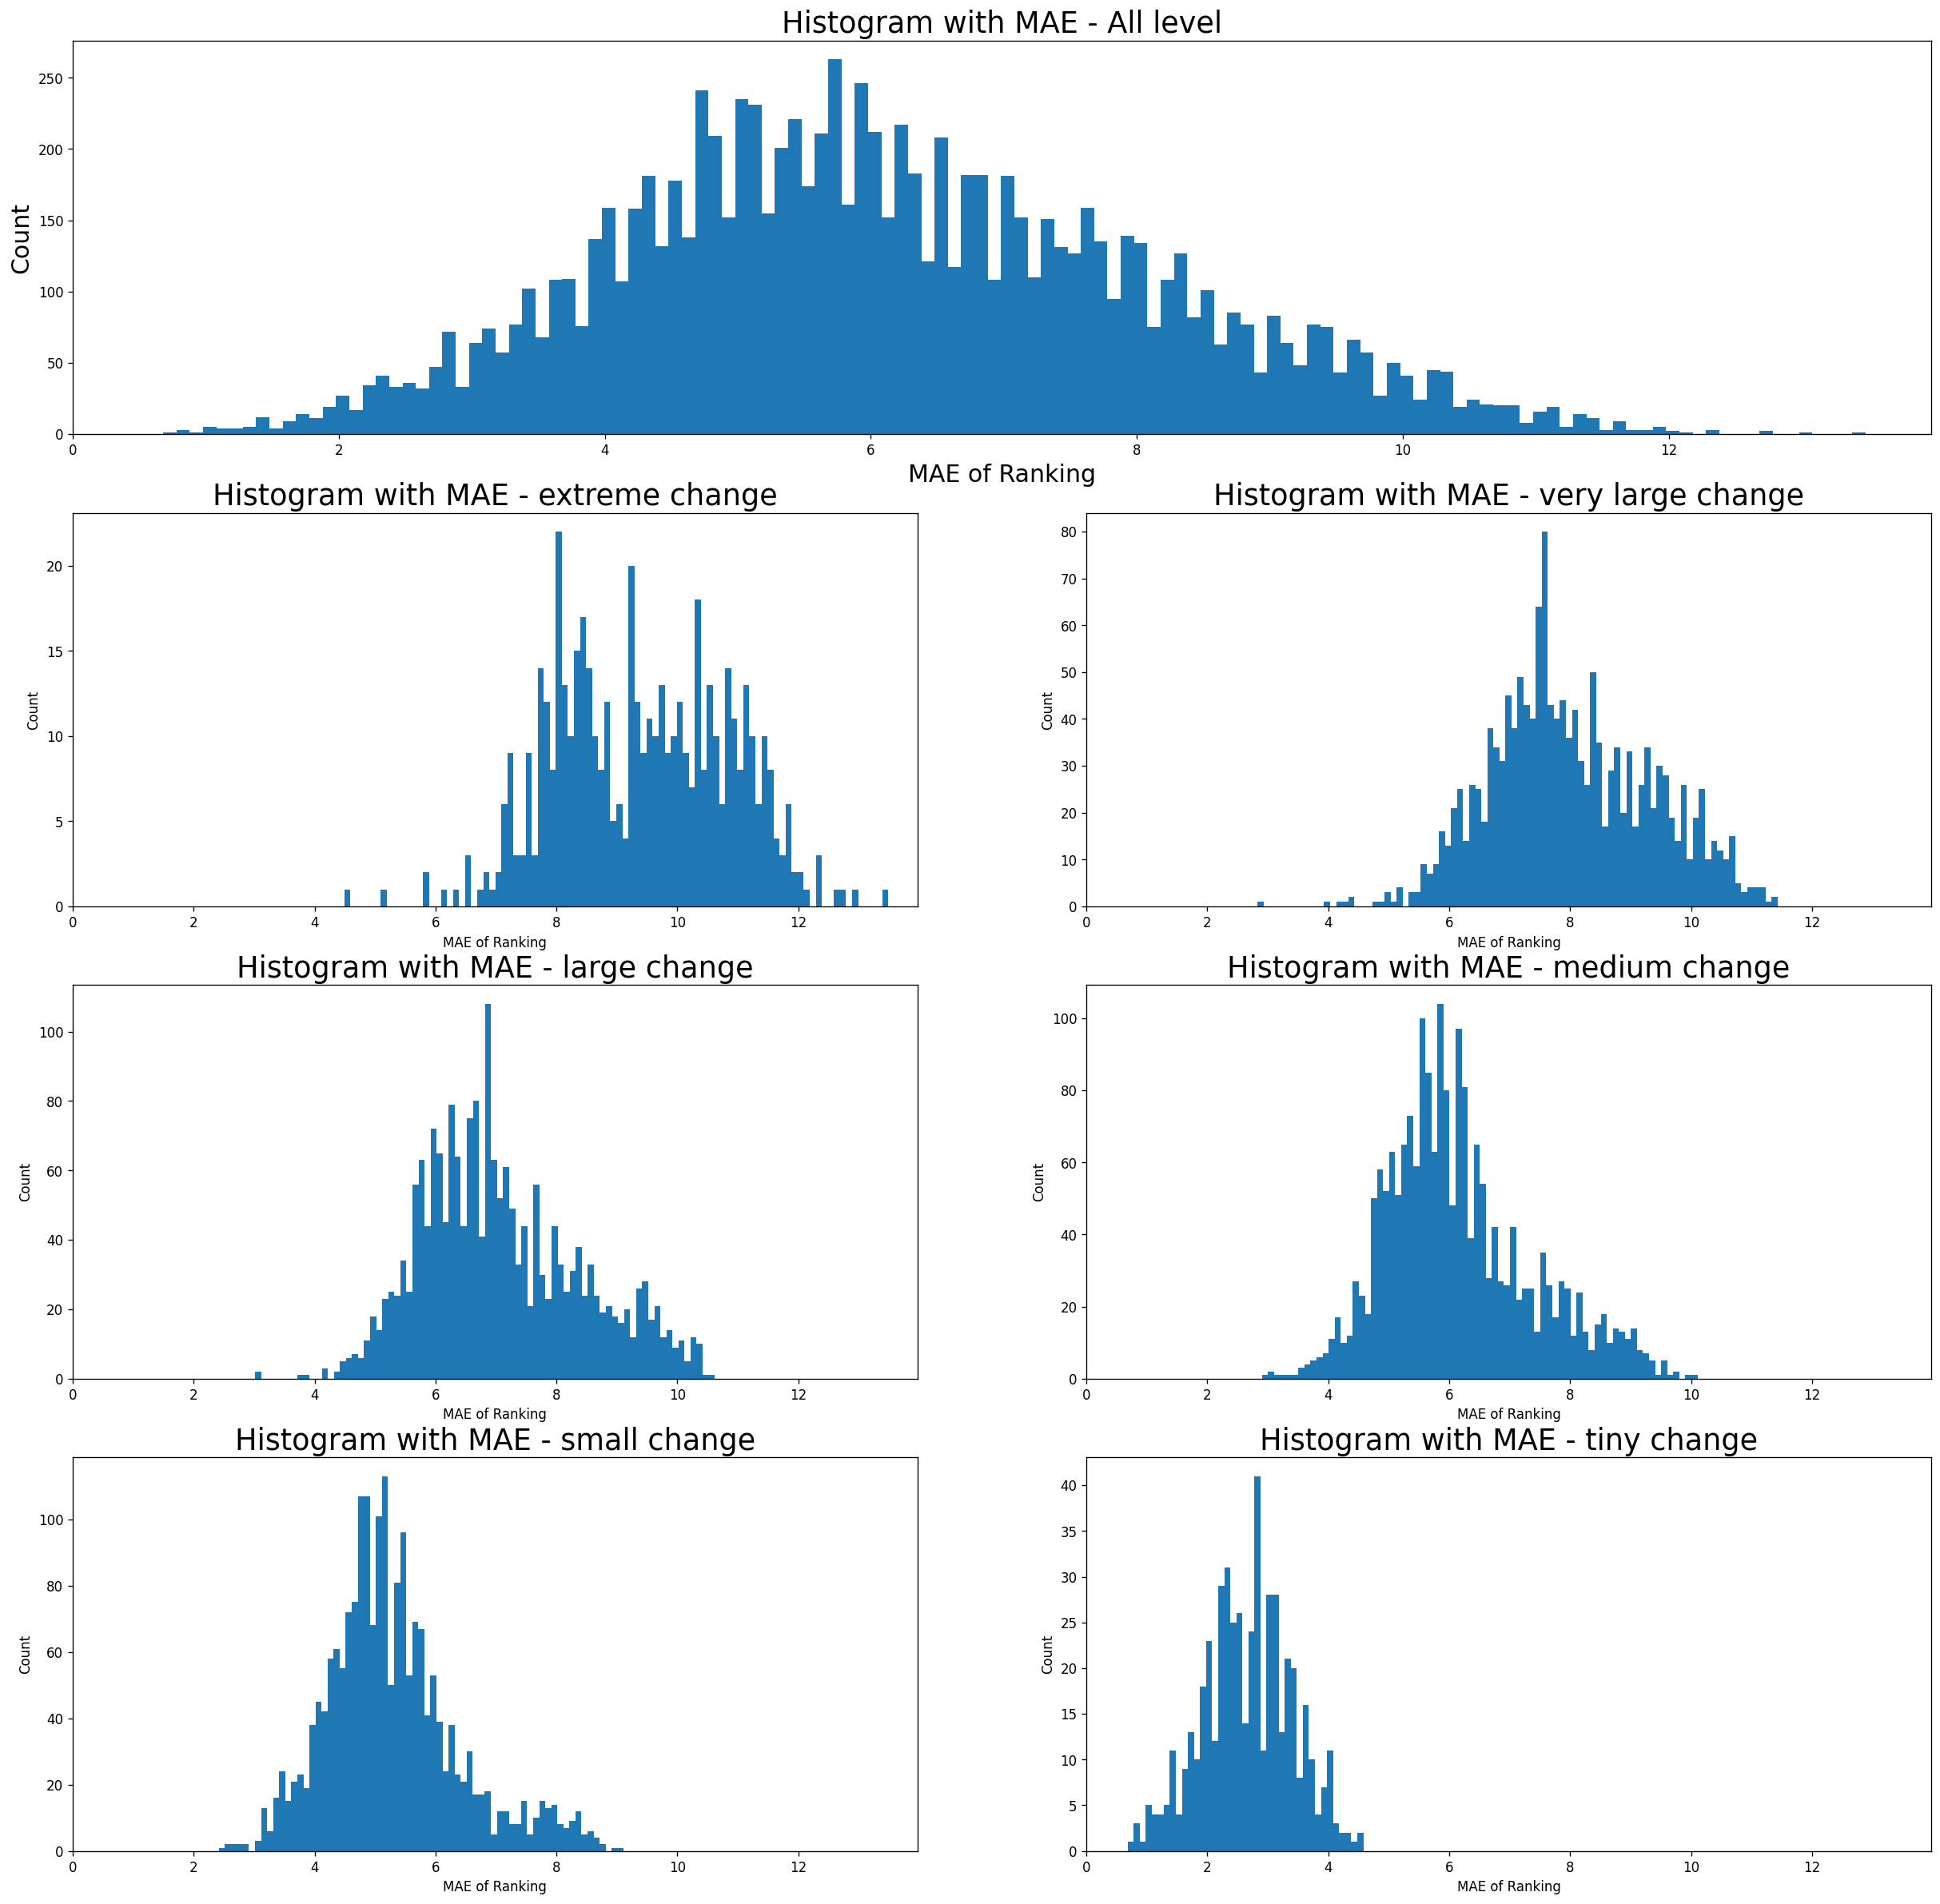

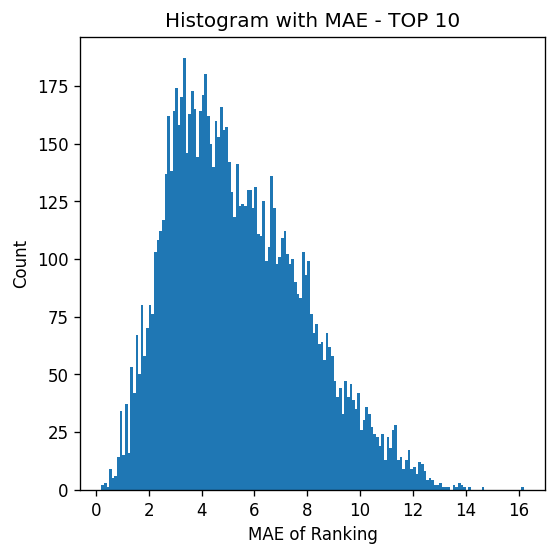

In [ ]:
weight_shuffle_first,first_10_MAE_shuffle_first = One_job_analytics(Raw_data = path_to_data_folder, Job_id = 456, baseline_weight= [0.2018,0.3028,0.1014,0.1821,0.2119], sd = 0.1, iter_times = 10000,
                            Expert_yrs_set_up = 10, Intermediate_yrs_set_up = 6.5, Beginner_yrs_set_up = 2,
                                proficiency_far_below = 0.6, proficiency_below = 0.8, proficiency_meets = 1, proficiency_above = 1.1, proficiency_far_above = 1.2,
                                        yrs_exp_function_name = col_sigmoid, last_used_function_name = col_sigmoid, 
                                            yrs_slope = 0.5, yrs_horizontal_shift = 7,
                                                last_slope = -0.8, last_horizontal_shift = 6, bin_length = 0.1)

In [ ]:
#weight

In [ ]:
weight_shuffle_first

cluster_weight_1  cluster_weight_2  cluster_weight_3  cluster_weight_4  \
0             0.247037          0.375499          0.000000          0.254212   
1             0.347139          0.274142          0.176905          0.142031   
2             0.113511          0.229587          0.082102          0.451239   
3             0.194661          0.320817          0.178633          0.298547   
4             0.213259          0.396655          0.172958          0.088316   
...                ...               ...               ...               ...   
9995          0.353322          0.252892          0.012318          0.000000   
9996          0.120919          0.250355          0.312449          0.201777   
9997          0.152383          0.387709          0.058112          0.000000   
9998          0.071506          0.420899          0.112554          0.134163   
9999          0.310043          0.292338          0.233863          0.033218   

      cluster_weight_5    change       MAE              level  
0             0.123252  0.076019  5.320755       small change  
1             0.059782  0.088338  5.358491      medium change  
2             0.123561  0.107656  6.905660       large change  
3             0.007342  0.084679  6.415094      medium change  
4             0.128811  0.070749  5.773585       small change  
...                ...       ...       ...                ...  
9995          0.381469  0.128436  9.886792  very large change  
9996          0.114500  0.092291  7.358491      medium change  
9997          0.401797  0.109922  9.698113       large change  
9998          0.260877  0.071292  3.962264       small change  
9999          0.130538  0.096282  8.490566       large change  

[10000 rows x 8 columns]

# Different Baseline

In [ ]:
sd_list = [0.003,0.02,0.1]
data_set_list = [path_to_data_folder,path_to_500,path_to_1000]
data_set_name = ['path_to_data_folder','path_to_500','path_to_1000']
bin_length_list = [0.04, 0.1, 1]

## Base line is [0.2,0.2,0.2,0.2,0.2]

folder name: path_to_data_folder sd = 0.003: 
min: 0.0002113622404282034
quantile 5%: 0.001159065284840919
quantile 20%: 0.0018029530638483237
quantile 40%: 0.0023867172607941367
quantile 60%: 0.0030271343675050497
quantile 80%: 0.0038423454816046646
quantile 95%: 0.005209520099081389
max: 0.009767639645925613
mean of MAE for Ranking (All level): 0.22644905660377357
mean of MAE for Ranking (Extreme change): 0.49833962264150944
mean of MAE for Ranking (very large change): 0.35338364779874215
mean of MAE for Ranking (large change): 0.2671509433962264
mean of MAE for Ranking (medium change): 0.20837735849056602
mean of MAE for Ranking (small change): 0.16184905660377358
mean of MAE for Ranking (tiny change): 0.059698113207547164
mean of MAE for Ranking (TOP 10 change): 0.16788000000000003
 
mode of MAE for Ranking (All level): [(0.1509433962264151, 1431)]
mode of MAE for Ranking (Extreme change): [(0.5660377358490566, 46)]
mode of MAE for Ranking (very large change): [(0.41509433962264153

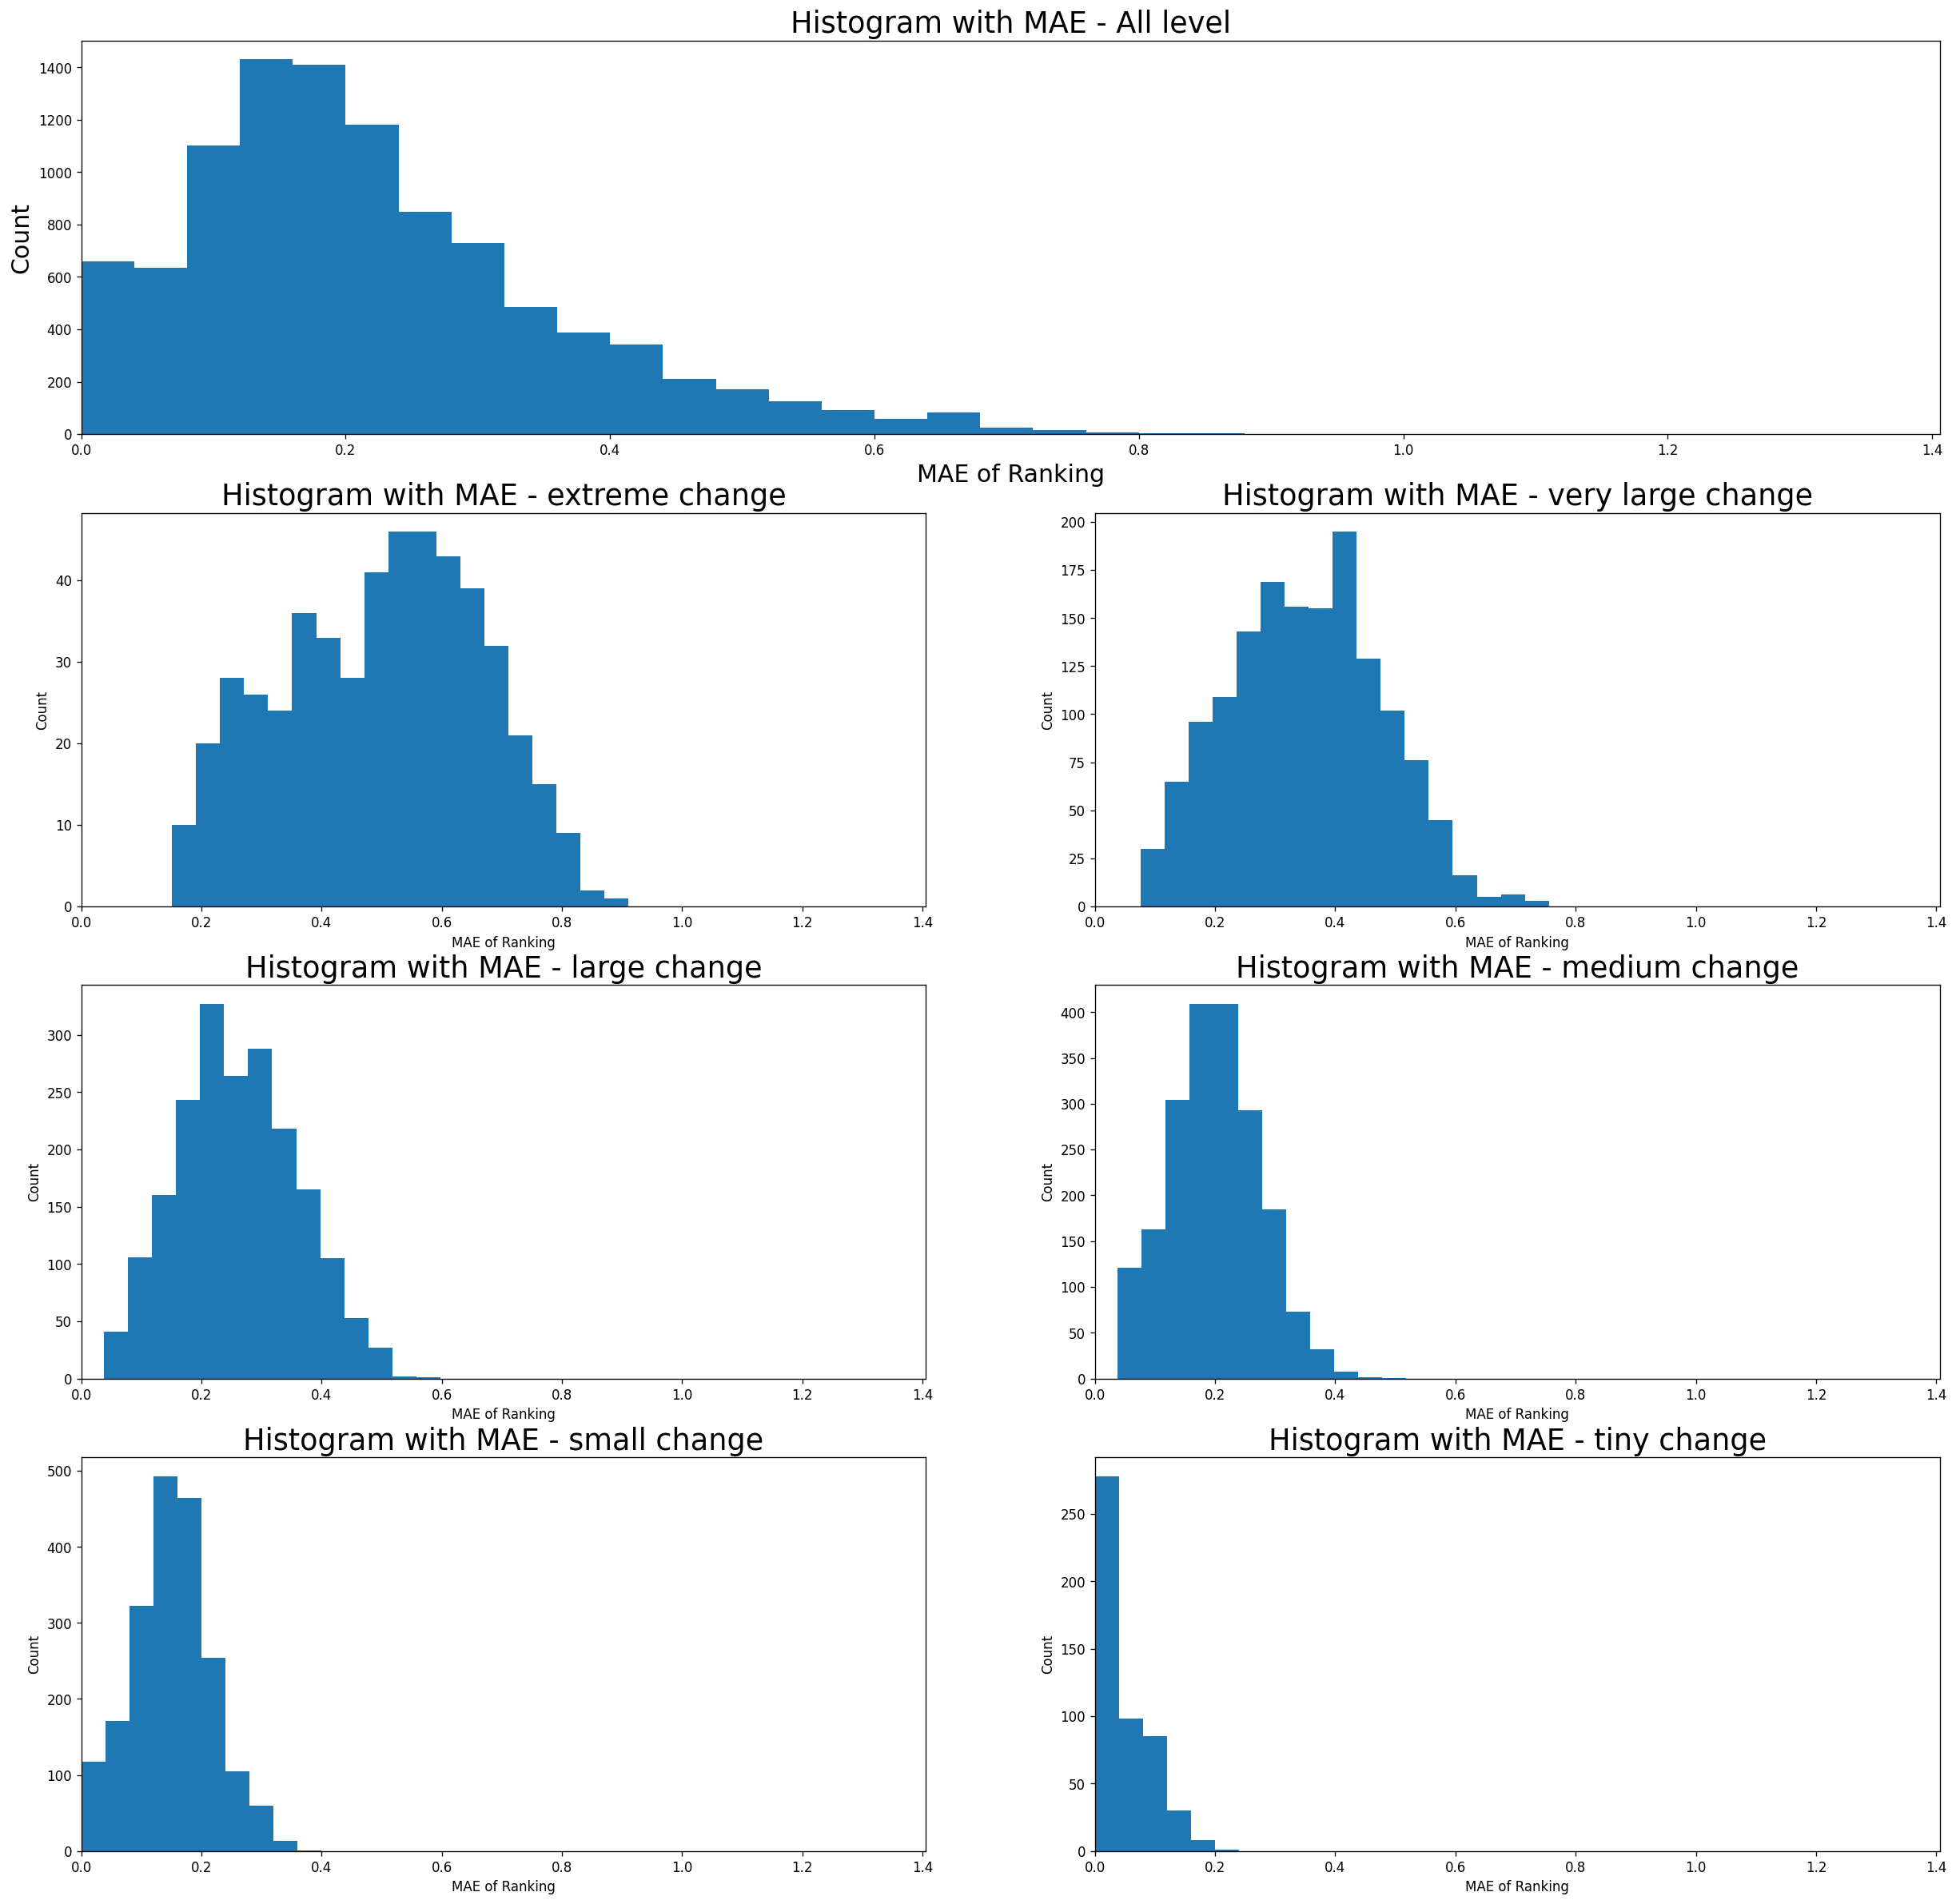

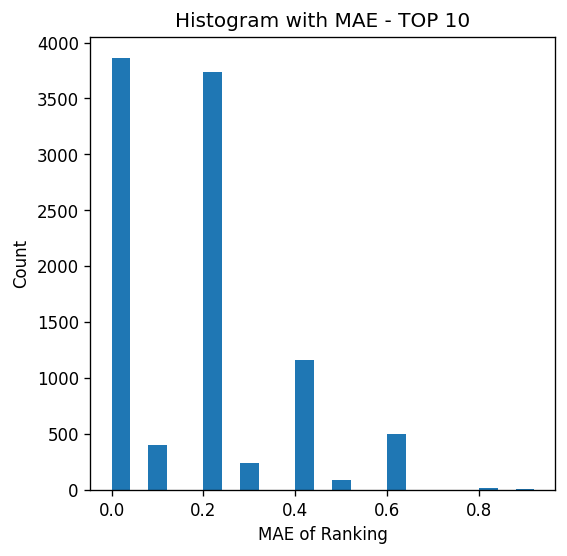

folder name: path_to_data_folder sd = 0.02: 
min: 0.0009124727340904748
quantile 5%: 0.00800804005787764
quantile 20%: 0.012223187456263475
quantile 40%: 0.016064428467840865
quantile 60%: 0.02011308190428088
quantile 80%: 0.025609773919319942
quantile 95%: 0.03449874458899645
max: 0.06718538607510037
mean of MAE for Ranking (All level): 1.515822641509434
mean of MAE for Ranking (Extreme change): 2.9367547169811323
mean of MAE for Ranking (very large change): 2.2566289308176097
mean of MAE for Ranking (large change): 1.7817735849056604
mean of MAE for Ranking (medium change): 1.4496415094339623
mean of MAE for Ranking (small change): 1.161132075471698
mean of MAE for Ranking (tiny change): 0.5023396226415094
mean of MAE for Ranking (TOP 10 change): 1.19331
 
mode of MAE for Ranking (All level): [(1.0943396226415094, 261)]
mode of MAE for Ranking (Extreme change): [(3.3962264150943398, 16)]
mode of MAE for Ranking (very large change): [(2.188679245283019, 50)]
mode of MAE for Ranking (l

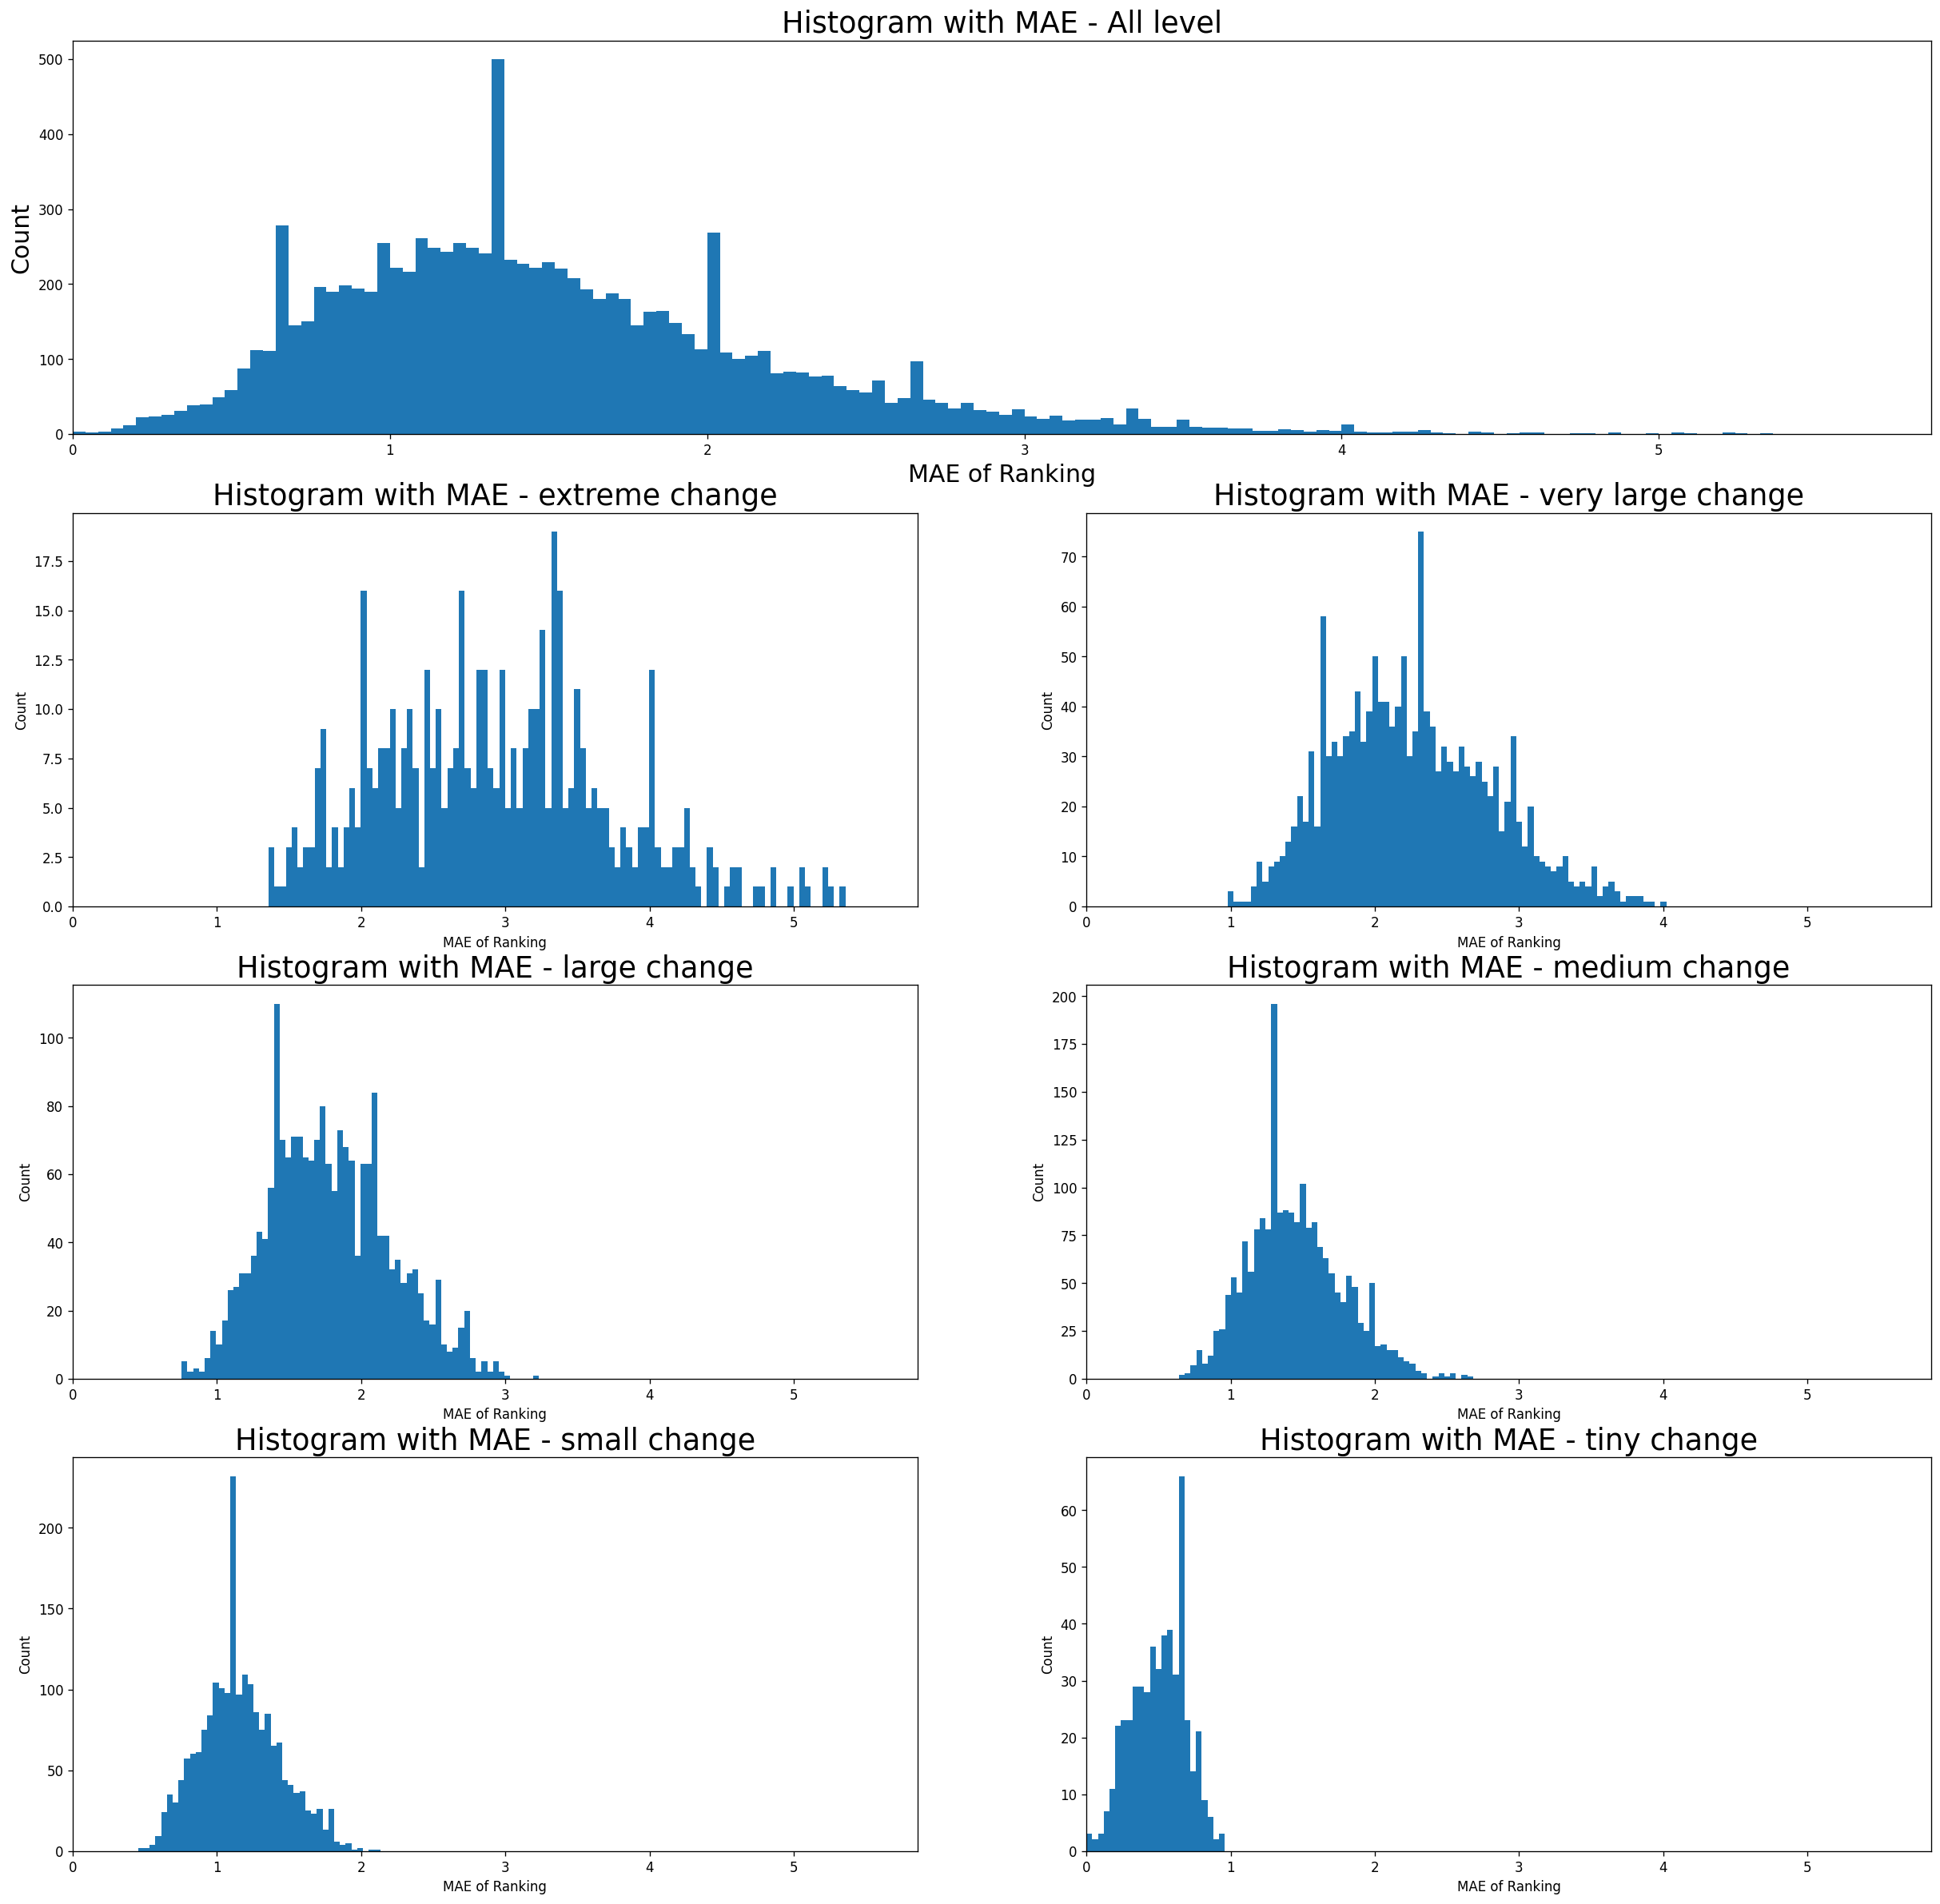

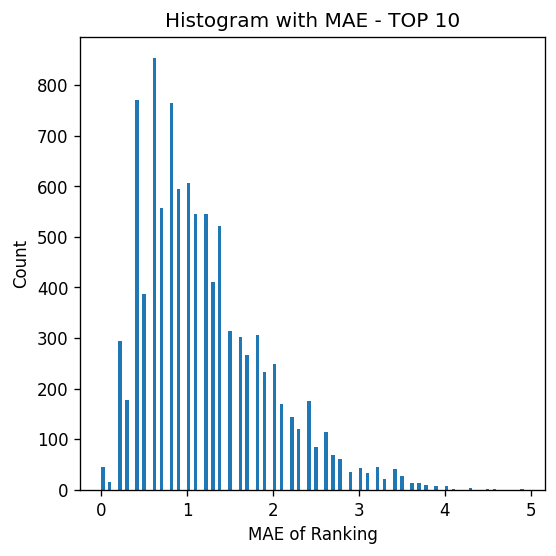

folder name: path_to_data_folder sd = 0.1: 
min: 0.009573226165470466
quantile 5%: 0.03925928760300626
quantile 20%: 0.06092792520587772
quantile 40%: 0.07999999999999999
quantile 60%: 0.09502726629376065
quantile 80%: 0.11771249519560611
quantile 95%: 0.15539529861878668
max: 0.25558786588269466
mean of MAE for Ranking (All level): 5.532124528301887
mean of MAE for Ranking (Extreme change): 8.811849056603775
mean of MAE for Ranking (very large change): 7.4342893081761
mean of MAE for Ranking (large change): 6.358924528301887
mean of MAE for Ranking (medium change): 5.553810425391023
mean of MAE for Ranking (small change): 4.684074402802034
mean of MAE for Ranking (tiny change): 2.349735849056604
mean of MAE for Ranking (TOP 10 change): 5.1062899999999996
 
mode of MAE for Ranking (All level): [(3.9622641509433962, 98)]
mode of MAE for Ranking (Extreme change): [(7.886792452830188, 9)]
mode of MAE for Ranking (very large change): [(6.339622641509434, 21)]
mode of MAE for Ranking (large

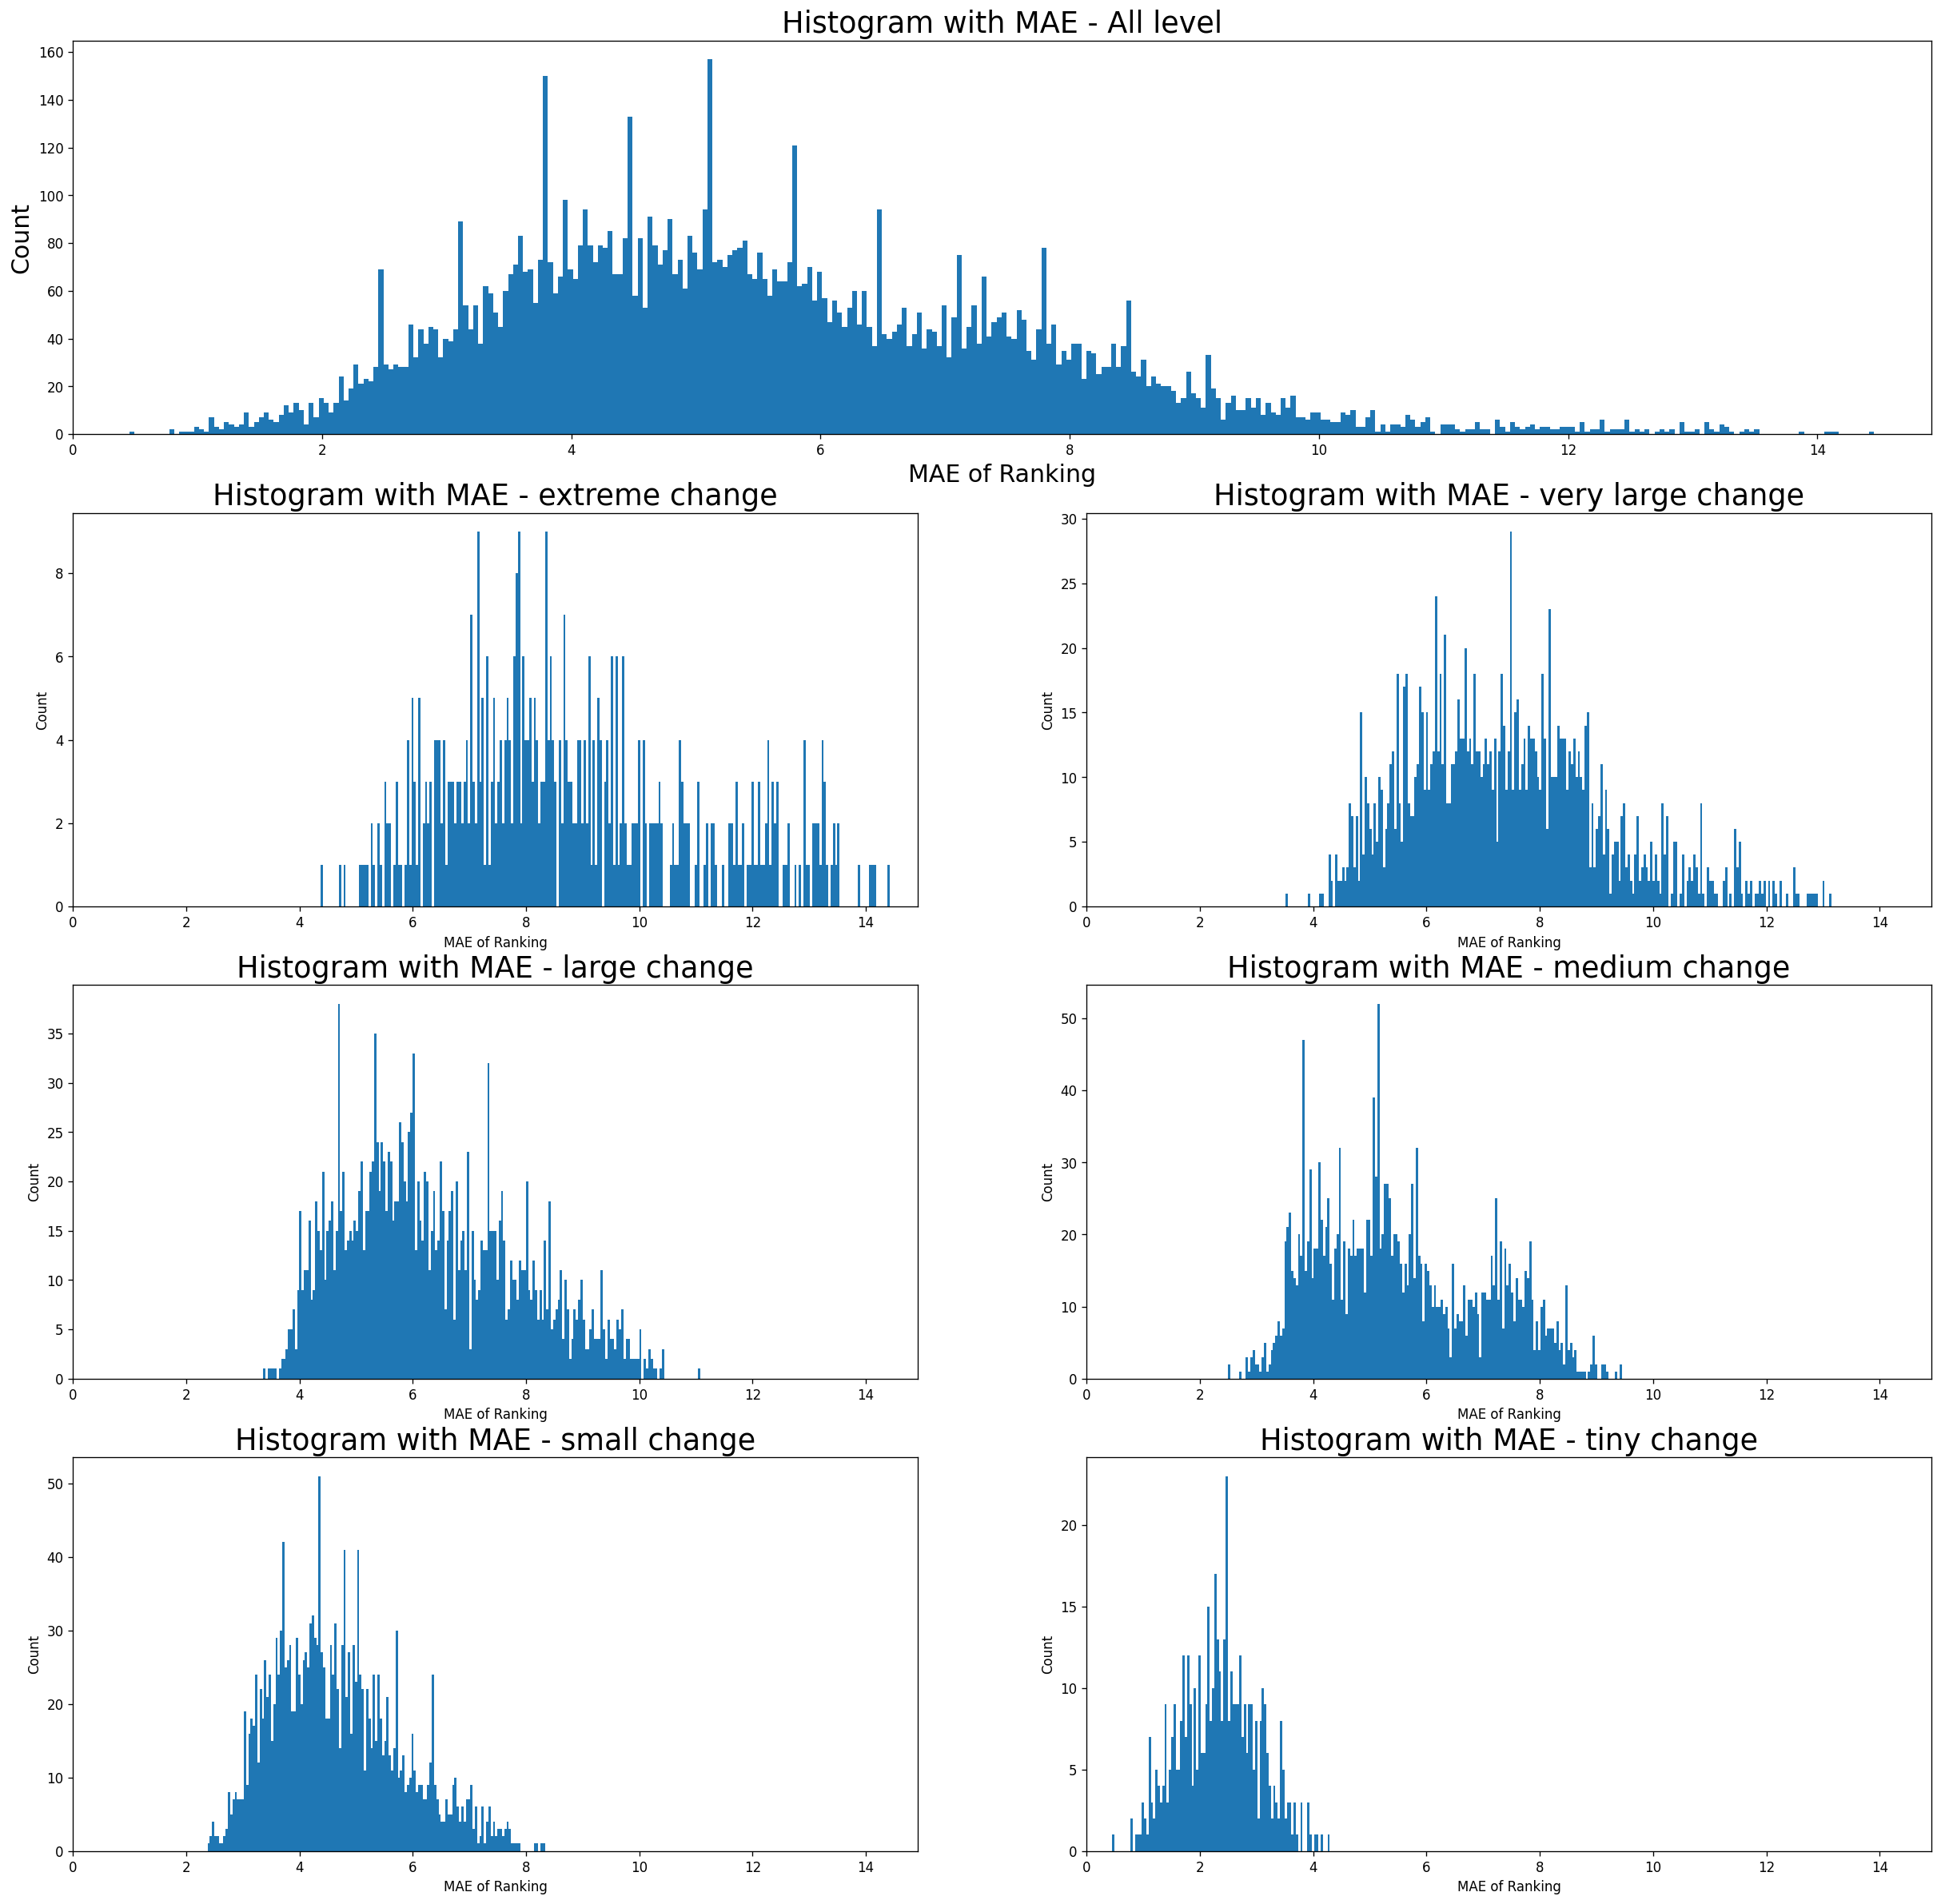

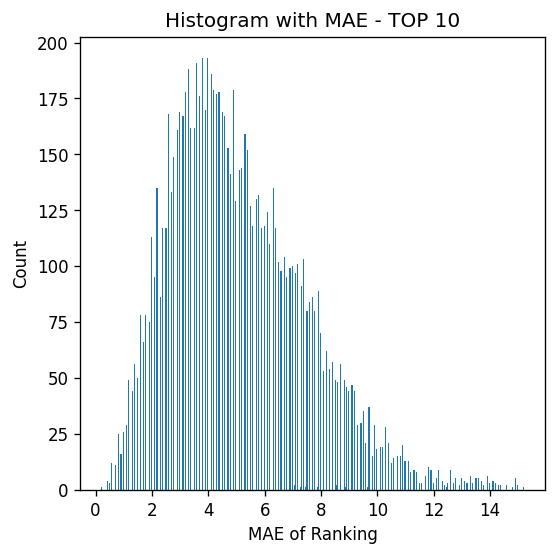

folder name: path_to_500 sd = 0.003: 
min: 0.0002064646456262309
quantile 5%: 0.0011734549347296142
quantile 20%: 0.0018379565729057146
quantile 40%: 0.002427592148685807
quantile 60%: 0.003019673982383988
quantile 80%: 0.003834301075498177
quantile 95%: 0.005170924887064392
max: 0.009477116084529863
mean of MAE for Ranking (All level): 1.9167484000000001
mean of MAE for Ranking (Extreme change): 3.824688
mean of MAE for Ranking (very large change): 2.8642906666666663
mean of MAE for Ranking (large change): 2.2106260000000004
mean of MAE for Ranking (medium change): 1.8136599999999998
mean of MAE for Ranking (small change): 1.466648
mean of MAE for Ranking (tiny change): 0.6725840000000001
mean of MAE for Ranking (TOP 10 change): 0.37656000000000006
 
mode of MAE for Ranking (All level): [(1.672, 33)]
mode of MAE for Ranking (Extreme change): [(2.952, 4)]
mode of MAE for Ranking (very large change): [(2.168, 11)]
mode of MAE for Ranking (large change): [(2.068, 15)]
mode of MAE for Ran

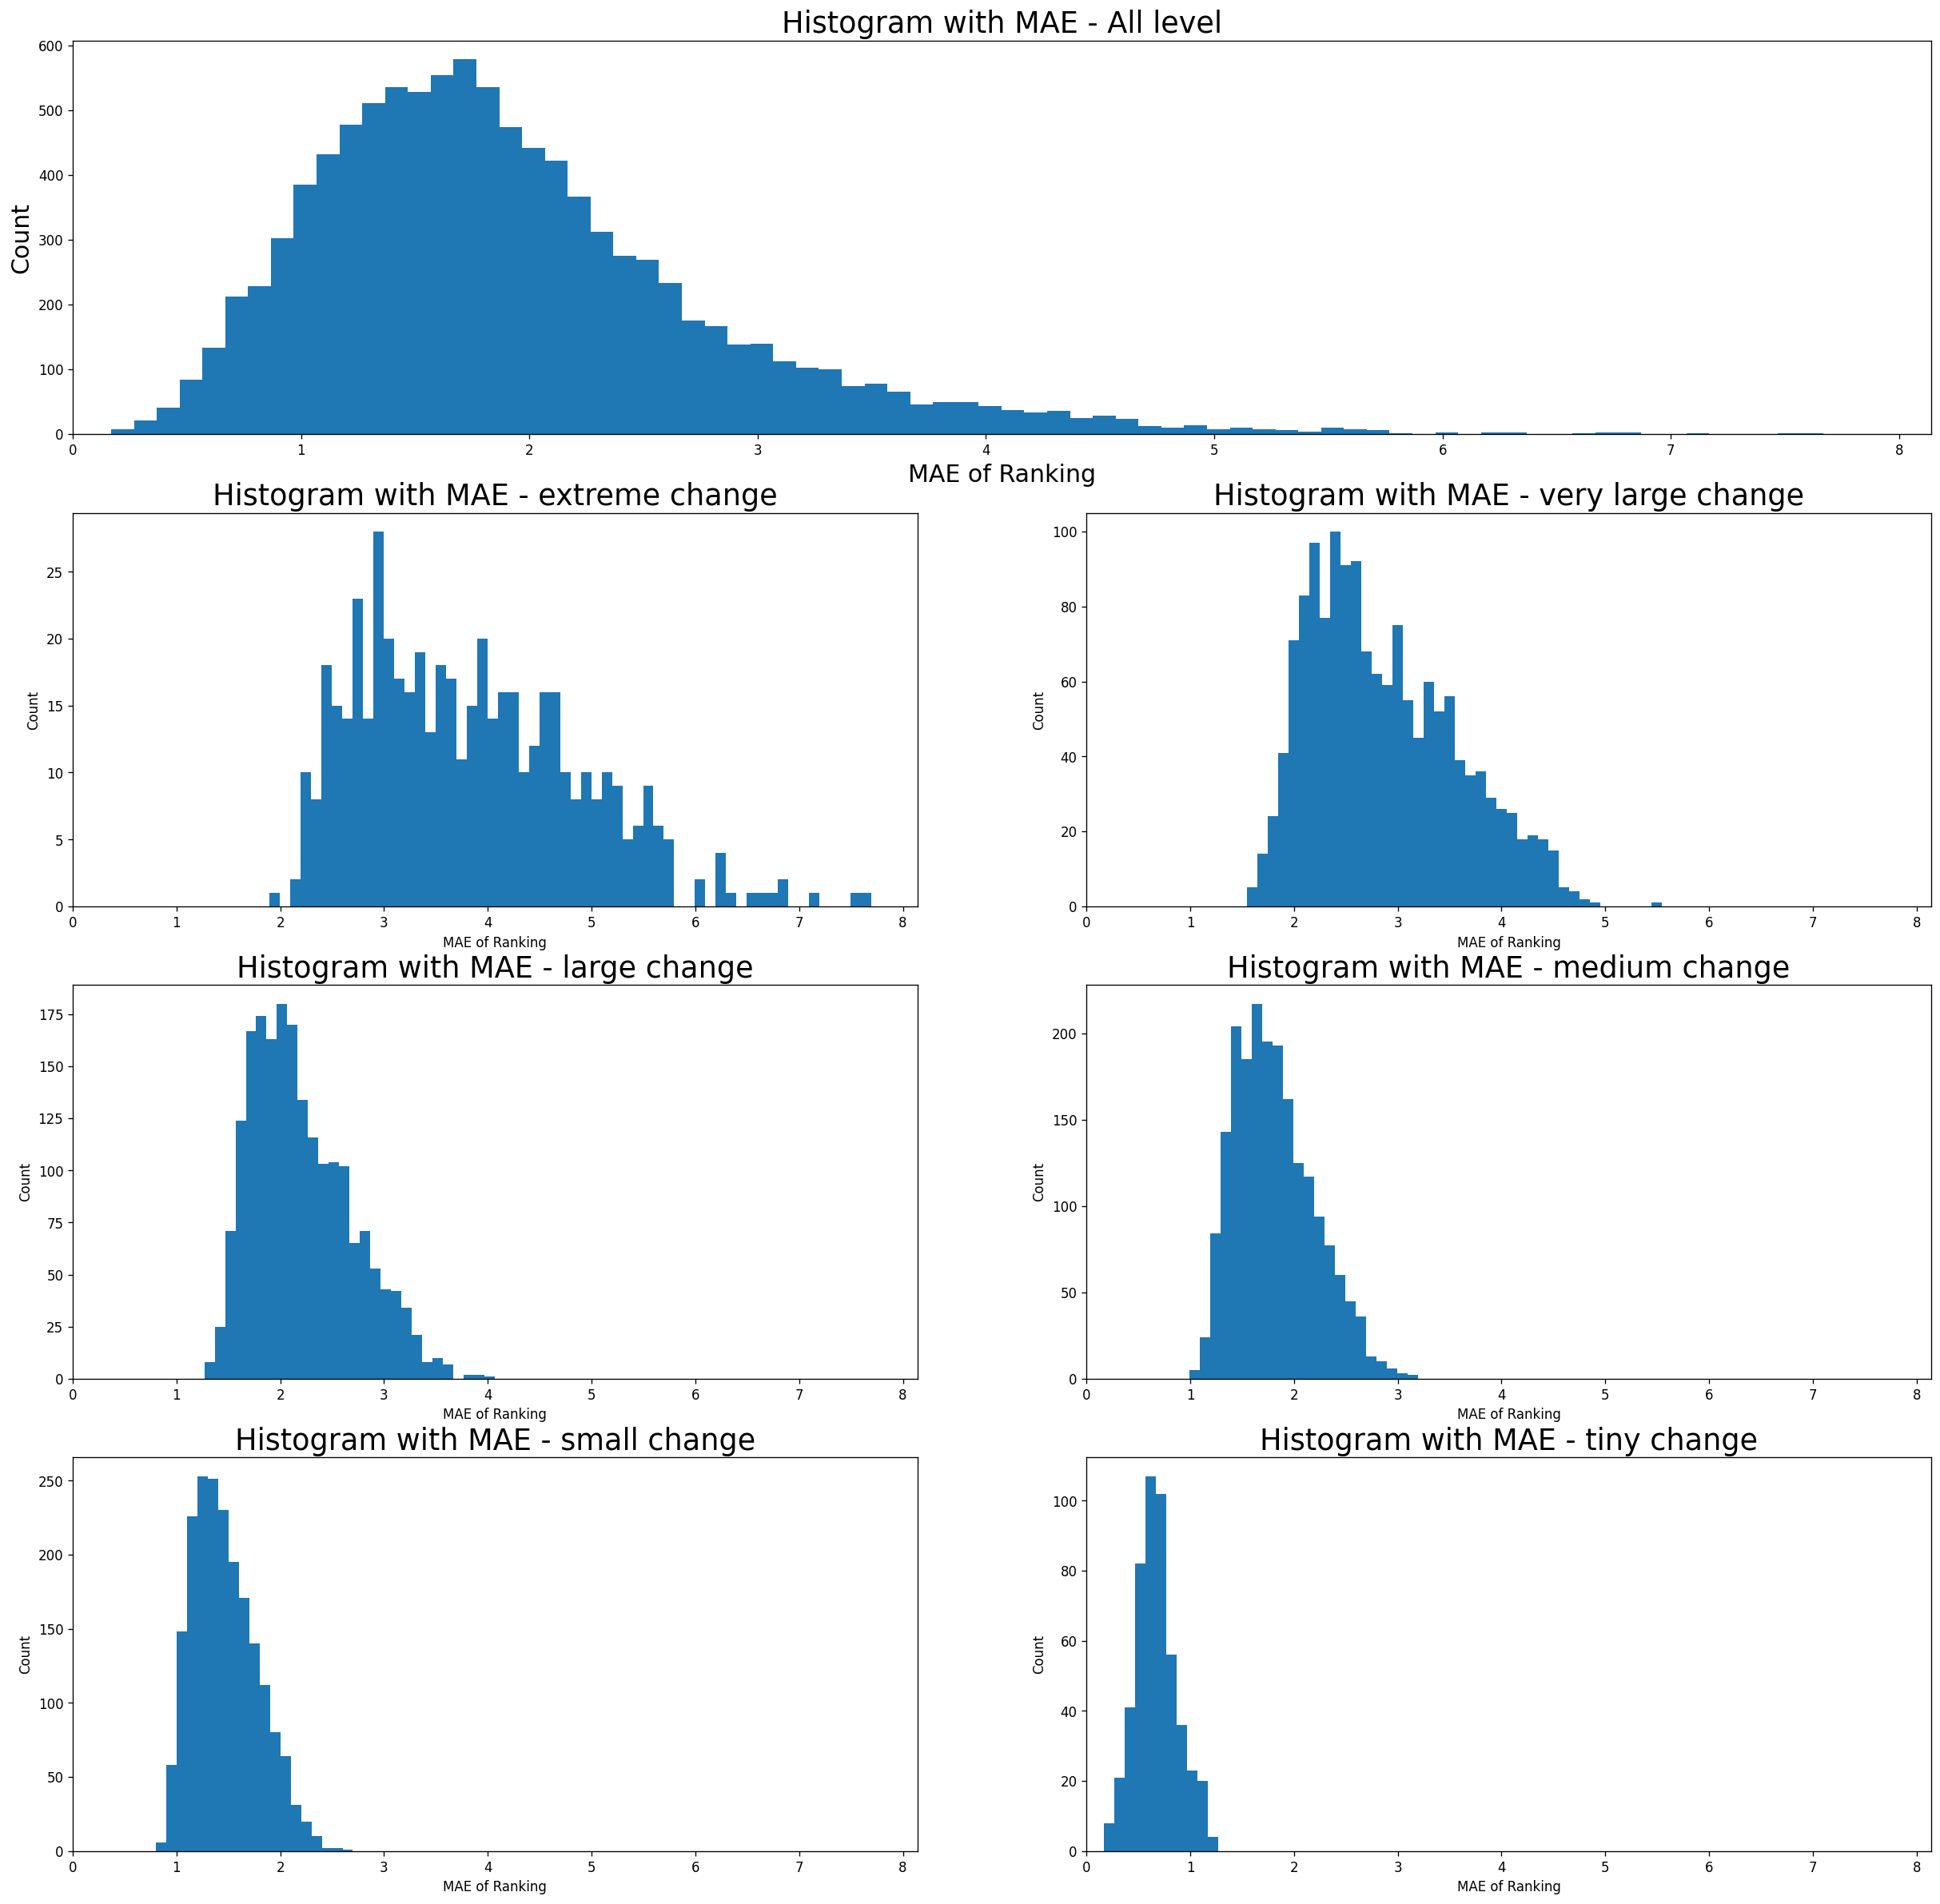

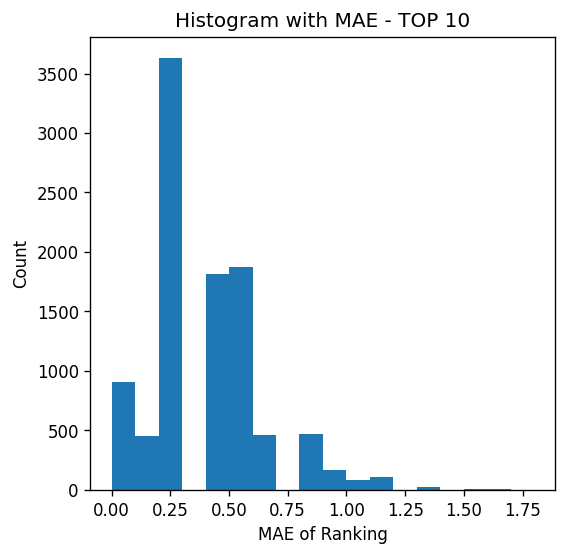

folder name: path_to_500 sd = 0.02: 
min: 0.001277005082860294
quantile 5%: 0.008003781127388868
quantile 20%: 0.012206354980330543
quantile 40%: 0.016160231294942675
quantile 60%: 0.020165936709760763
quantile 80%: 0.025643606284458022
quantile 95%: 0.0342982054481451
max: 0.07001545328035255
mean of MAE for Ranking (All level): 11.832774
mean of MAE for Ranking (Extreme change): 24.103064
mean of MAE for Ranking (very large change): 17.871168
mean of MAE for Ranking (large change): 13.918558
mean of MAE for Ranking (medium change): 11.163866000000002
mean of MAE for Ranking (small change): 8.778536
mean of MAE for Ranking (tiny change): 4.148208
mean of MAE for Ranking (TOP 10 change): 2.01188
 
mode of MAE for Ranking (All level): [(8.872, 10)]
mode of MAE for Ranking (Extreme change): [(22.46, 3)]
mode of MAE for Ranking (very large change): [(14.788, 4)]
mode of MAE for Ranking (large change): [(11.944, 5)]
mode of MAE for Ranking (medium change): [(10.4, 5)]
mode of MAE for Ranki

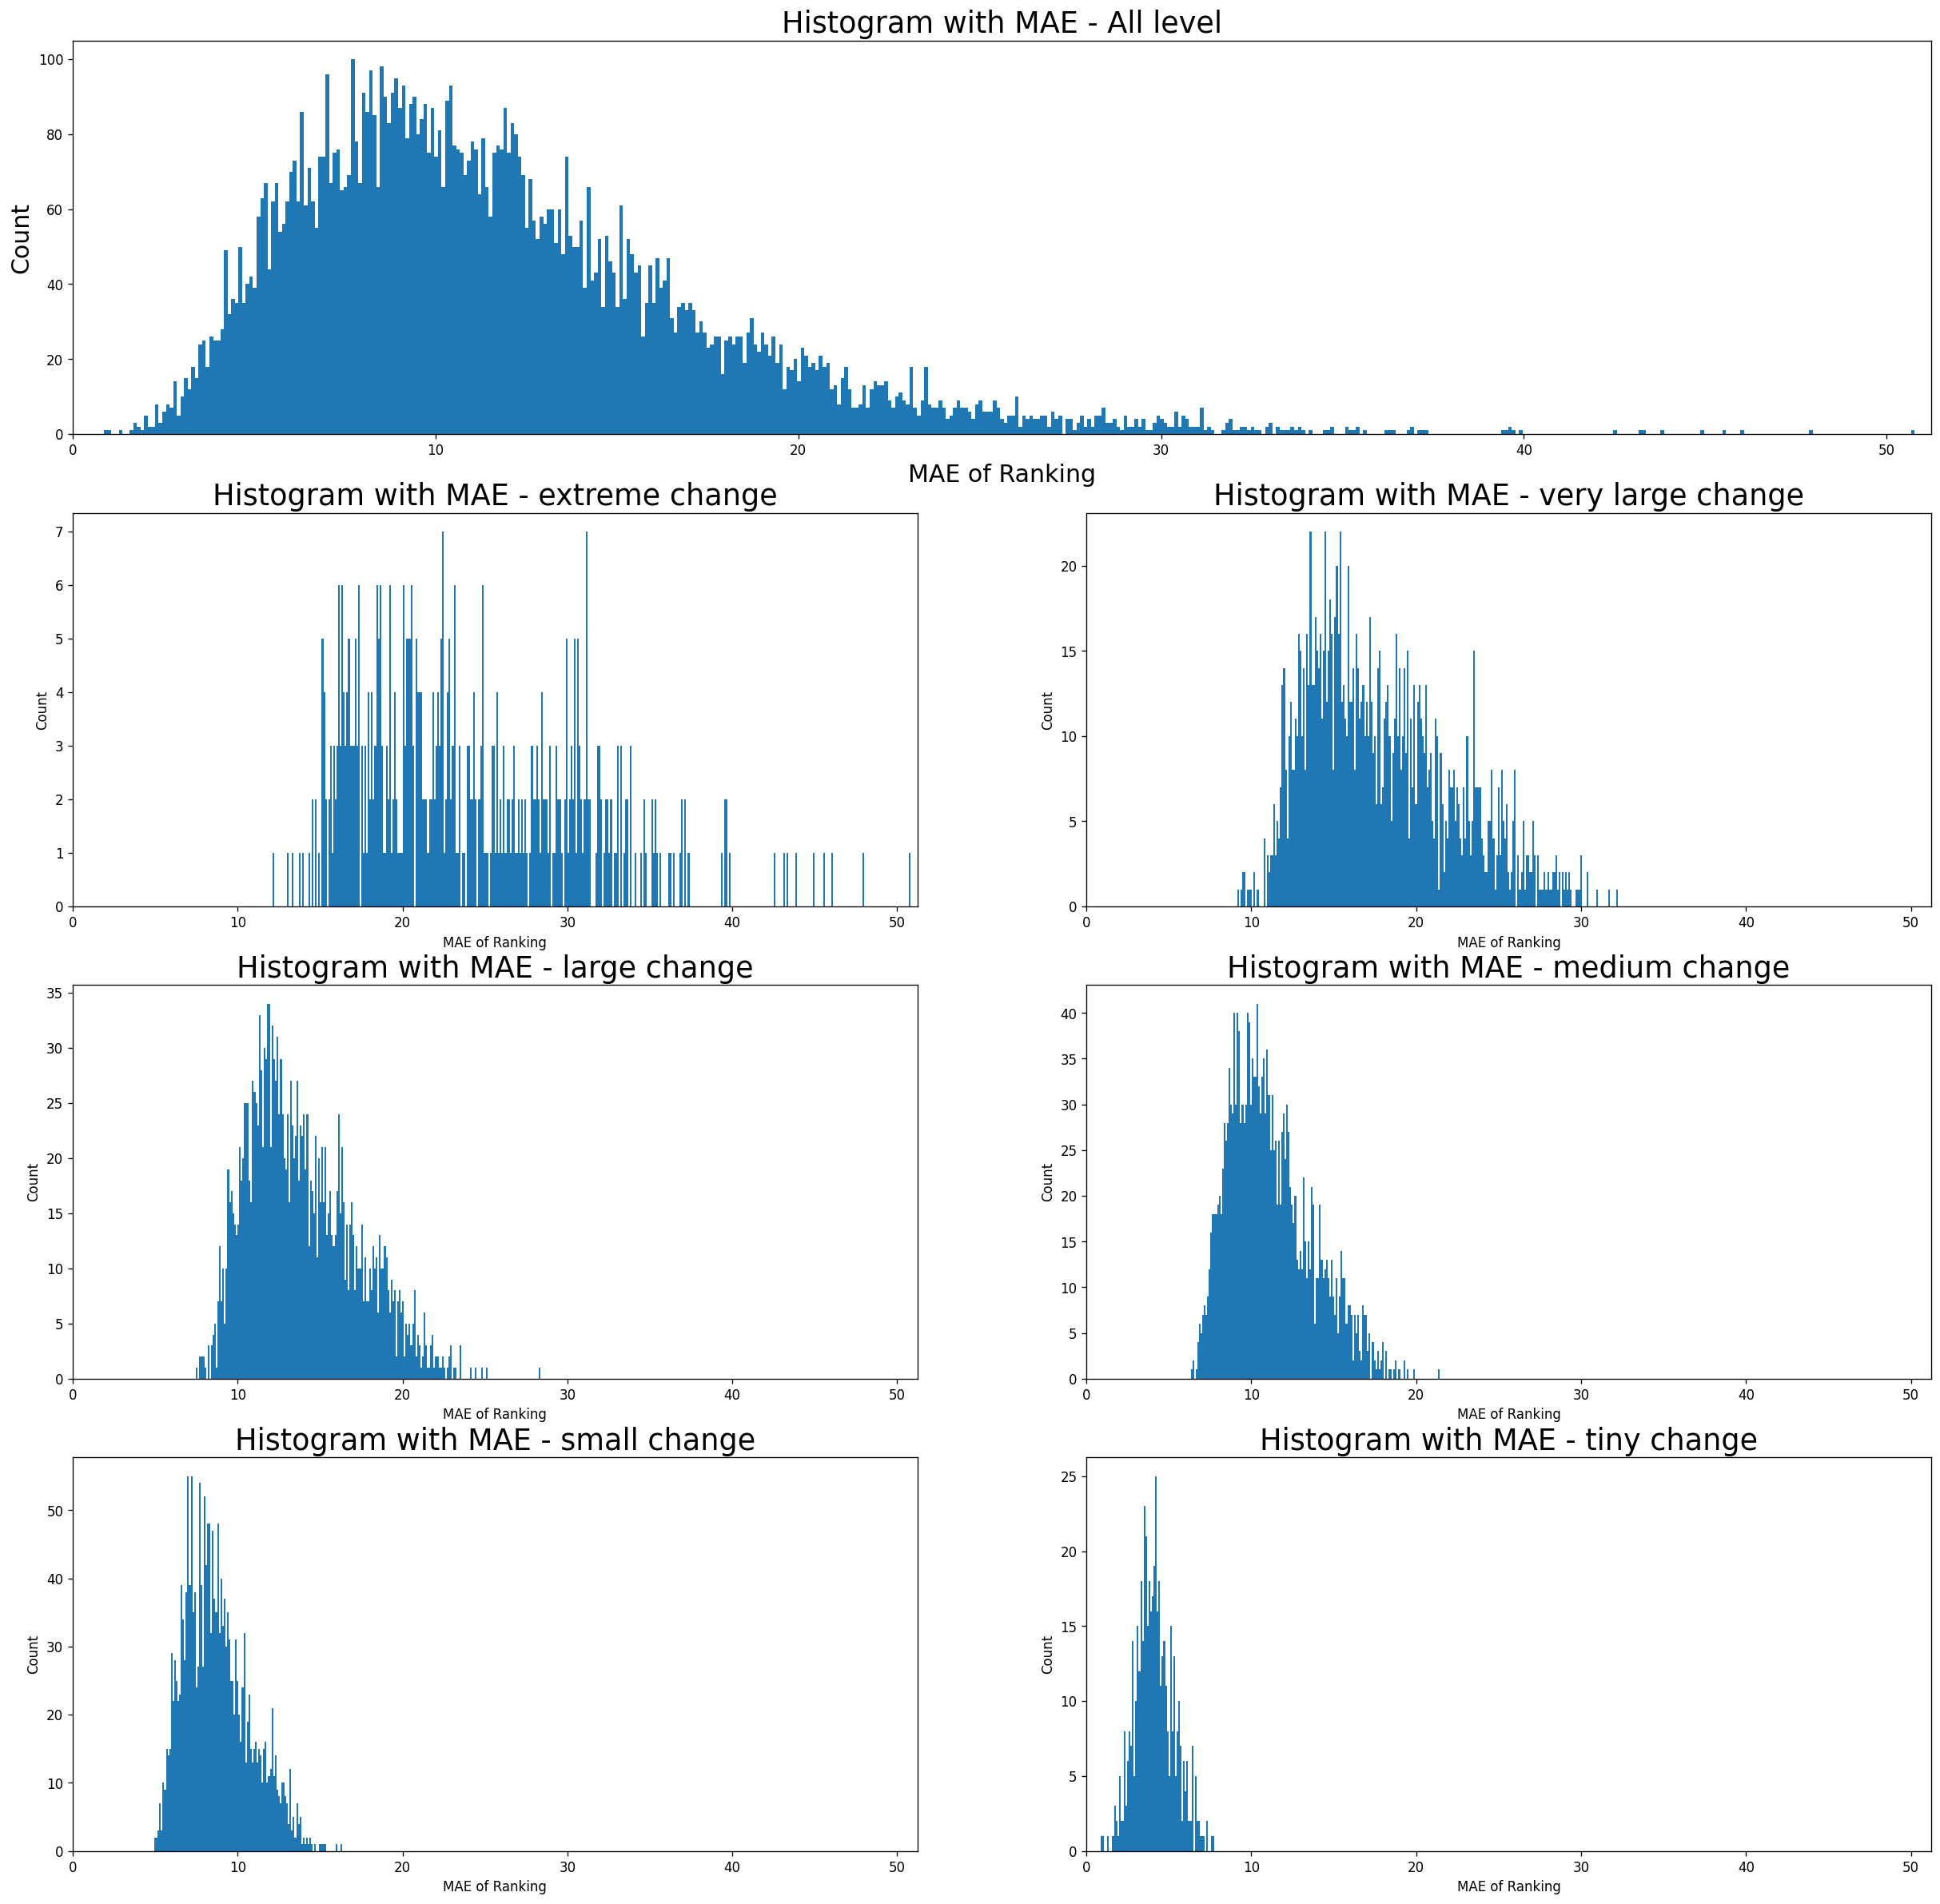

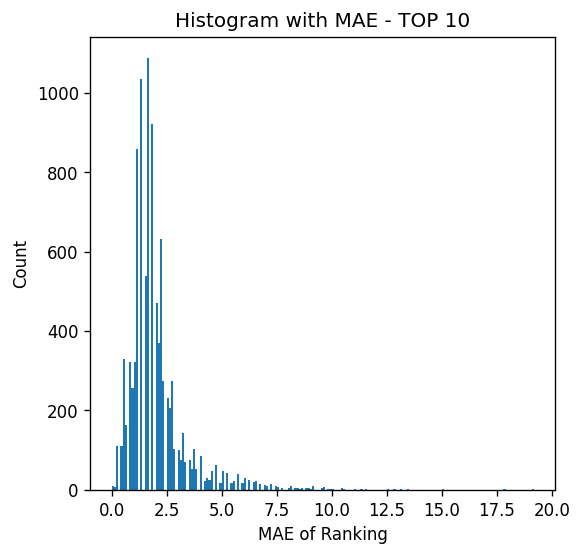

folder name: path_to_500 sd = 0.1: 
min: 0.010275296624029356
quantile 5%: 0.038858285345239676
quantile 20%: 0.060521092273723806
quantile 40%: 0.07999999999999999
quantile 60%: 0.09553957802515314
quantile 80%: 0.118246649893515
quantile 95%: 0.15569912039067824
max: 0.2649030964157699
mean of MAE for Ranking (All level): 49.9740816
mean of MAE for Ranking (Extreme change): 82.20366
mean of MAE for Ranking (very large change): 68.77164133333333
mean of MAE for Ranking (large change): 58.288028999999995
mean of MAE for Ranking (medium change): 50.31972389905987
mean of MAE for Ranking (small change): 41.432228398180904
mean of MAE for Ranking (tiny change): 18.879631999999997
mean of MAE for Ranking (TOP 10 change): 15.208335
 
mode of MAE for Ranking (All level): [(35.82, 6)]
mode of MAE for Ranking (Extreme change): [(77.632, 2)]
mode of MAE for Ranking (very large change): [(80.332, 3)]
mode of MAE for Ranking (large change): [(56.332, 4)]
mode of MAE for Ranking (medium change): [

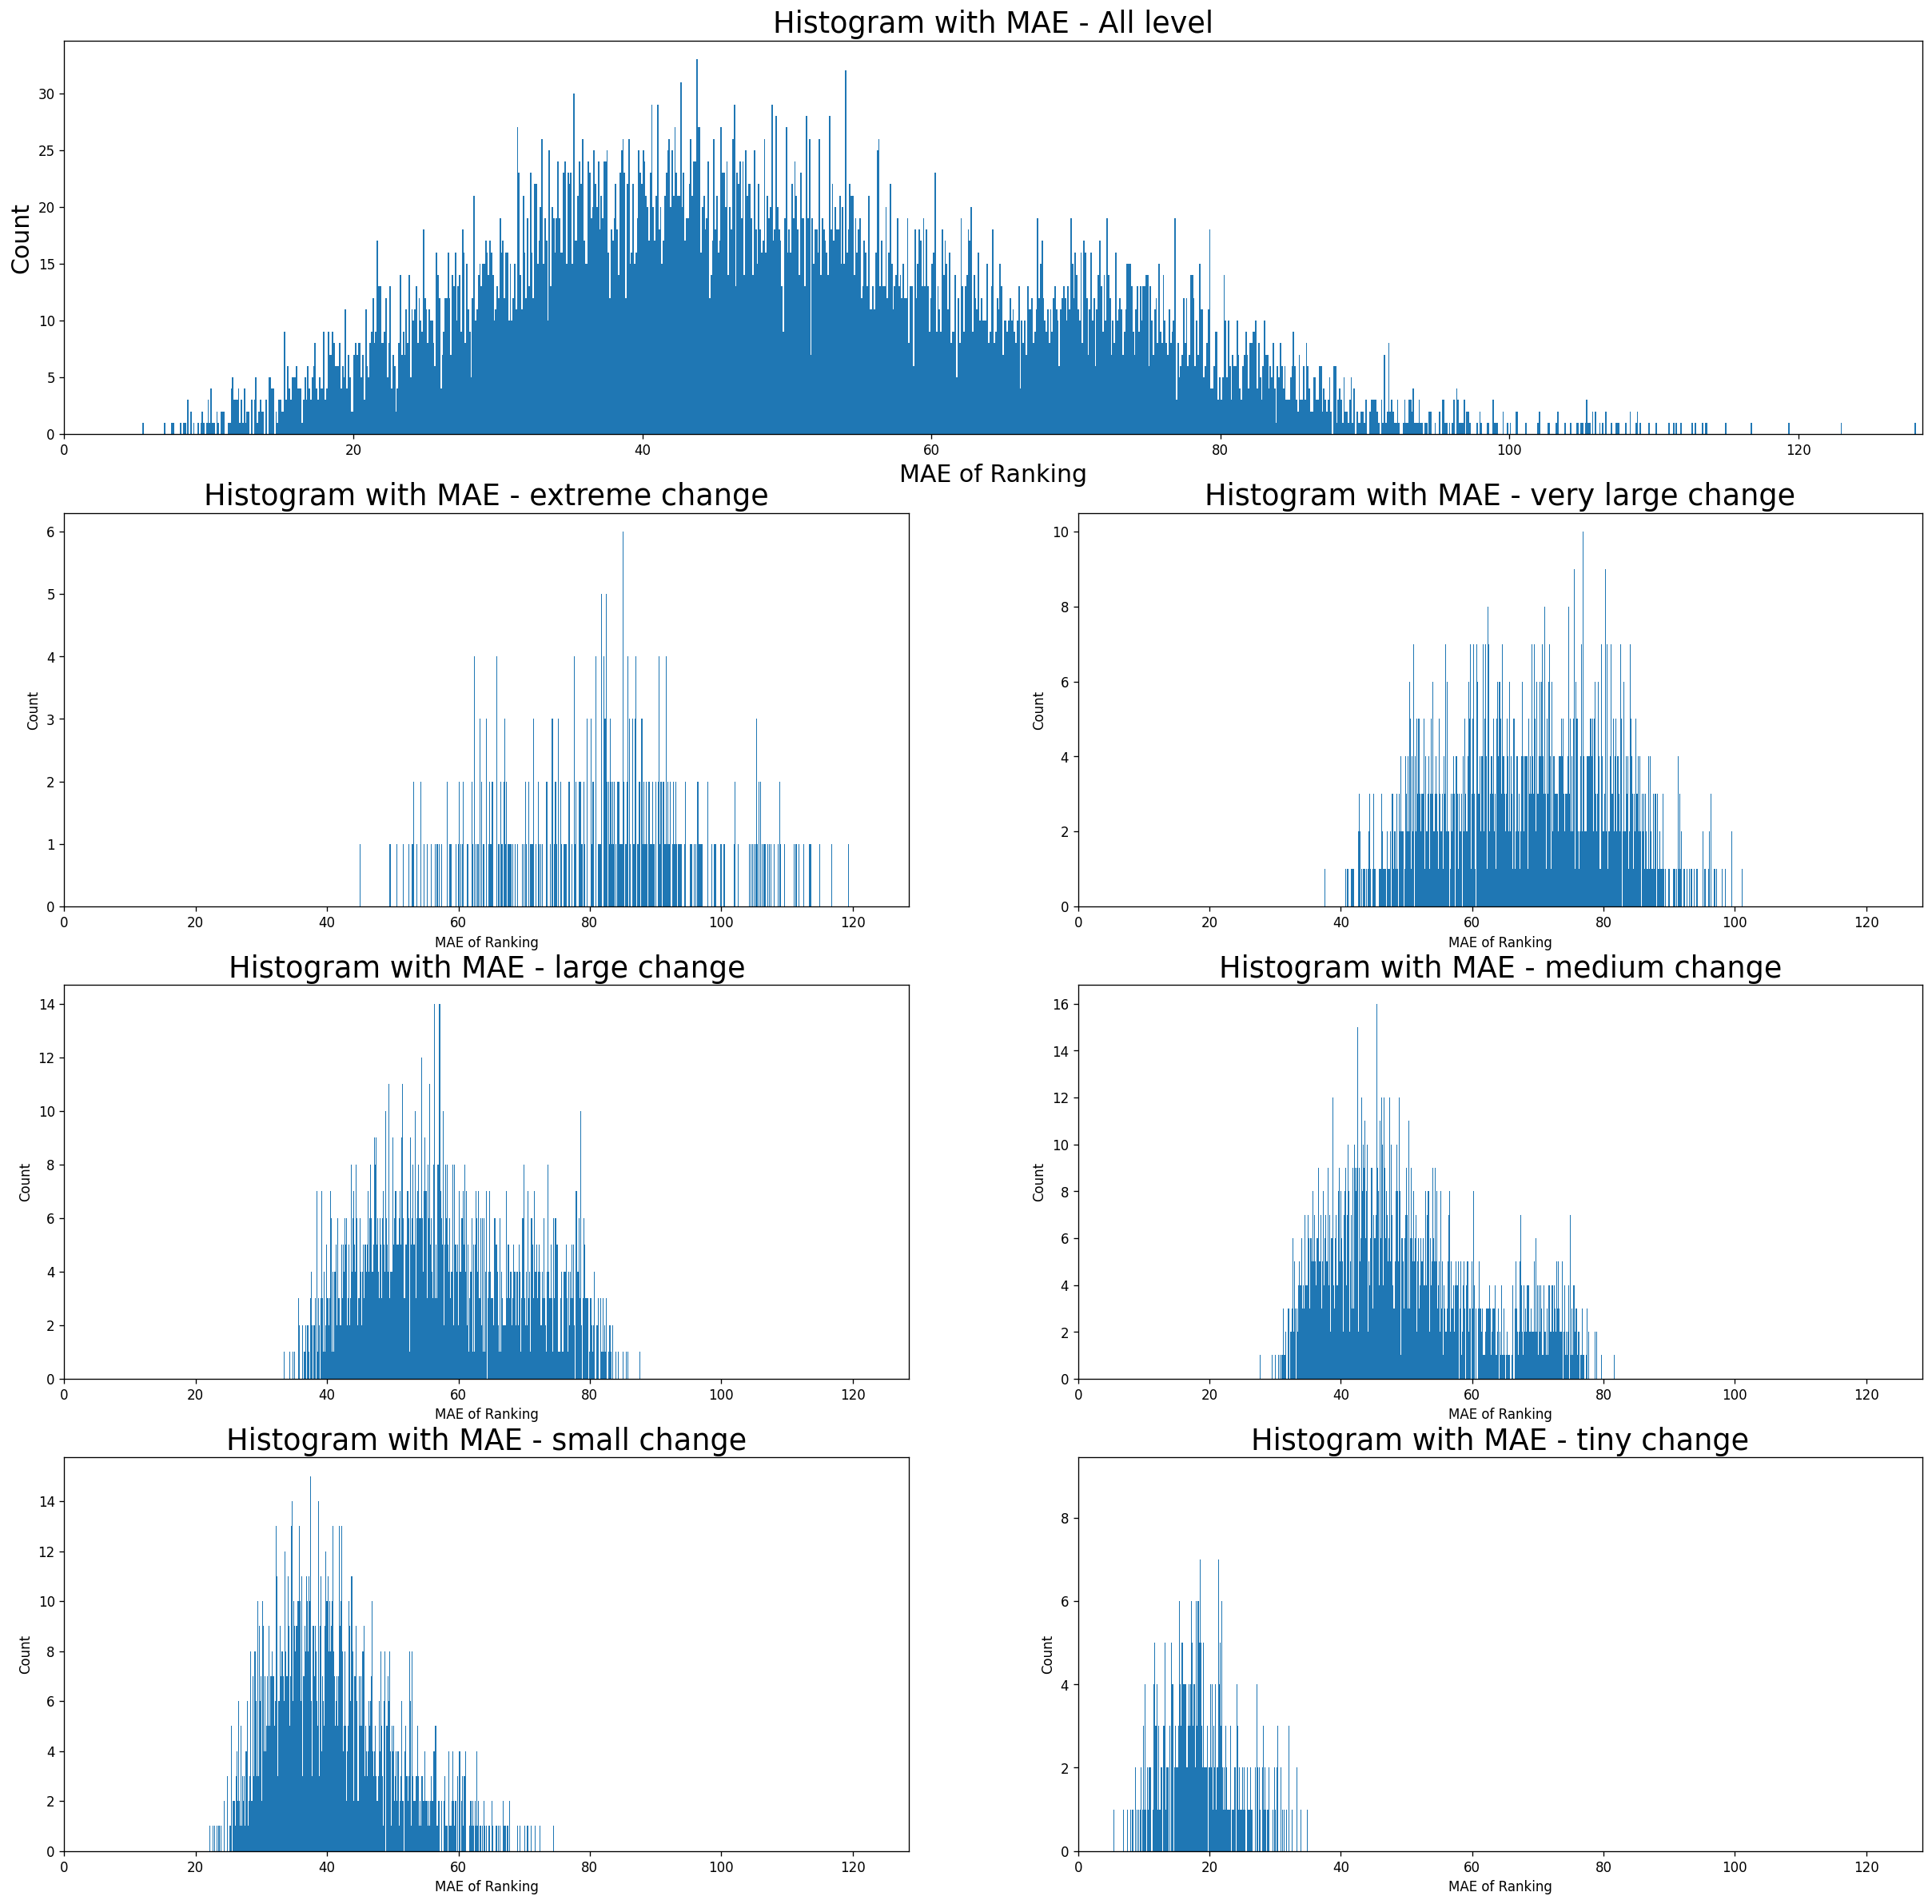

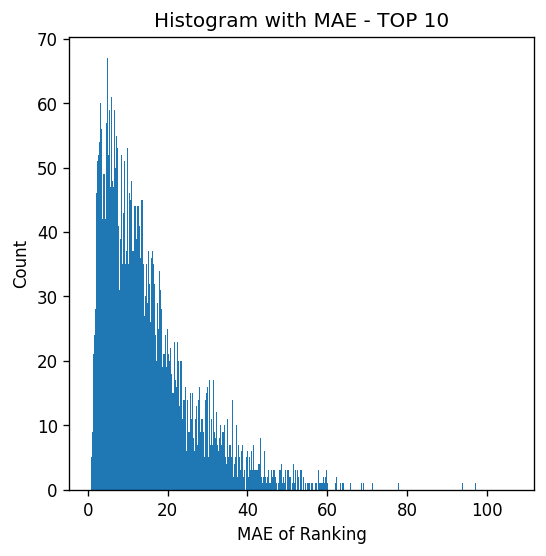

folder name: path_to_1000 sd = 0.003: 
min: 0.0001524928301506745
quantile 5%: 0.0011716059449325762
quantile 20%: 0.0018164598328970307
quantile 40%: 0.002393929776786393
quantile 60%: 0.003000291514696718
quantile 80%: 0.0037958748091354824
quantile 95%: 0.005140049378721166
max: 0.009897351484627675
mean of MAE for Ranking (All level): 3.694234
mean of MAE for Ranking (Extreme change): 7.301232
mean of MAE for Ranking (very large change): 5.518802
mean of MAE for Ranking (large change): 4.340687
mean of MAE for Ranking (medium change): 3.5013095000000005
mean of MAE for Ranking (small change): 2.7862435
mean of MAE for Ranking (tiny change): 1.268442
mean of MAE for Ranking (TOP 10 change): 0.4611800000000001
 
mode of MAE for Ranking (All level): [(2.632, 10)]
mode of MAE for Ranking (Extreme change): [(6.7, 2)]
mode of MAE for Ranking (very large change): [(4.752, 4)]
mode of MAE for Ranking (large change): [(3.782, 5)]
mode of MAE for Ranking (medium change): [(2.772, 5)]
mode of

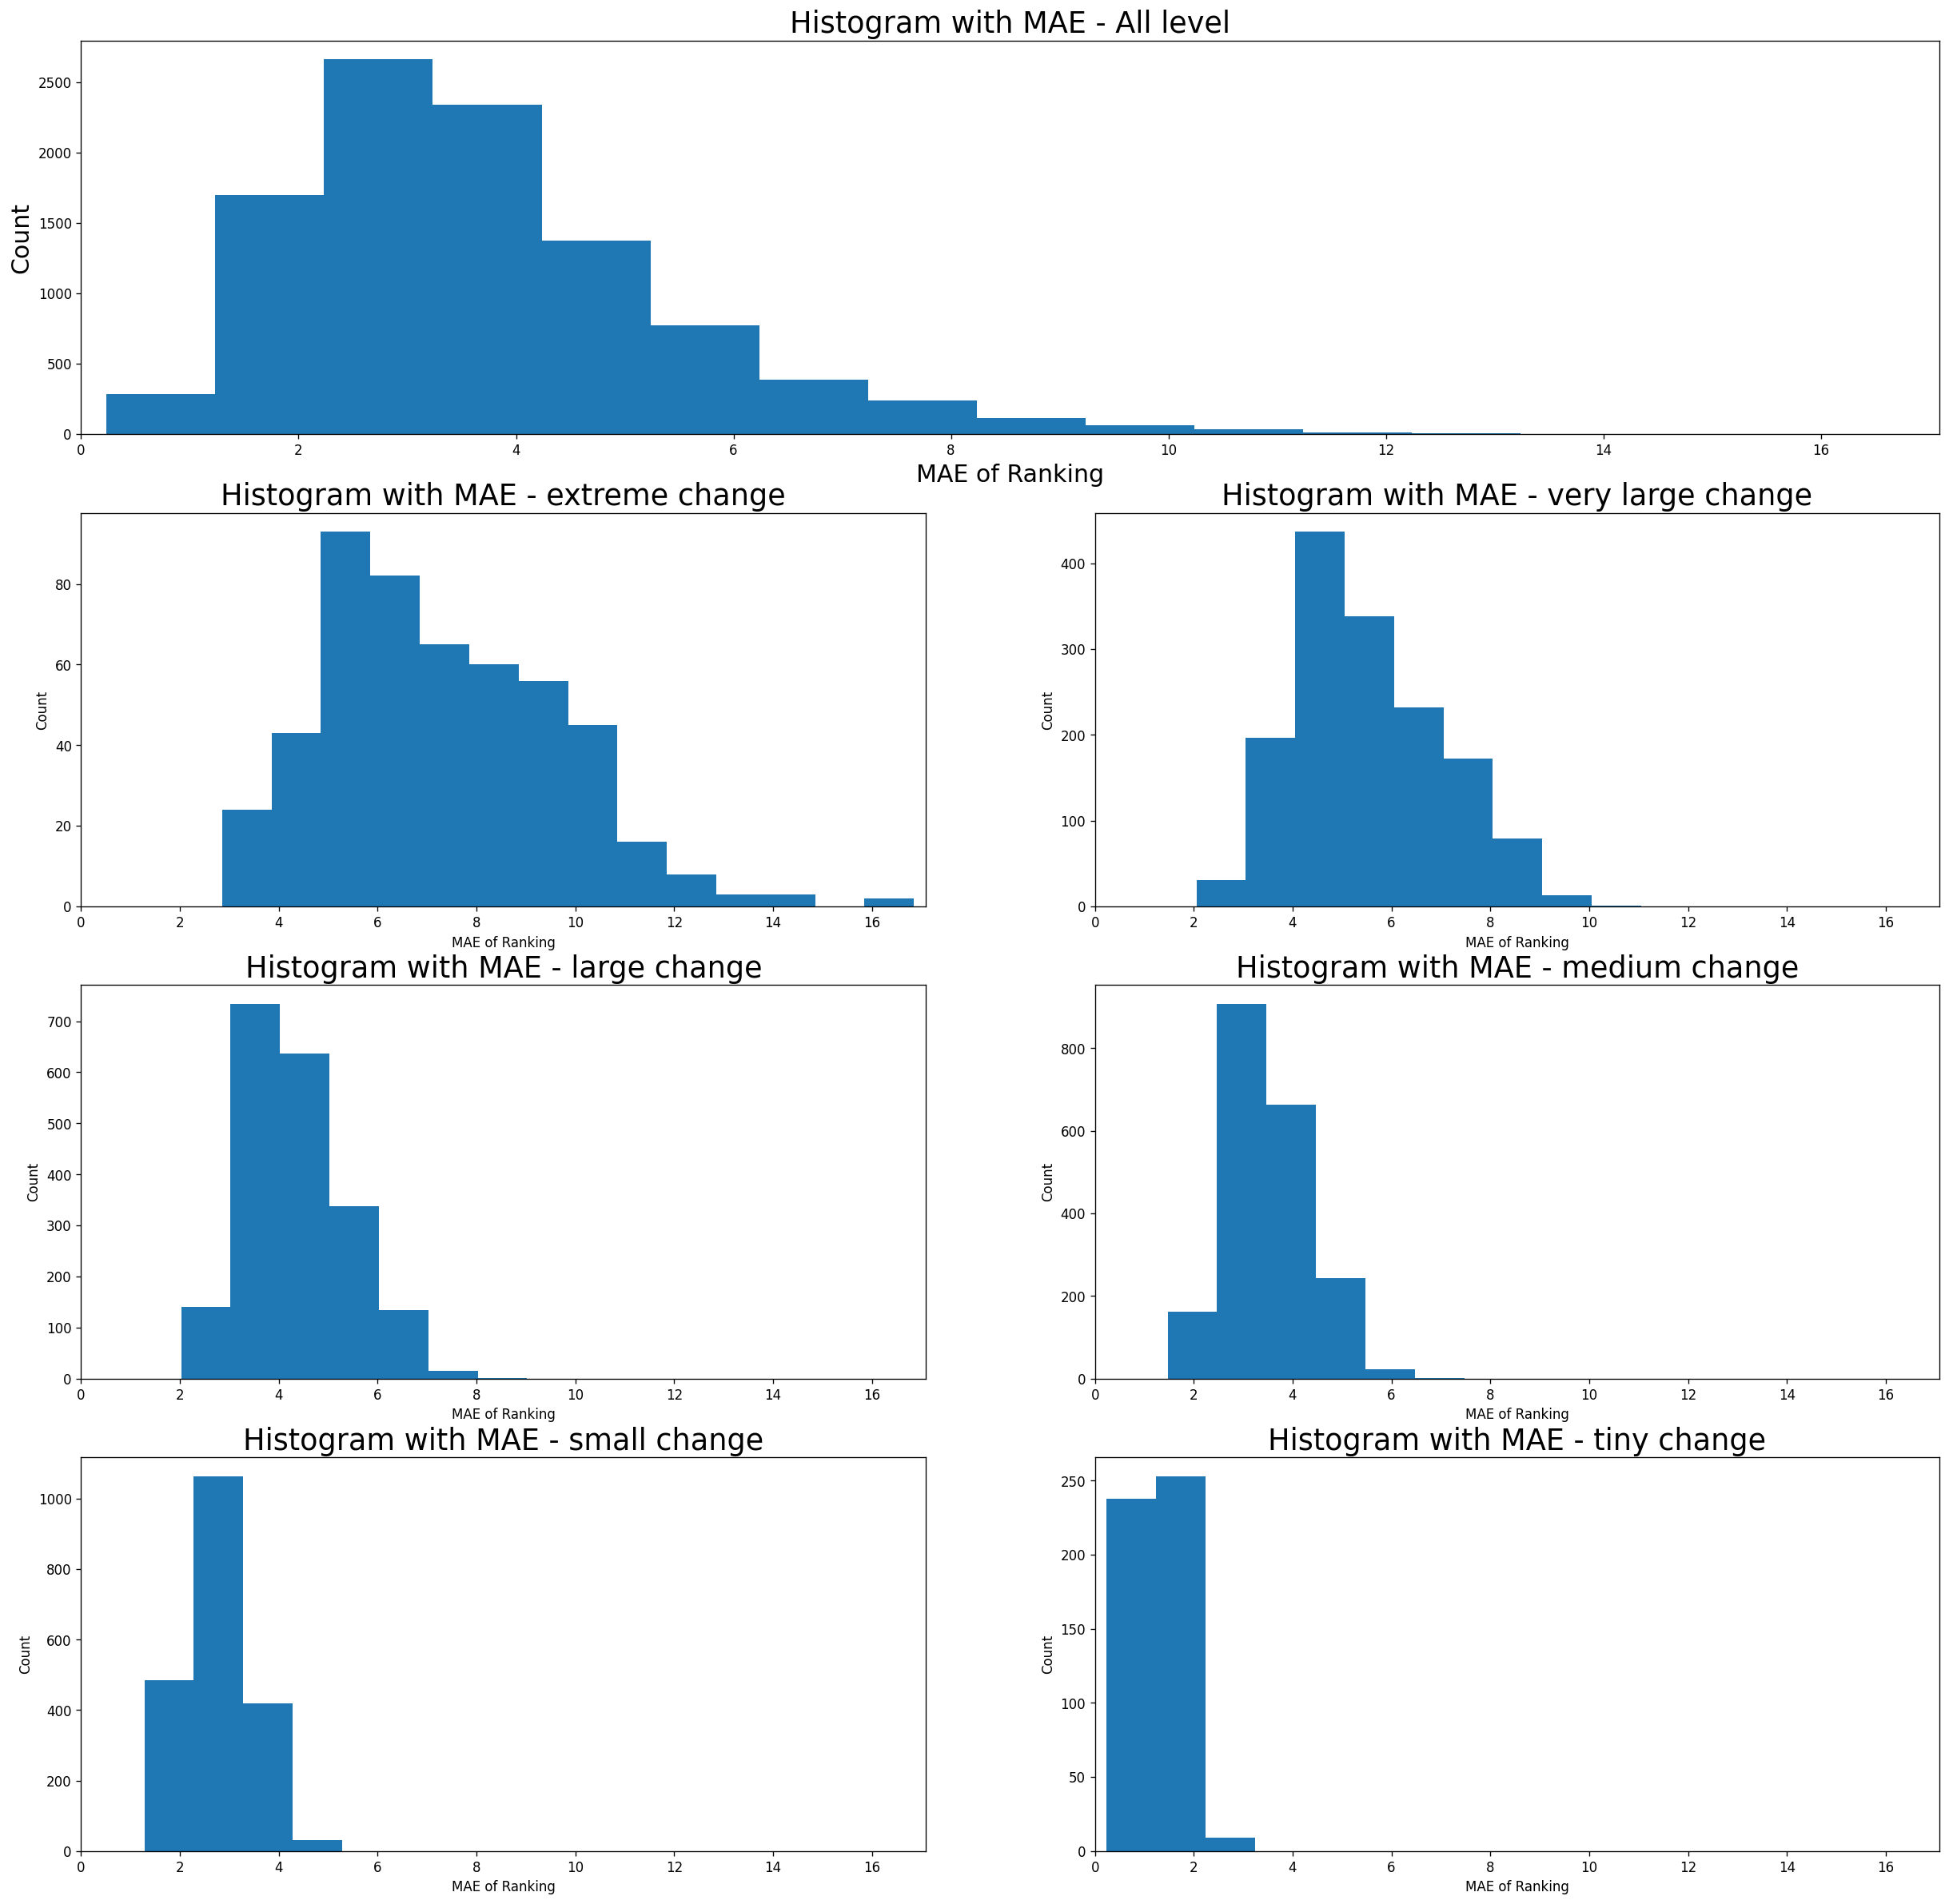

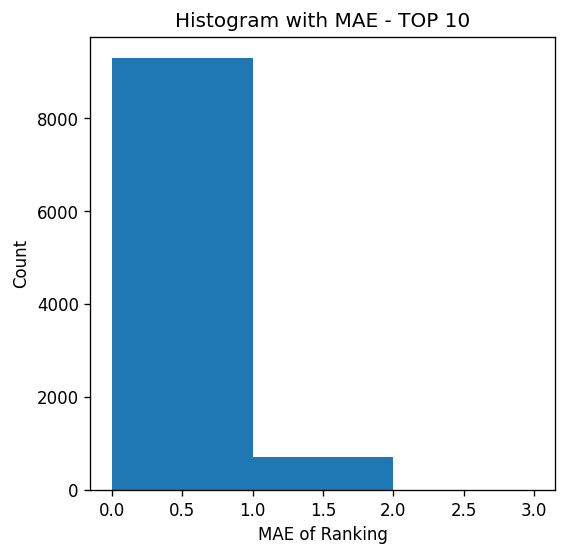

folder name: path_to_1000 sd = 0.02: 
min: 0.0015043611454063632
quantile 5%: 0.00786435740345137
quantile 20%: 0.012279951582558186
quantile 40%: 0.01618412123405032
quantile 60%: 0.020180554201565882
quantile 80%: 0.02562451400622524
quantile 95%: 0.03447541450609455
max: 0.07022635011425953
mean of MAE for Ranking (All level): 23.5869033
mean of MAE for Ranking (Extreme change): 49.183665999999995
mean of MAE for Ranking (very large change): 35.631415999999994
mean of MAE for Ranking (large change): 27.5687535
mean of MAE for Ranking (medium change): 22.1737805
mean of MAE for Ranking (small change): 17.545454
mean of MAE for Ranking (tiny change): 7.7958359999999995
mean of MAE for Ranking (TOP 10 change): 2.4901699999999996
 
mode of MAE for Ranking (All level): [(20.799, 4)]
mode of MAE for Ranking (Extreme change): [(36.405, 2)]
mode of MAE for Ranking (very large change): [(25.148, 3)]
mode of MAE for Ranking (large change): [(20.781, 3)]
mode of MAE for Ranking (medium change)

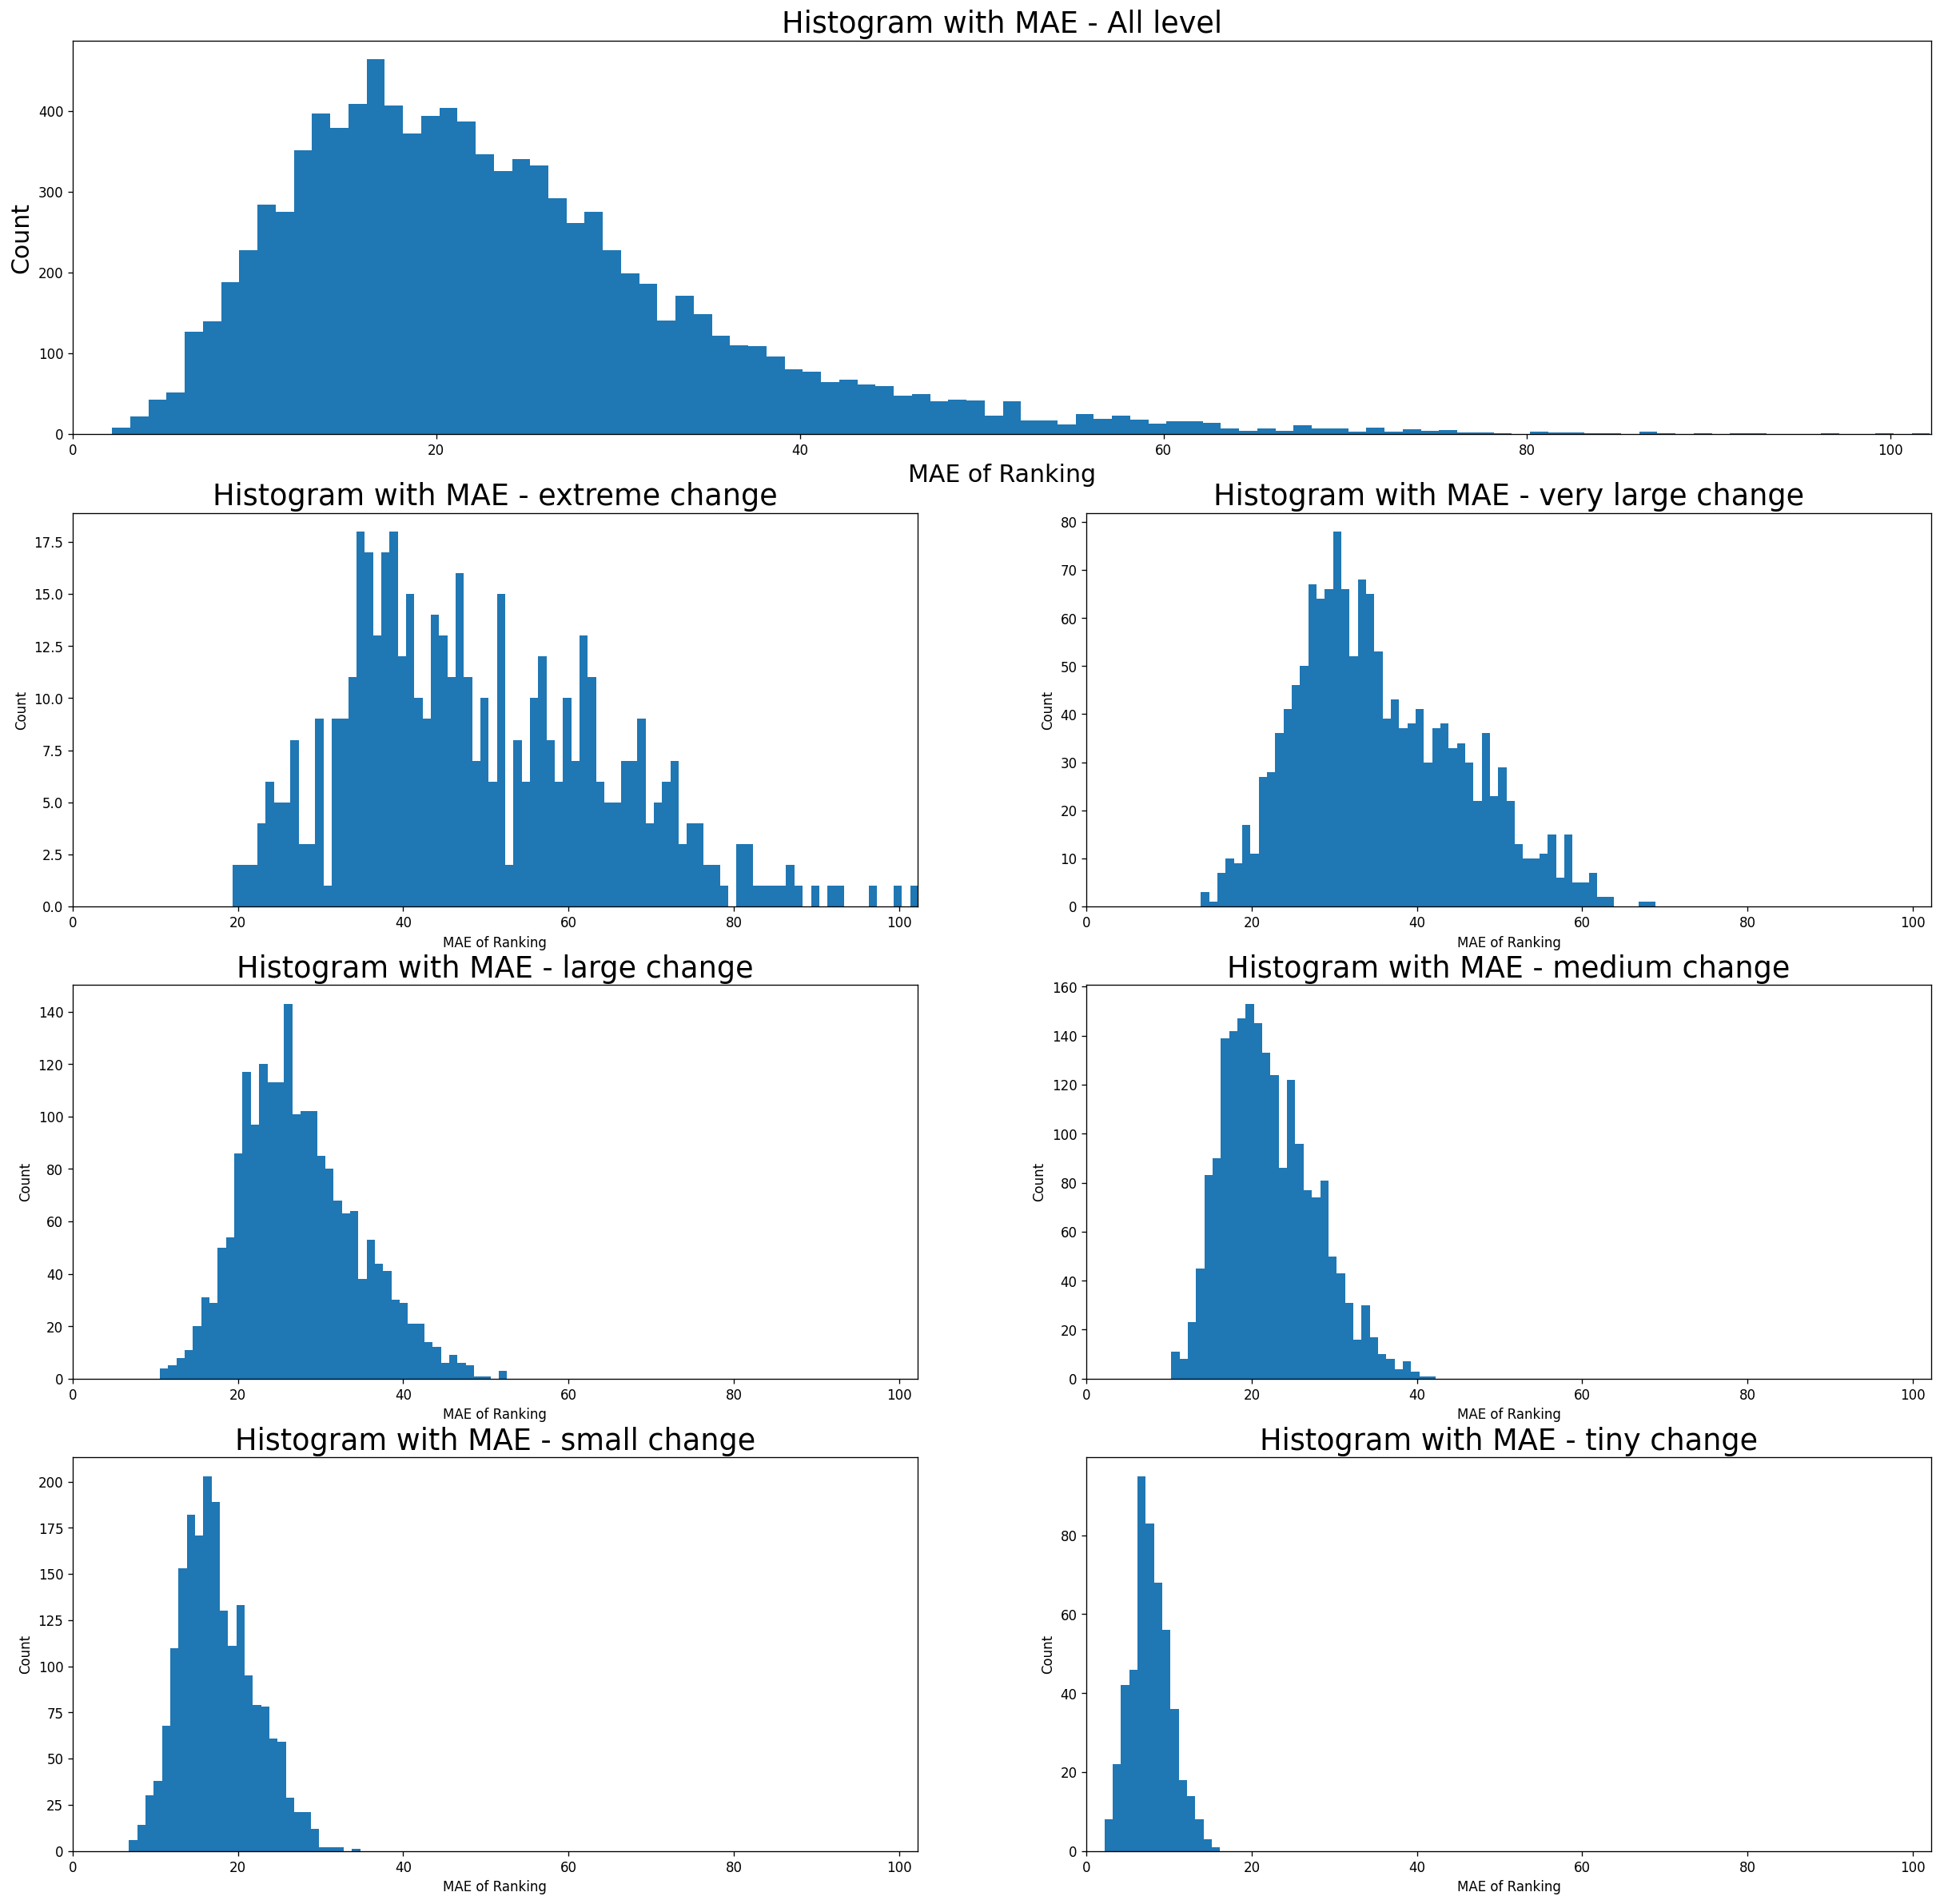

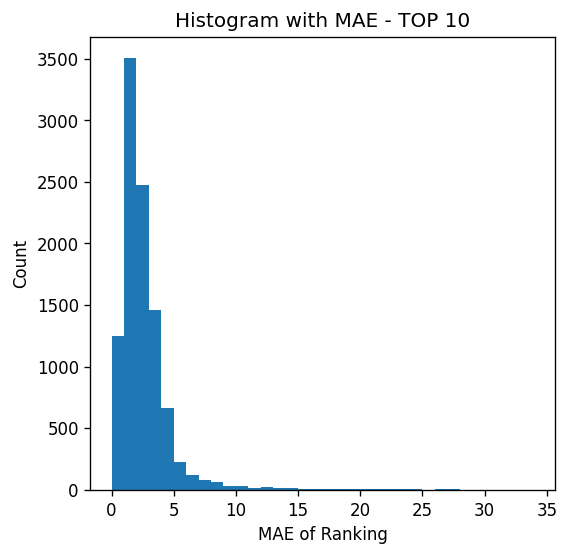

folder name: path_to_1000 sd = 0.1: 
min: 0.00936792010029482
quantile 5%: 0.039670440957966846
quantile 20%: 0.06112081685277997
quantile 40%: 0.07999999999999999
quantile 60%: 0.09604012942773568
quantile 80%: 0.11810763212347114
quantile 95%: 0.15575081630825285
max: 0.28518998558634845
mean of MAE for Ranking (All level): 99.91316640000001
mean of MAE for Ranking (Extreme change): 161.153276
mean of MAE for Ranking (very large change): 136.792544
mean of MAE for Ranking (large change): 117.07131450000001
mean of MAE for Ranking (medium change): 100.88278547050218
mean of MAE for Ranking (small change): 82.60823191380196
mean of MAE for Ranking (tiny change): 37.055167999999995
mean of MAE for Ranking (TOP 10 change): 30.280205
 
mode of MAE for Ranking (All level): [(86.61, 3)]
mode of MAE for Ranking (Extreme change): [(159.325, 2)]
mode of MAE for Ranking (very large change): [(126.895, 2)]
mode of MAE for Ranking (large change): [(124.446, 2)]
mode of MAE for Ranking (medium cha

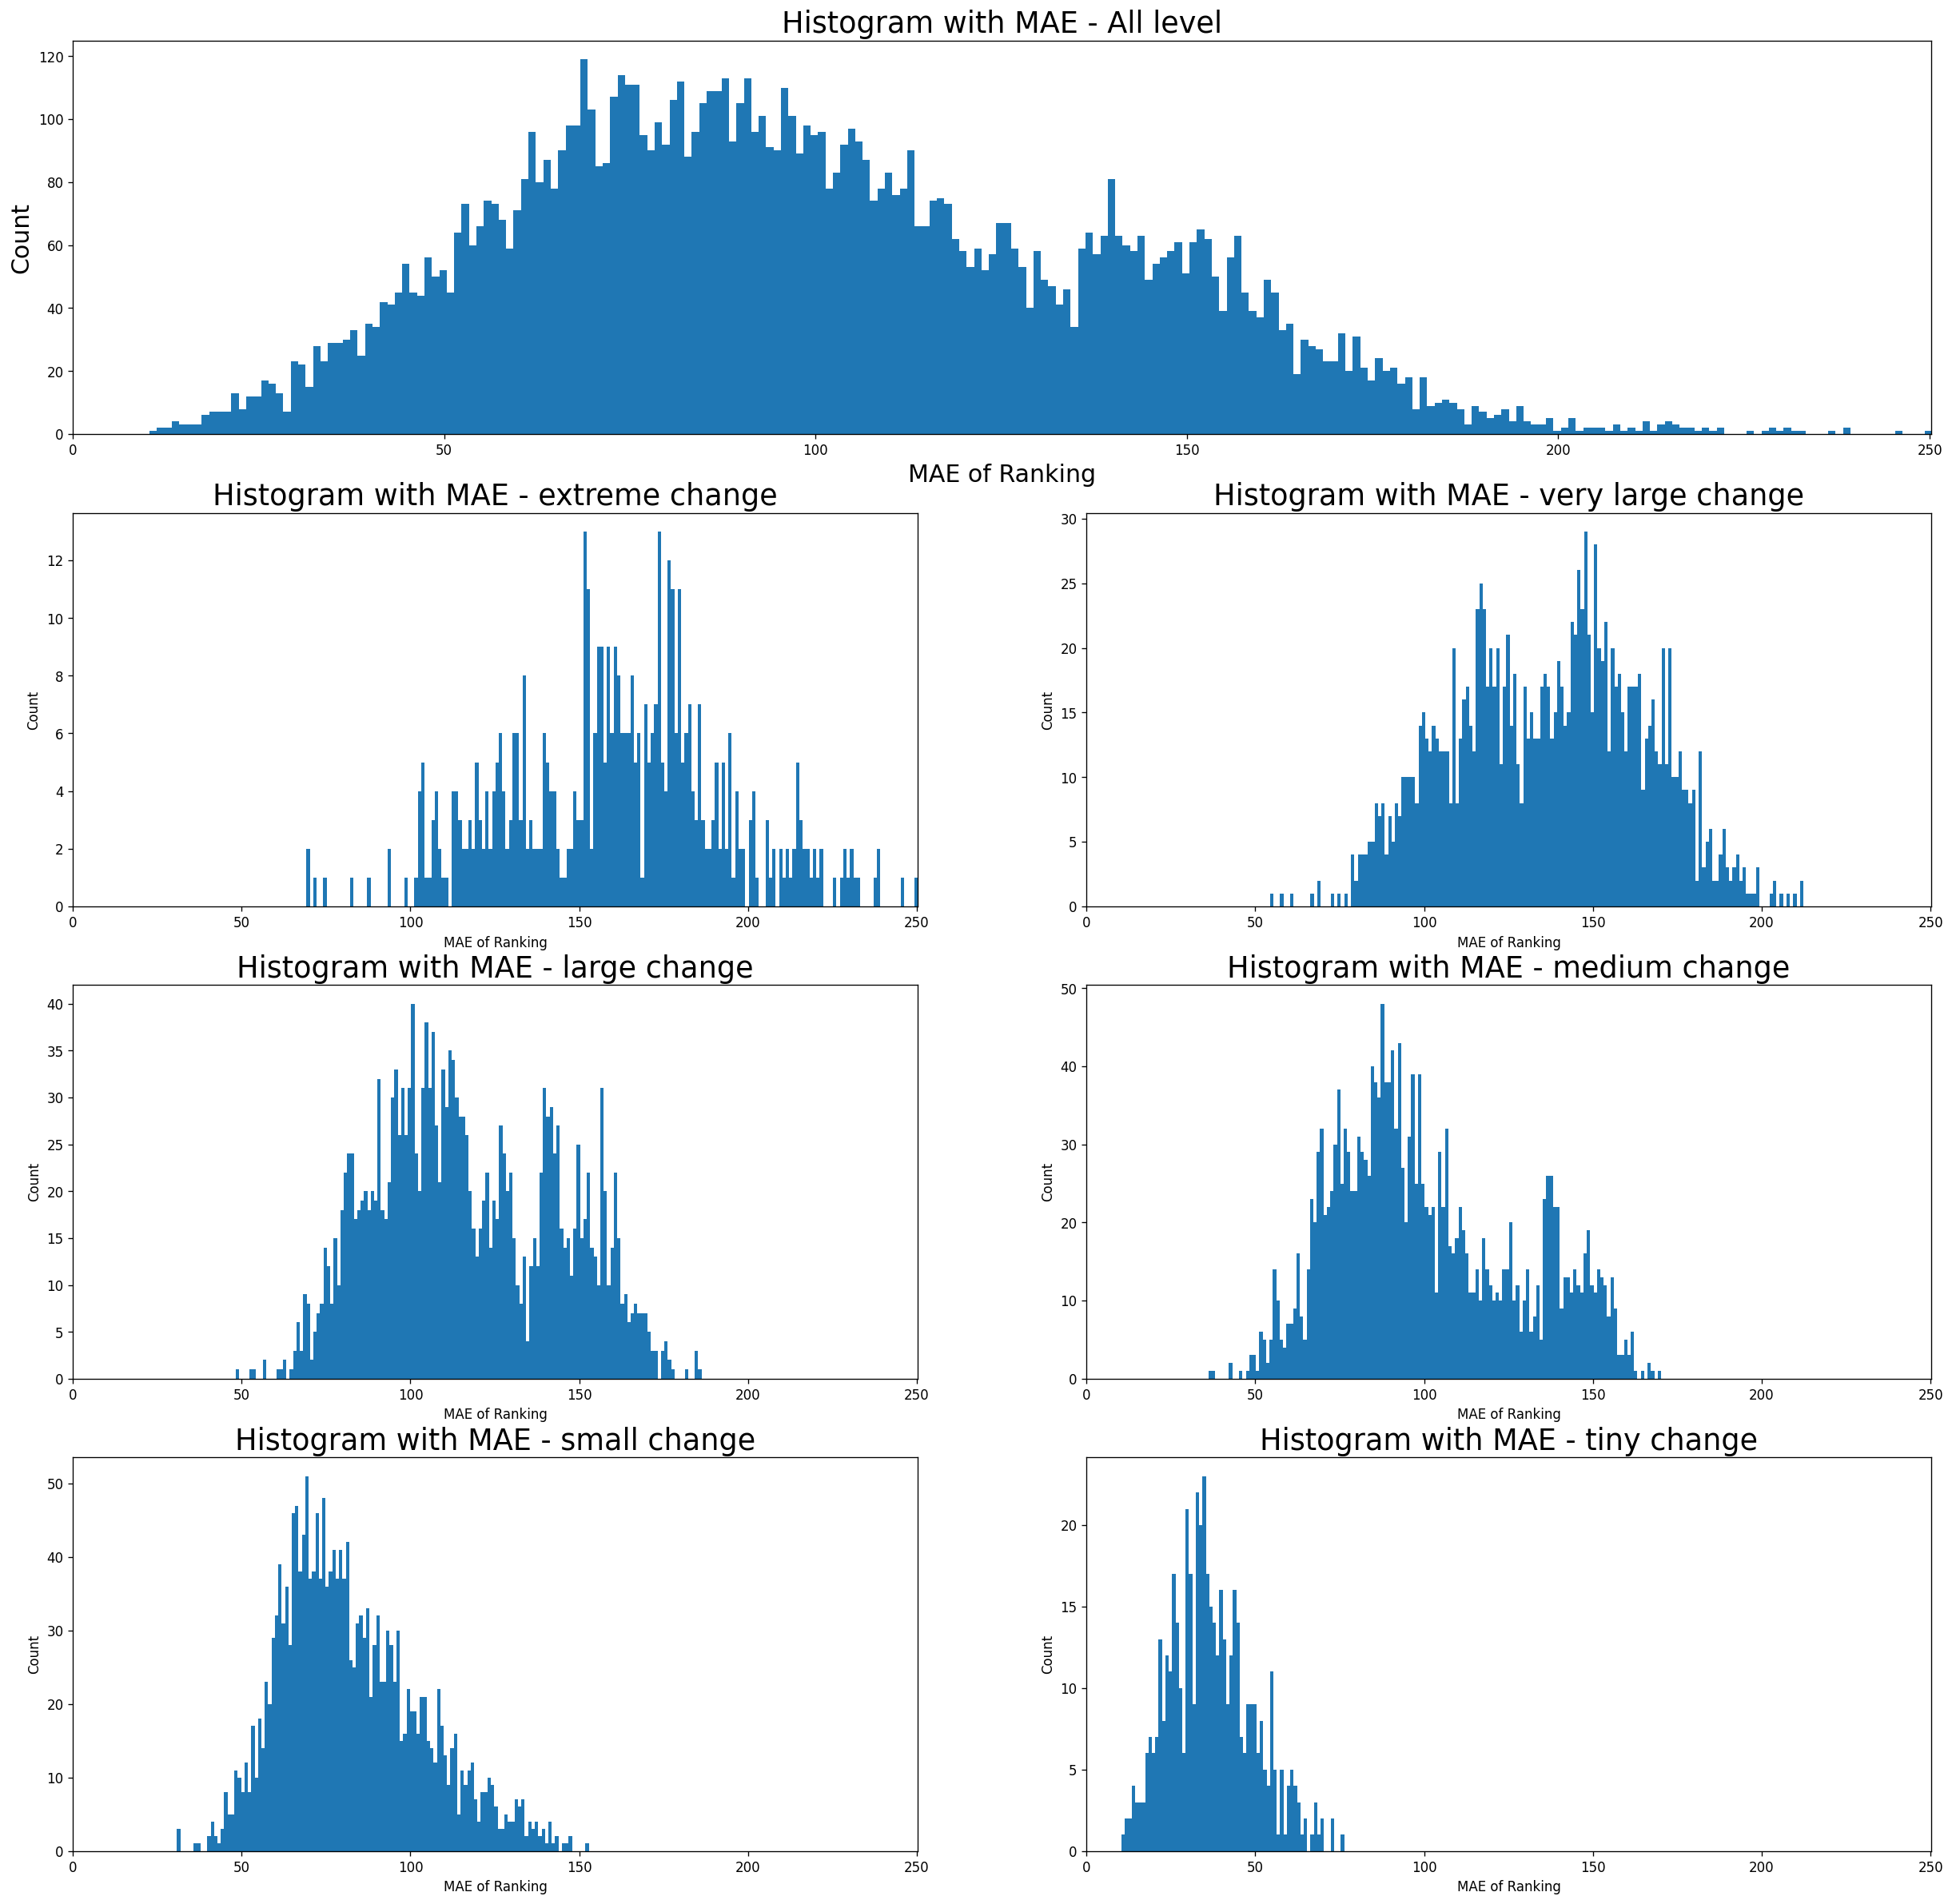

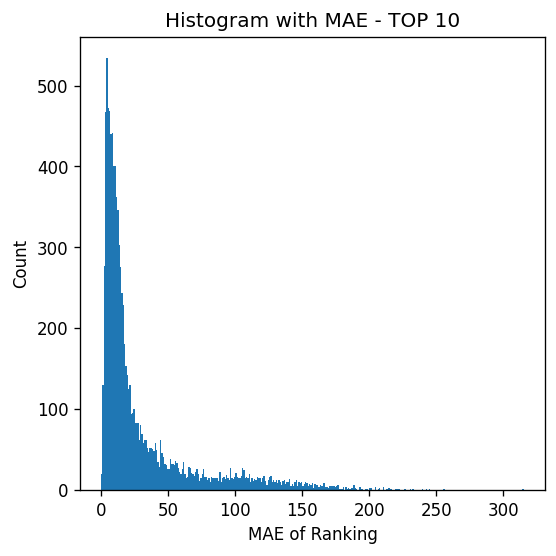

In [ ]:
num = -1
for i in data_set_list:
    num = num + 1
    for j in np.arange(0,3):
        print('folder name: ' + data_set_name[num] + ' sd = ' + str(sd_list[j]) + ': ')
        weight_shuffle_first,first_10_MAE_shuffle_first = One_job_analytics(Raw_data = i, Job_id = 456, baseline_weight= [0.2,0.2,0.2,0.2,0.2], sd = sd_list[j], iter_times = 10000,
                            Expert_yrs_set_up = 10, Intermediate_yrs_set_up = 6.5, Beginner_yrs_set_up = 2,
                                proficiency_far_below = 0.6, proficiency_below = 0.8, proficiency_meets = 1, proficiency_above = 1.1, proficiency_far_above = 1.2,
                                        yrs_exp_function_name = col_sigmoid, last_used_function_name = col_sigmoid, 
                                            yrs_slope = 0.5, yrs_horizontal_shift = 7,
                                                last_slope = -0.8, last_horizontal_shift = 6, bin_length = bin_length_list[num])

## Baseline is [0.2018,0.3028,0.1014,0.1821,0.2119]

folder name: path_to_data_folder sd = 0.003: 
min: 0.00018579539070437135
quantile 5%: 0.0011855373643362354
quantile 20%: 0.001818690446353172
quantile 40%: 0.0024254388365306766
quantile 60%: 0.003021338901548775
quantile 80%: 0.0038557567275314007
quantile 95%: 0.005159395549429767
max: 0.009767042327309402
mean of MAE for Ranking (All level): 0.3002037735849057
mean of MAE for Ranking (Extreme change): 0.5884528301886793
mean of MAE for Ranking (very large change): 0.45235220125786163
mean of MAE for Ranking (large change): 0.36186792452830185
mean of MAE for Ranking (medium change): 0.28656603773584904
mean of MAE for Ranking (small change): 0.22620754716981128
mean of MAE for Ranking (tiny change): 0.08649056603773585
mean of MAE for Ranking (TOP 10 change): 0.31981000000000004
 
mode of MAE for Ranking (All level): [(0.22641509433962265, 1027)]
mode of MAE for Ranking (Extreme change): [(0.5283018867924528, 56)]
mode of MAE for Ranking (very large change): [(0.41509433962264153,

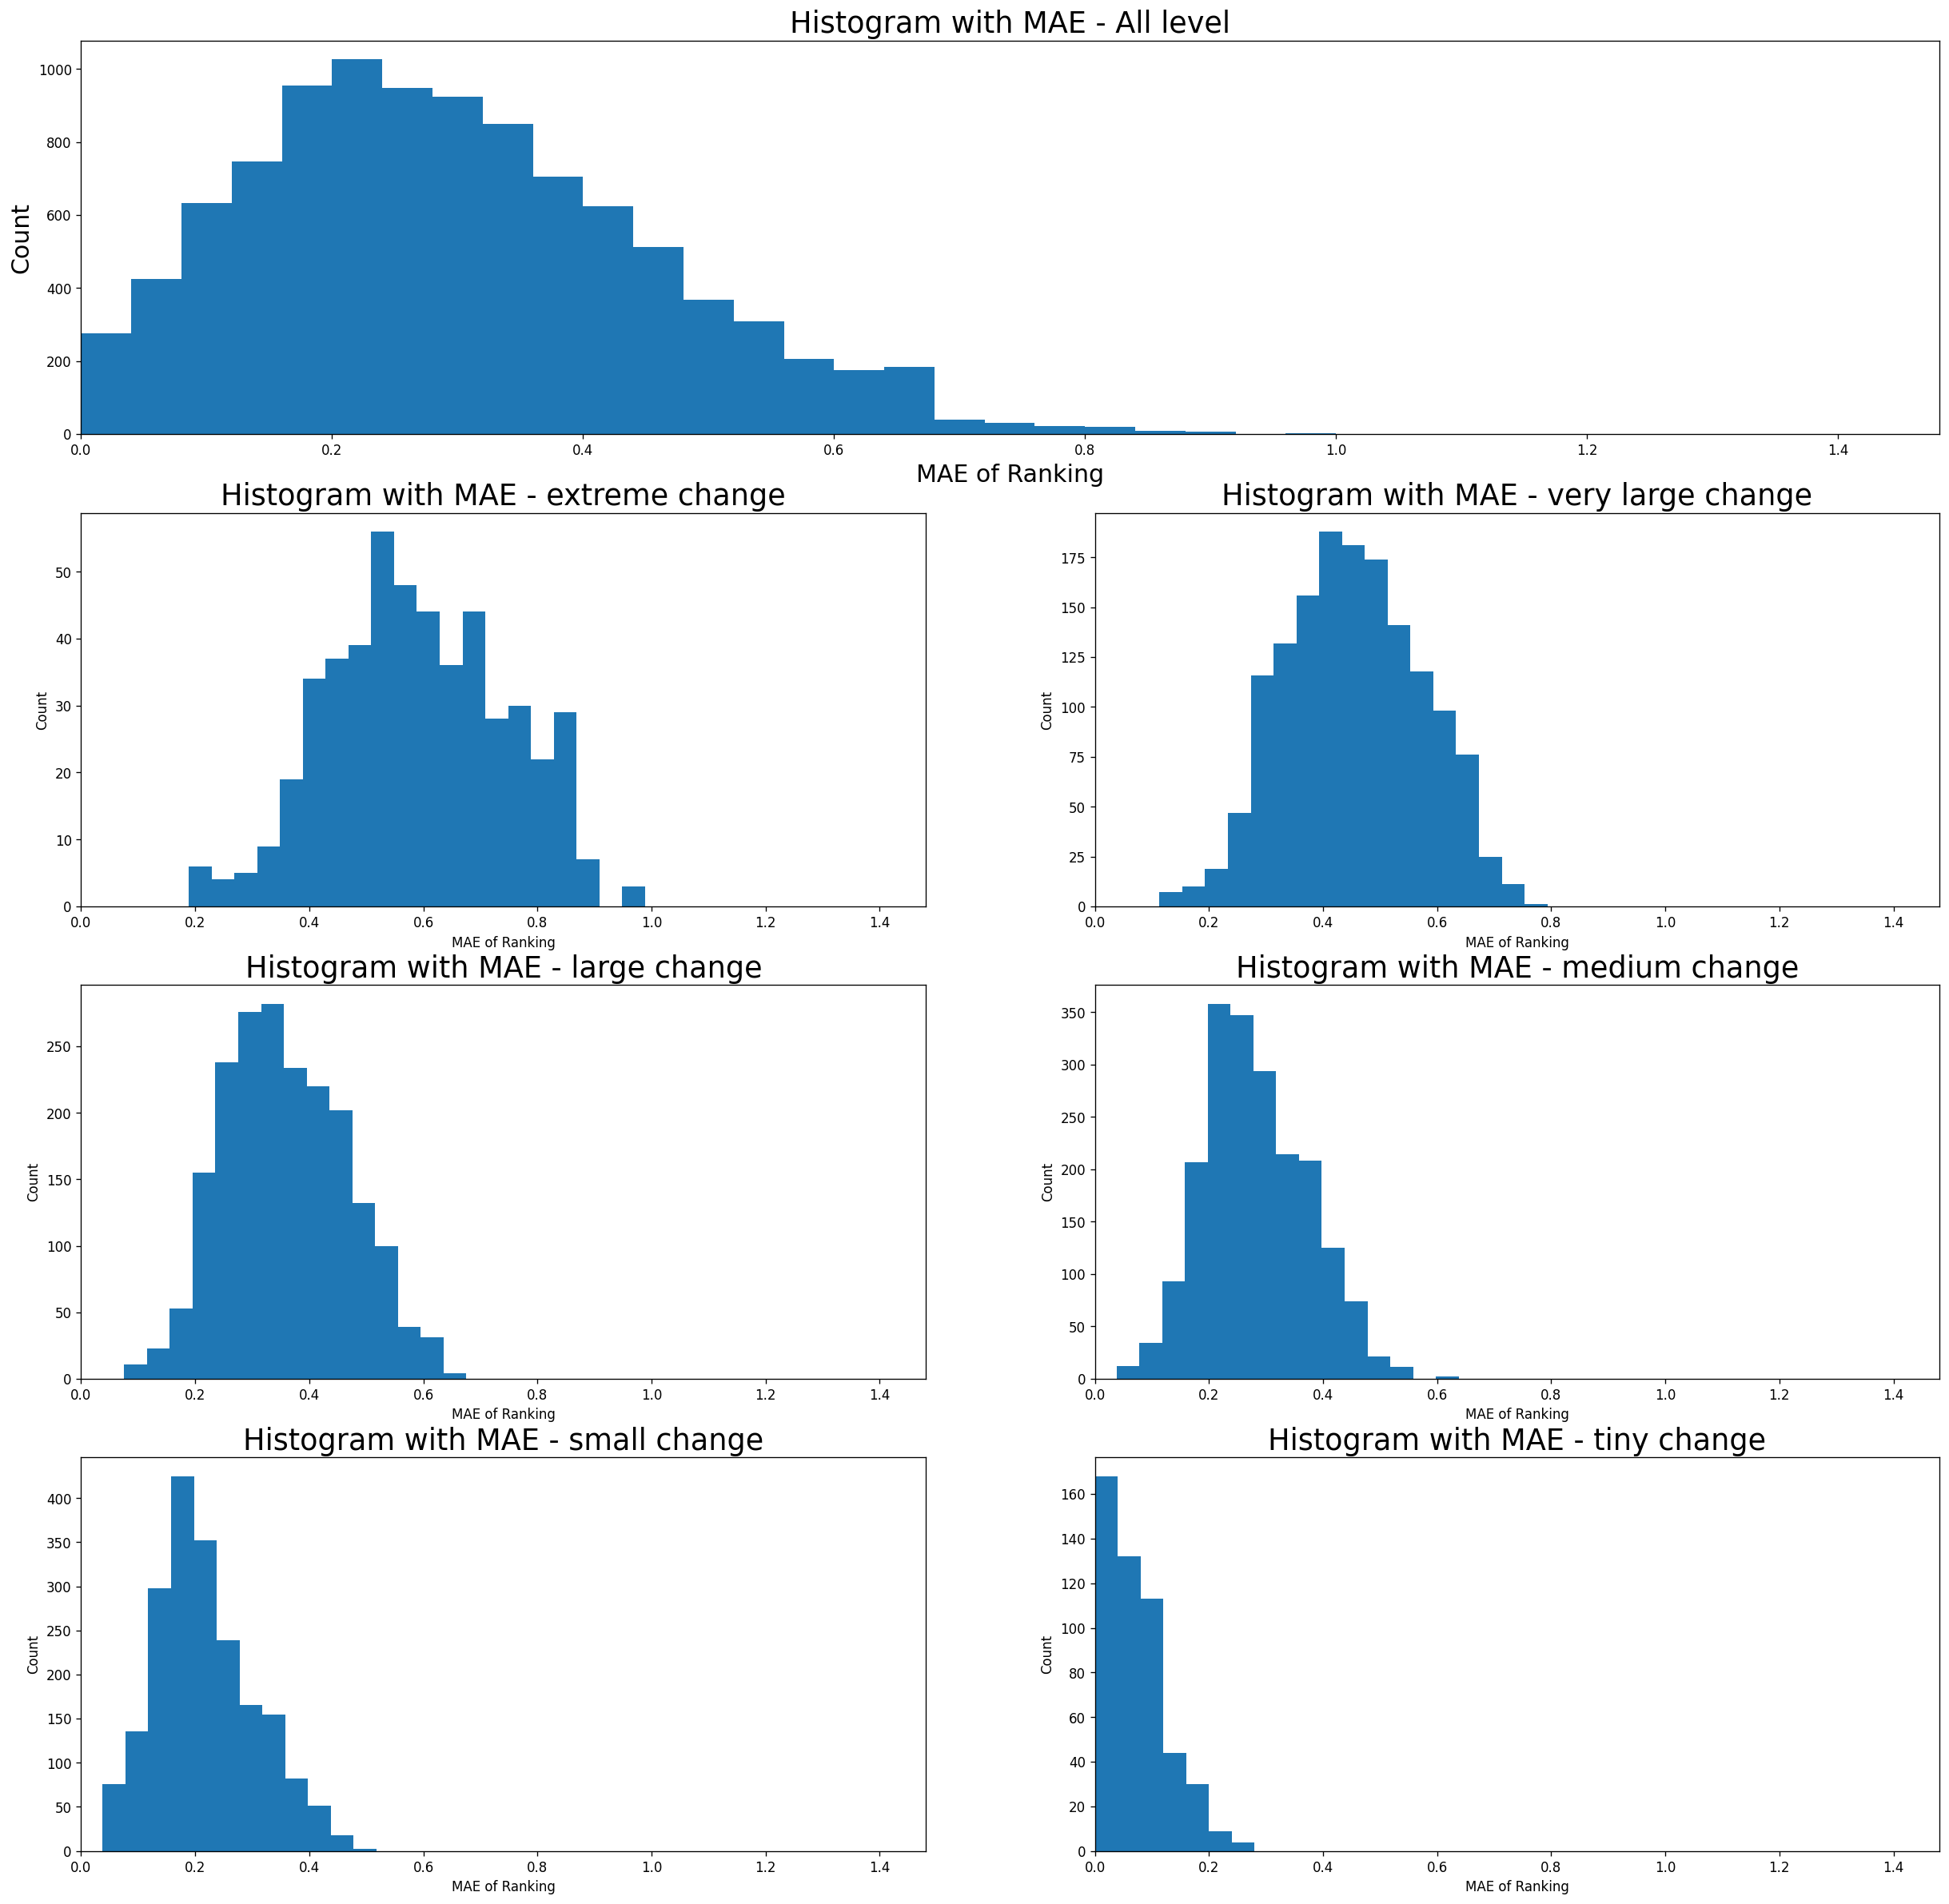

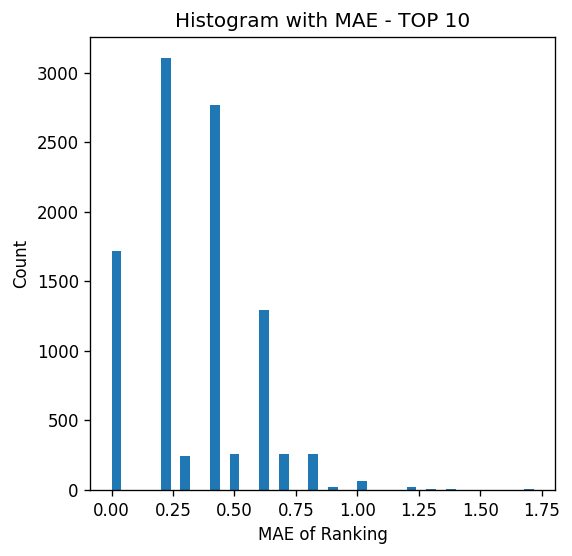

folder name: path_to_data_folder sd = 0.02: 
min: 0.0015630382764688616
quantile 5%: 0.00781067392409426
quantile 20%: 0.012135707205801288
quantile 40%: 0.016114127915700608
quantile 60%: 0.020246737030592765
quantile 80%: 0.025703912732356397
quantile 95%: 0.034428678028242315
max: 0.06193797777647196
mean of MAE for Ranking (All level): 1.671098113207547
mean of MAE for Ranking (Extreme change): 3.284226415094339
mean of MAE for Ranking (very large change): 2.4535849056603776
mean of MAE for Ranking (large change): 1.9546415094339622
mean of MAE for Ranking (medium change): 1.5869245283018867
mean of MAE for Ranking (small change): 1.2750377358490566
mean of MAE for Ranking (tiny change): 0.6321509433962265
mean of MAE for Ranking (TOP 10 change): 1.39786
 
mode of MAE for Ranking (All level): [(1.320754716981132, 263)]
mode of MAE for Ranking (Extreme change): [(3.4716981132075473, 16)]
mode of MAE for Ranking (very large change): [(2.5283018867924527, 58)]
mode of MAE for Ranking 

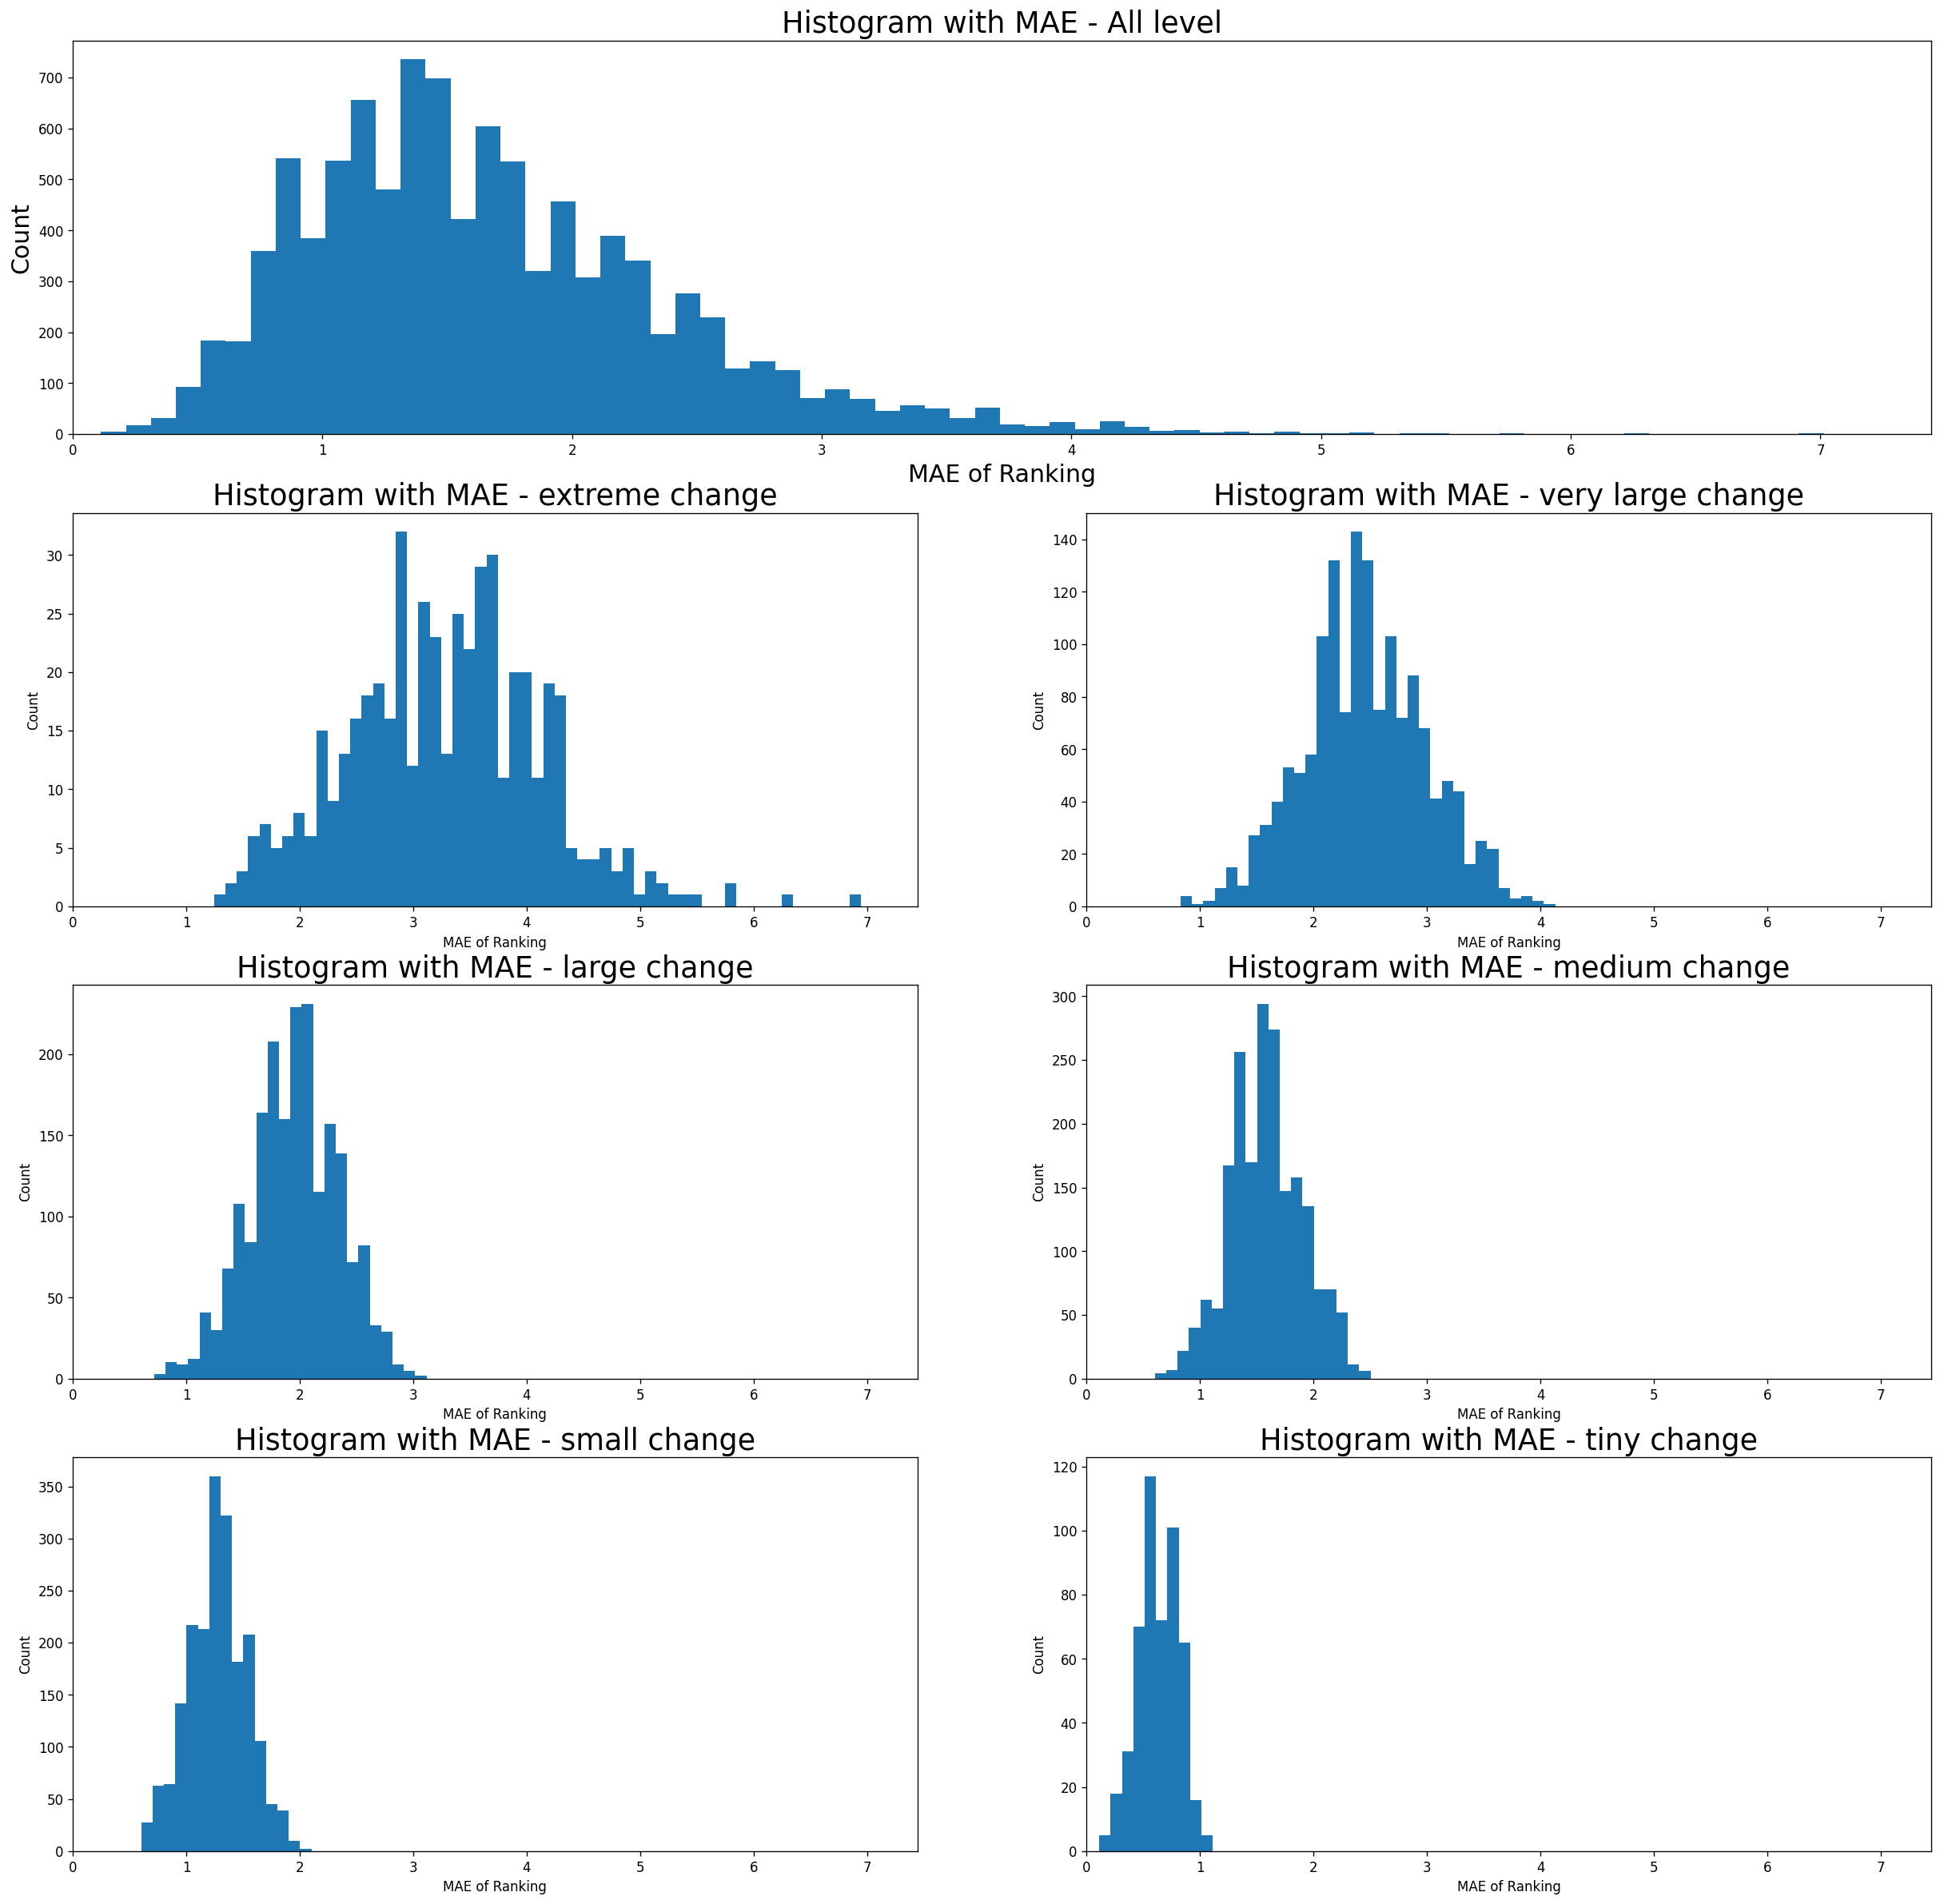

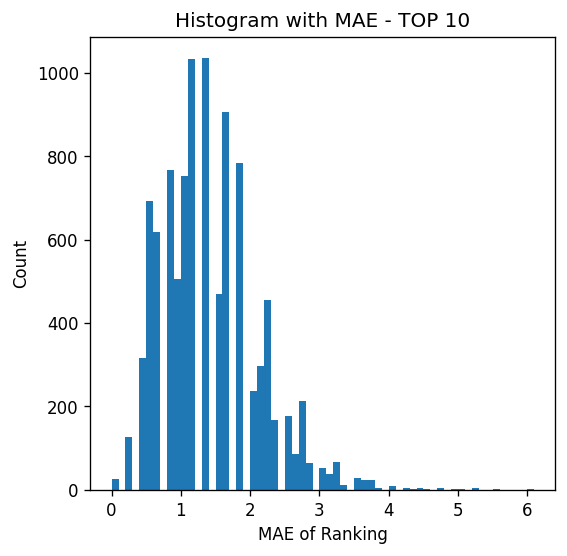

folder name: path_to_data_folder sd = 0.1: 
min: 0.00988829345661201
quantile 5%: 0.03895616428374912
quantile 20%: 0.05886631519582647
quantile 40%: 0.07702159105795862
quantile 60%: 0.09448428255717913
quantile 80%: 0.11688919179604795
quantile 95%: 0.15140005116605632
max: 0.2537370224209778
mean of MAE for Ranking (All level): 6.086
mean of MAE for Ranking (Extreme change): 9.183396226415095
mean of MAE for Ranking (very large change): 7.990037735849056
mean of MAE for Ranking (large change): 7.099811320754717
mean of MAE for Ranking (medium change): 6.106509433962264
mean of MAE for Ranking (small change): 5.264490566037736
mean of MAE for Ranking (tiny change): 2.5139622641509436
mean of MAE for Ranking (TOP 10 change): 5.40283
 
mode of MAE for Ranking (All level): [(6.30188679245283, 91)]
mode of MAE for Ranking (Extreme change): [(8.18867924528302, 10)]
mode of MAE for Ranking (very large change): [(7.433962264150943, 27)]
mode of MAE for Ranking (large change): [(6.3018867924

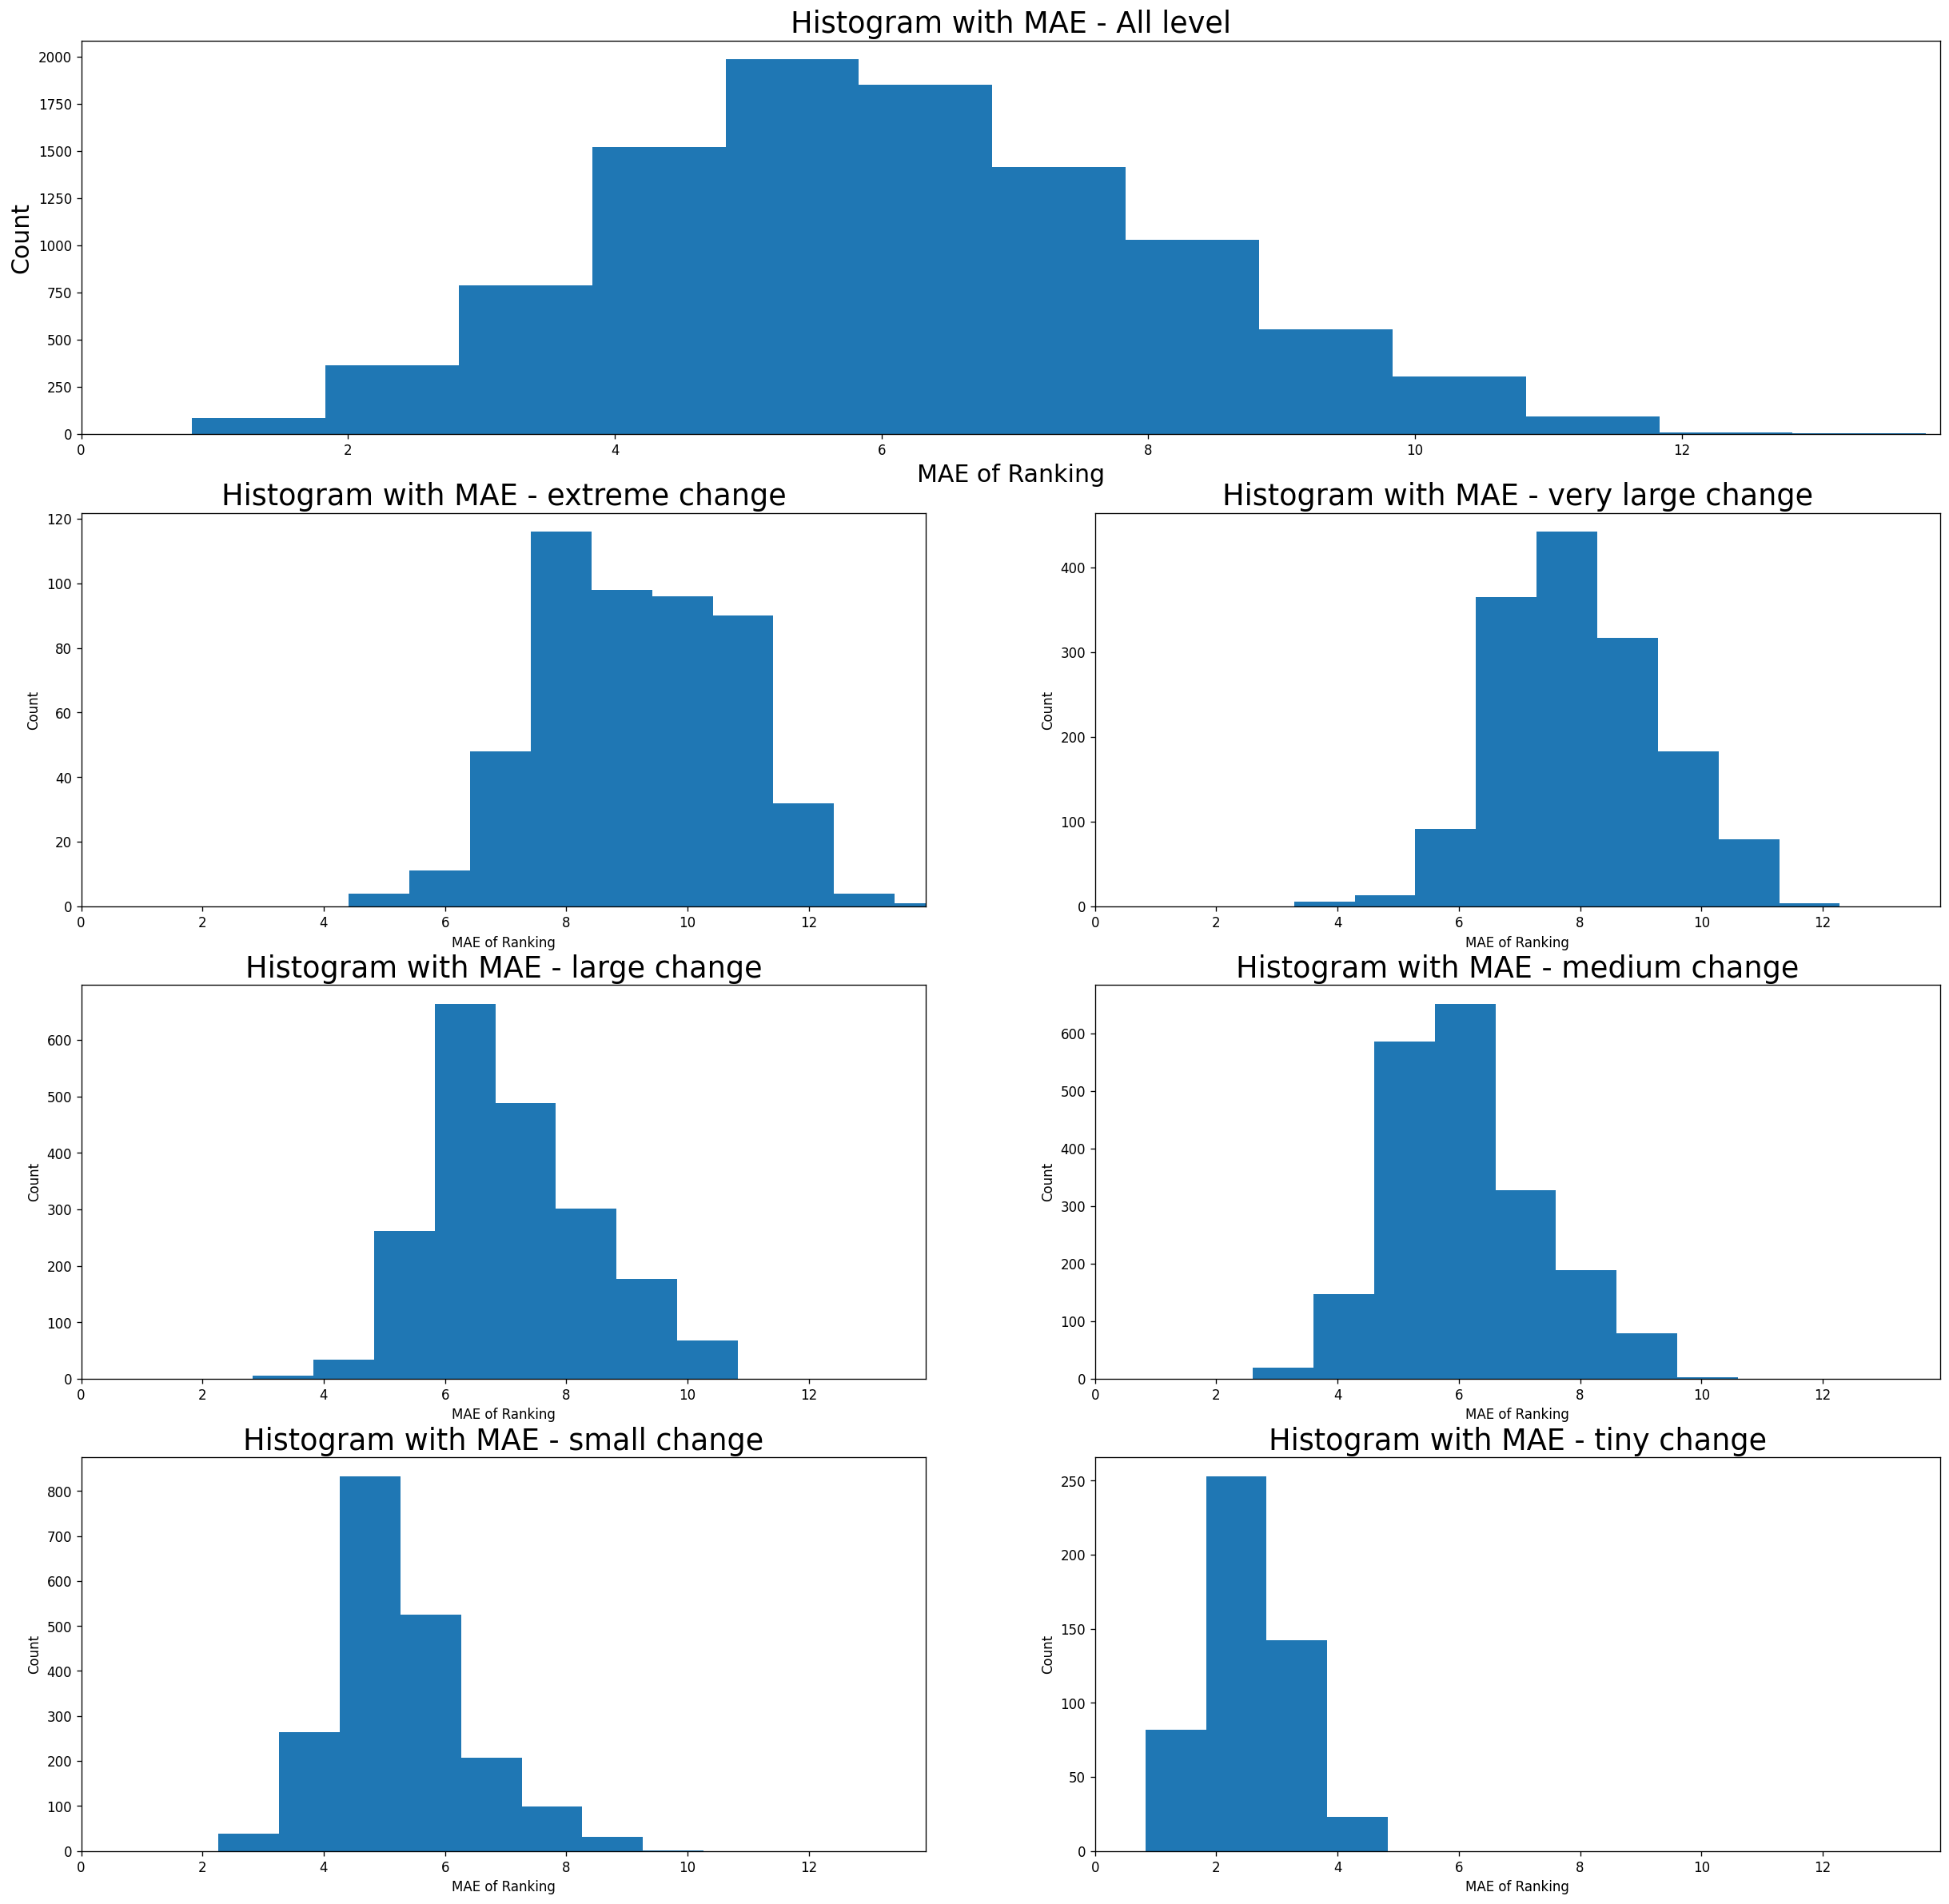

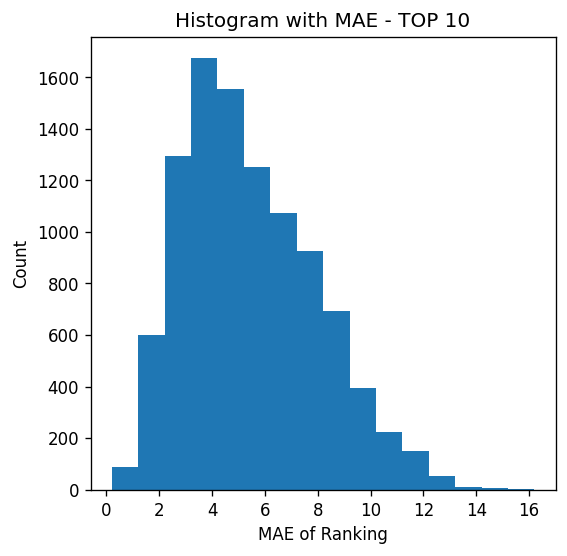

folder name: path_to_500 sd = 0.003: 
min: 0.0003080914178033939
quantile 5%: 0.001189209602562115
quantile 20%: 0.0018371883515474357
quantile 40%: 0.0024165262730573784
quantile 60%: 0.003019158305442123
quantile 80%: 0.0038355398245548183
quantile 95%: 0.005136279862498444
max: 0.01020299239790338
mean of MAE for Ranking (All level): 2.1418544
mean of MAE for Ranking (Extreme change): 4.286256000000001
mean of MAE for Ranking (very large change): 3.1923199999999996
mean of MAE for Ranking (large change): 2.502152
mean of MAE for Ranking (medium change): 2.0173959999999997
mean of MAE for Ranking (small change): 1.6225120000000002
mean of MAE for Ranking (tiny change): 0.749248
mean of MAE for Ranking (TOP 10 change): 0.23348000000000002
 
mode of MAE for Ranking (All level): [(1.676, 38)]
mode of MAE for Ranking (Extreme change): [(3.32, 4)]
mode of MAE for Ranking (very large change): [(2.808, 9)]
mode of MAE for Ranking (large change): [(2.008, 14)]
mode of MAE for Ranking (medium

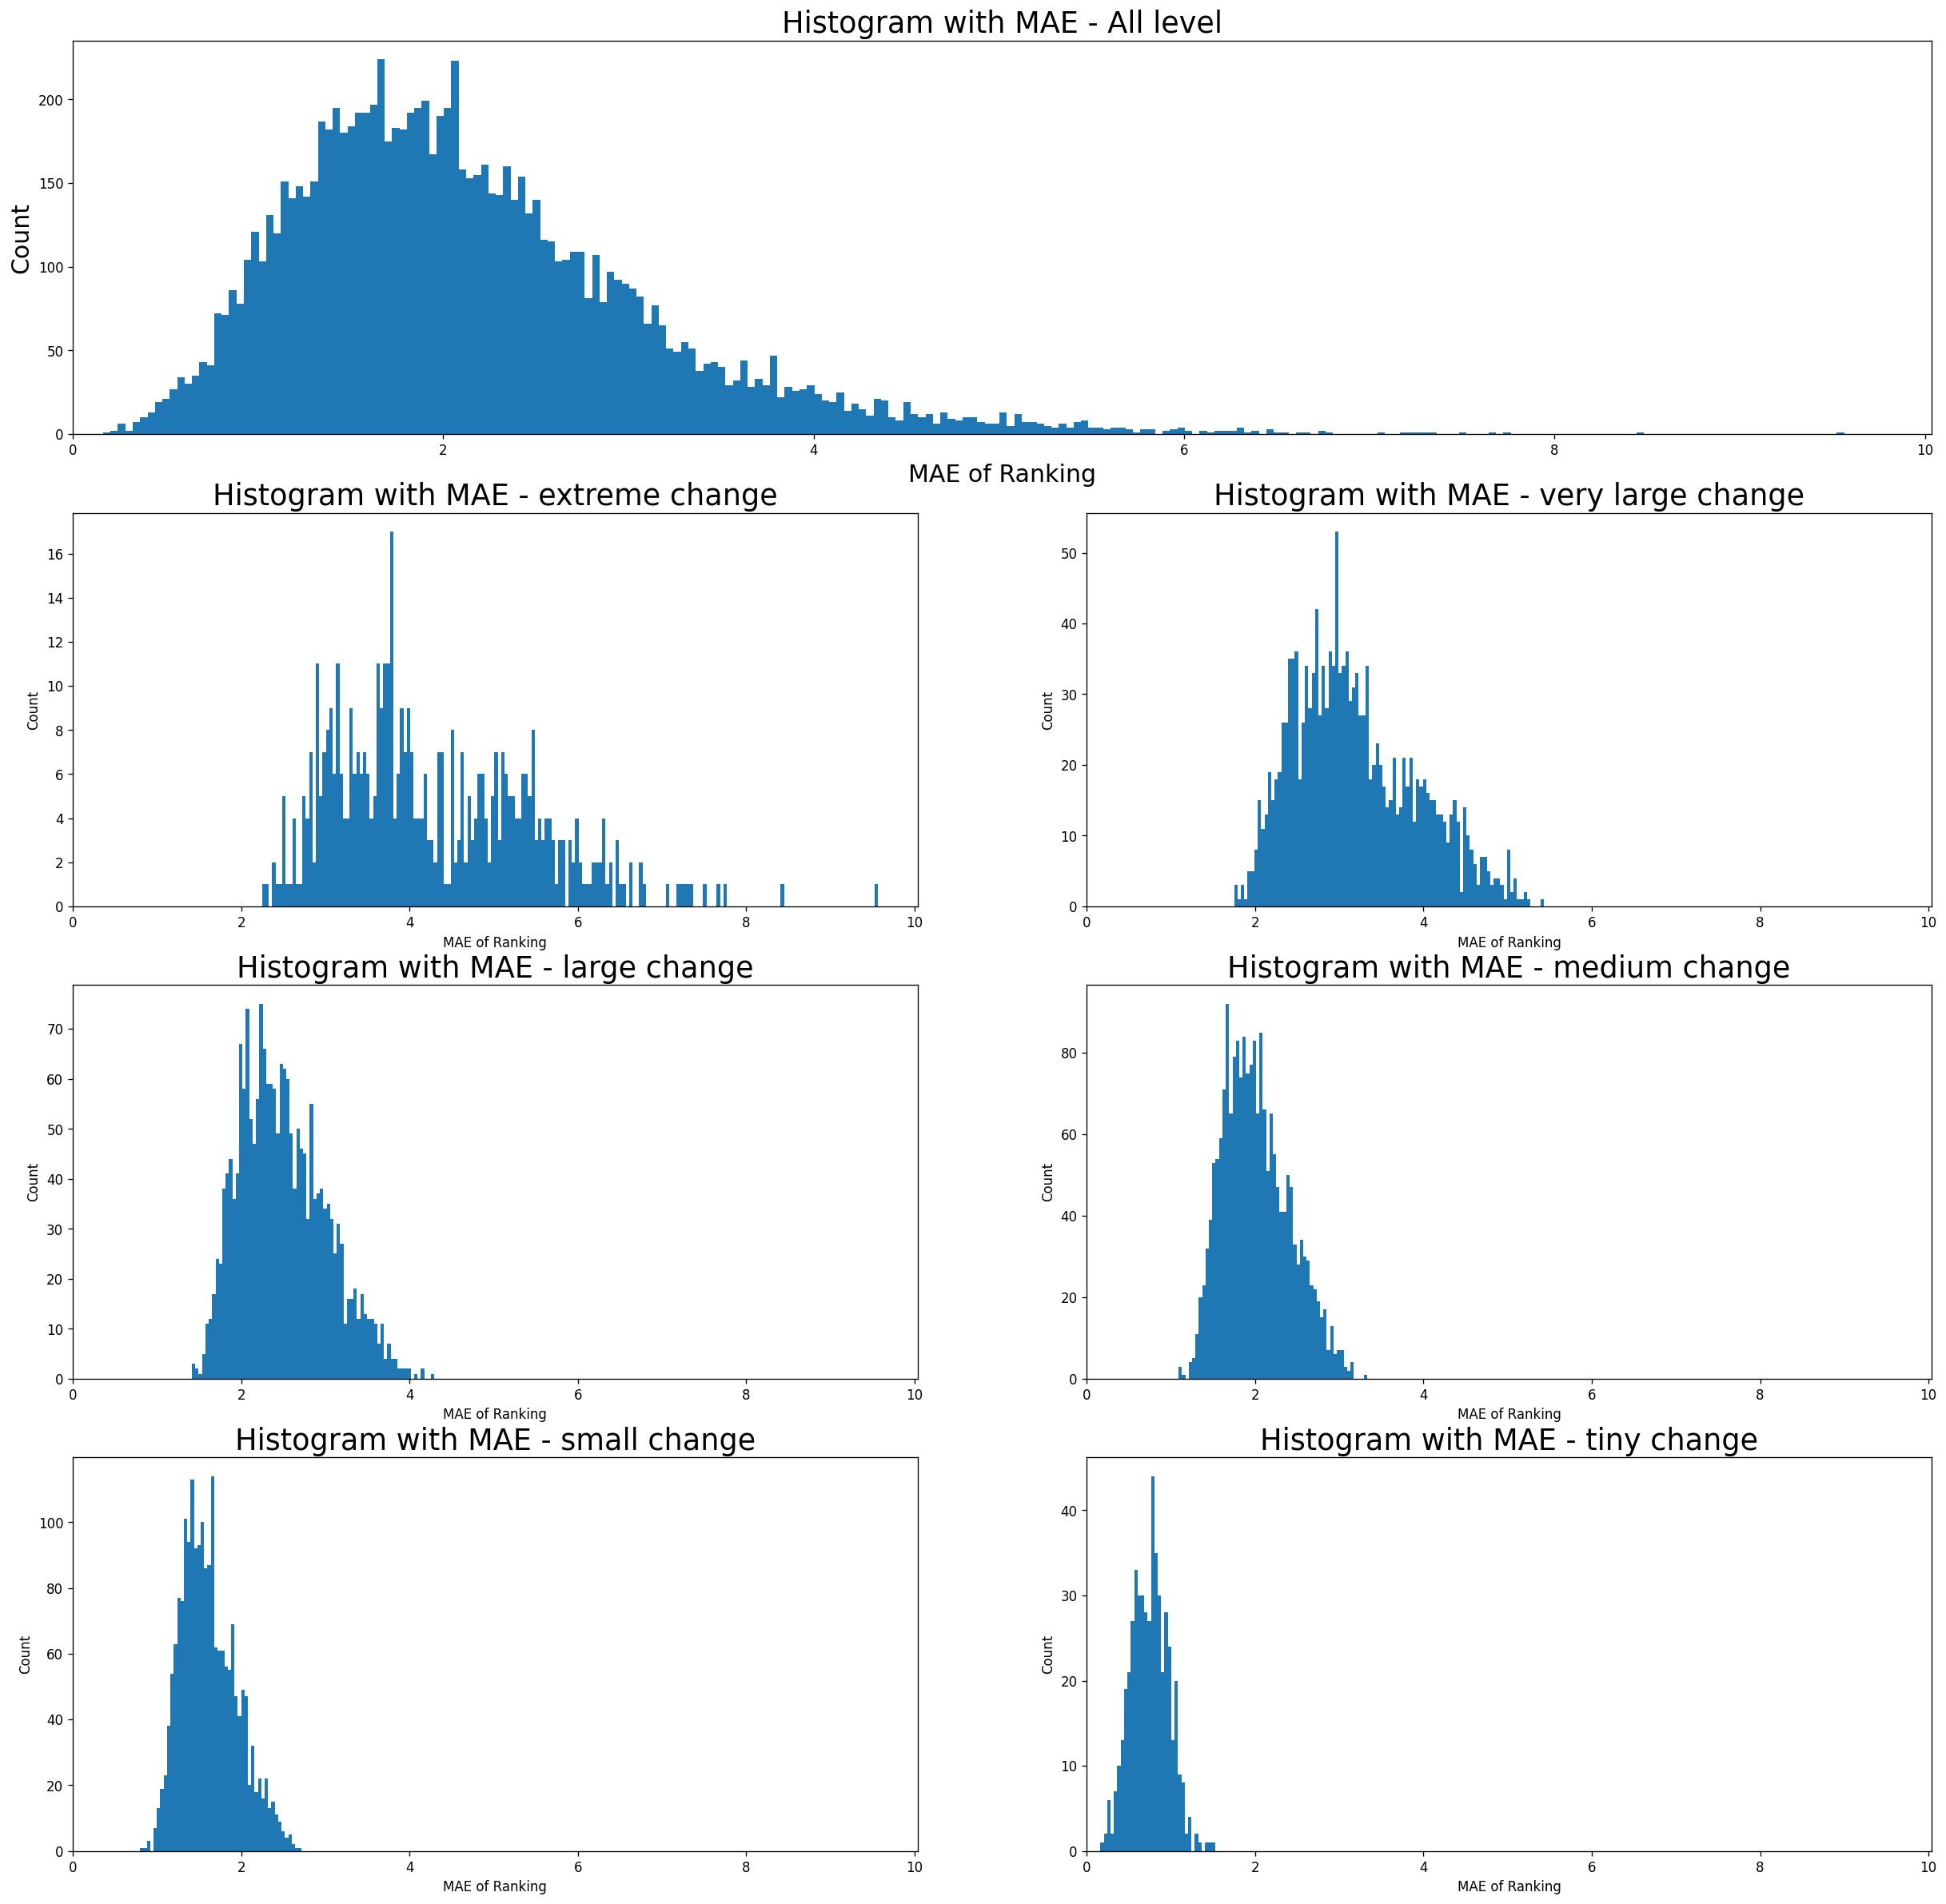

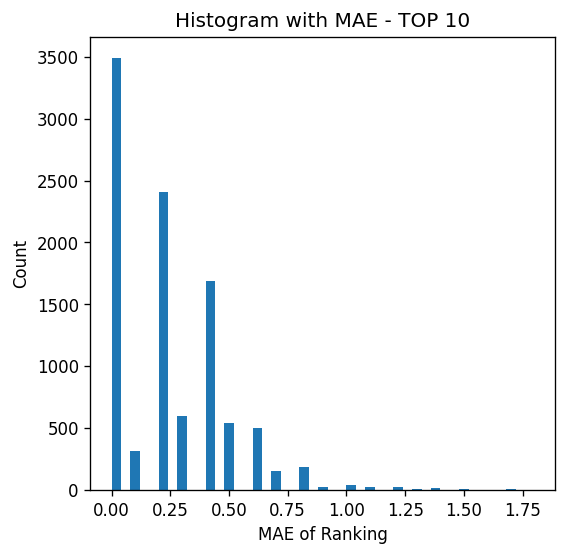

folder name: path_to_500 sd = 0.02: 
min: 0.0006187105499086936
quantile 5%: 0.007760430404267482
quantile 20%: 0.012133656274783458
quantile 40%: 0.016046242329524667
quantile 60%: 0.020151082383069778
quantile 80%: 0.025497350042277708
quantile 95%: 0.034468450252275115
max: 0.0645088980631922
mean of MAE for Ranking (All level): 13.0817288
mean of MAE for Ranking (Extreme change): 27.168063999999998
mean of MAE for Ranking (very large change): 19.566874666666667
mean of MAE for Ranking (large change): 15.384338000000001
mean of MAE for Ranking (medium change): 12.25591
mean of MAE for Ranking (small change): 9.831636
mean of MAE for Ranking (tiny change): 4.40296
mean of MAE for Ranking (TOP 10 change): 1.8208799999999998
 
mode of MAE for Ranking (All level): [(14.496, 9)]
mode of MAE for Ranking (Extreme change): [(23.532, 2)]
mode of MAE for Ranking (very large change): [(19.4, 4)]
mode of MAE for Ranking (large change): [(16.068, 7)]
mode of MAE for Ranking (medium change): [(10

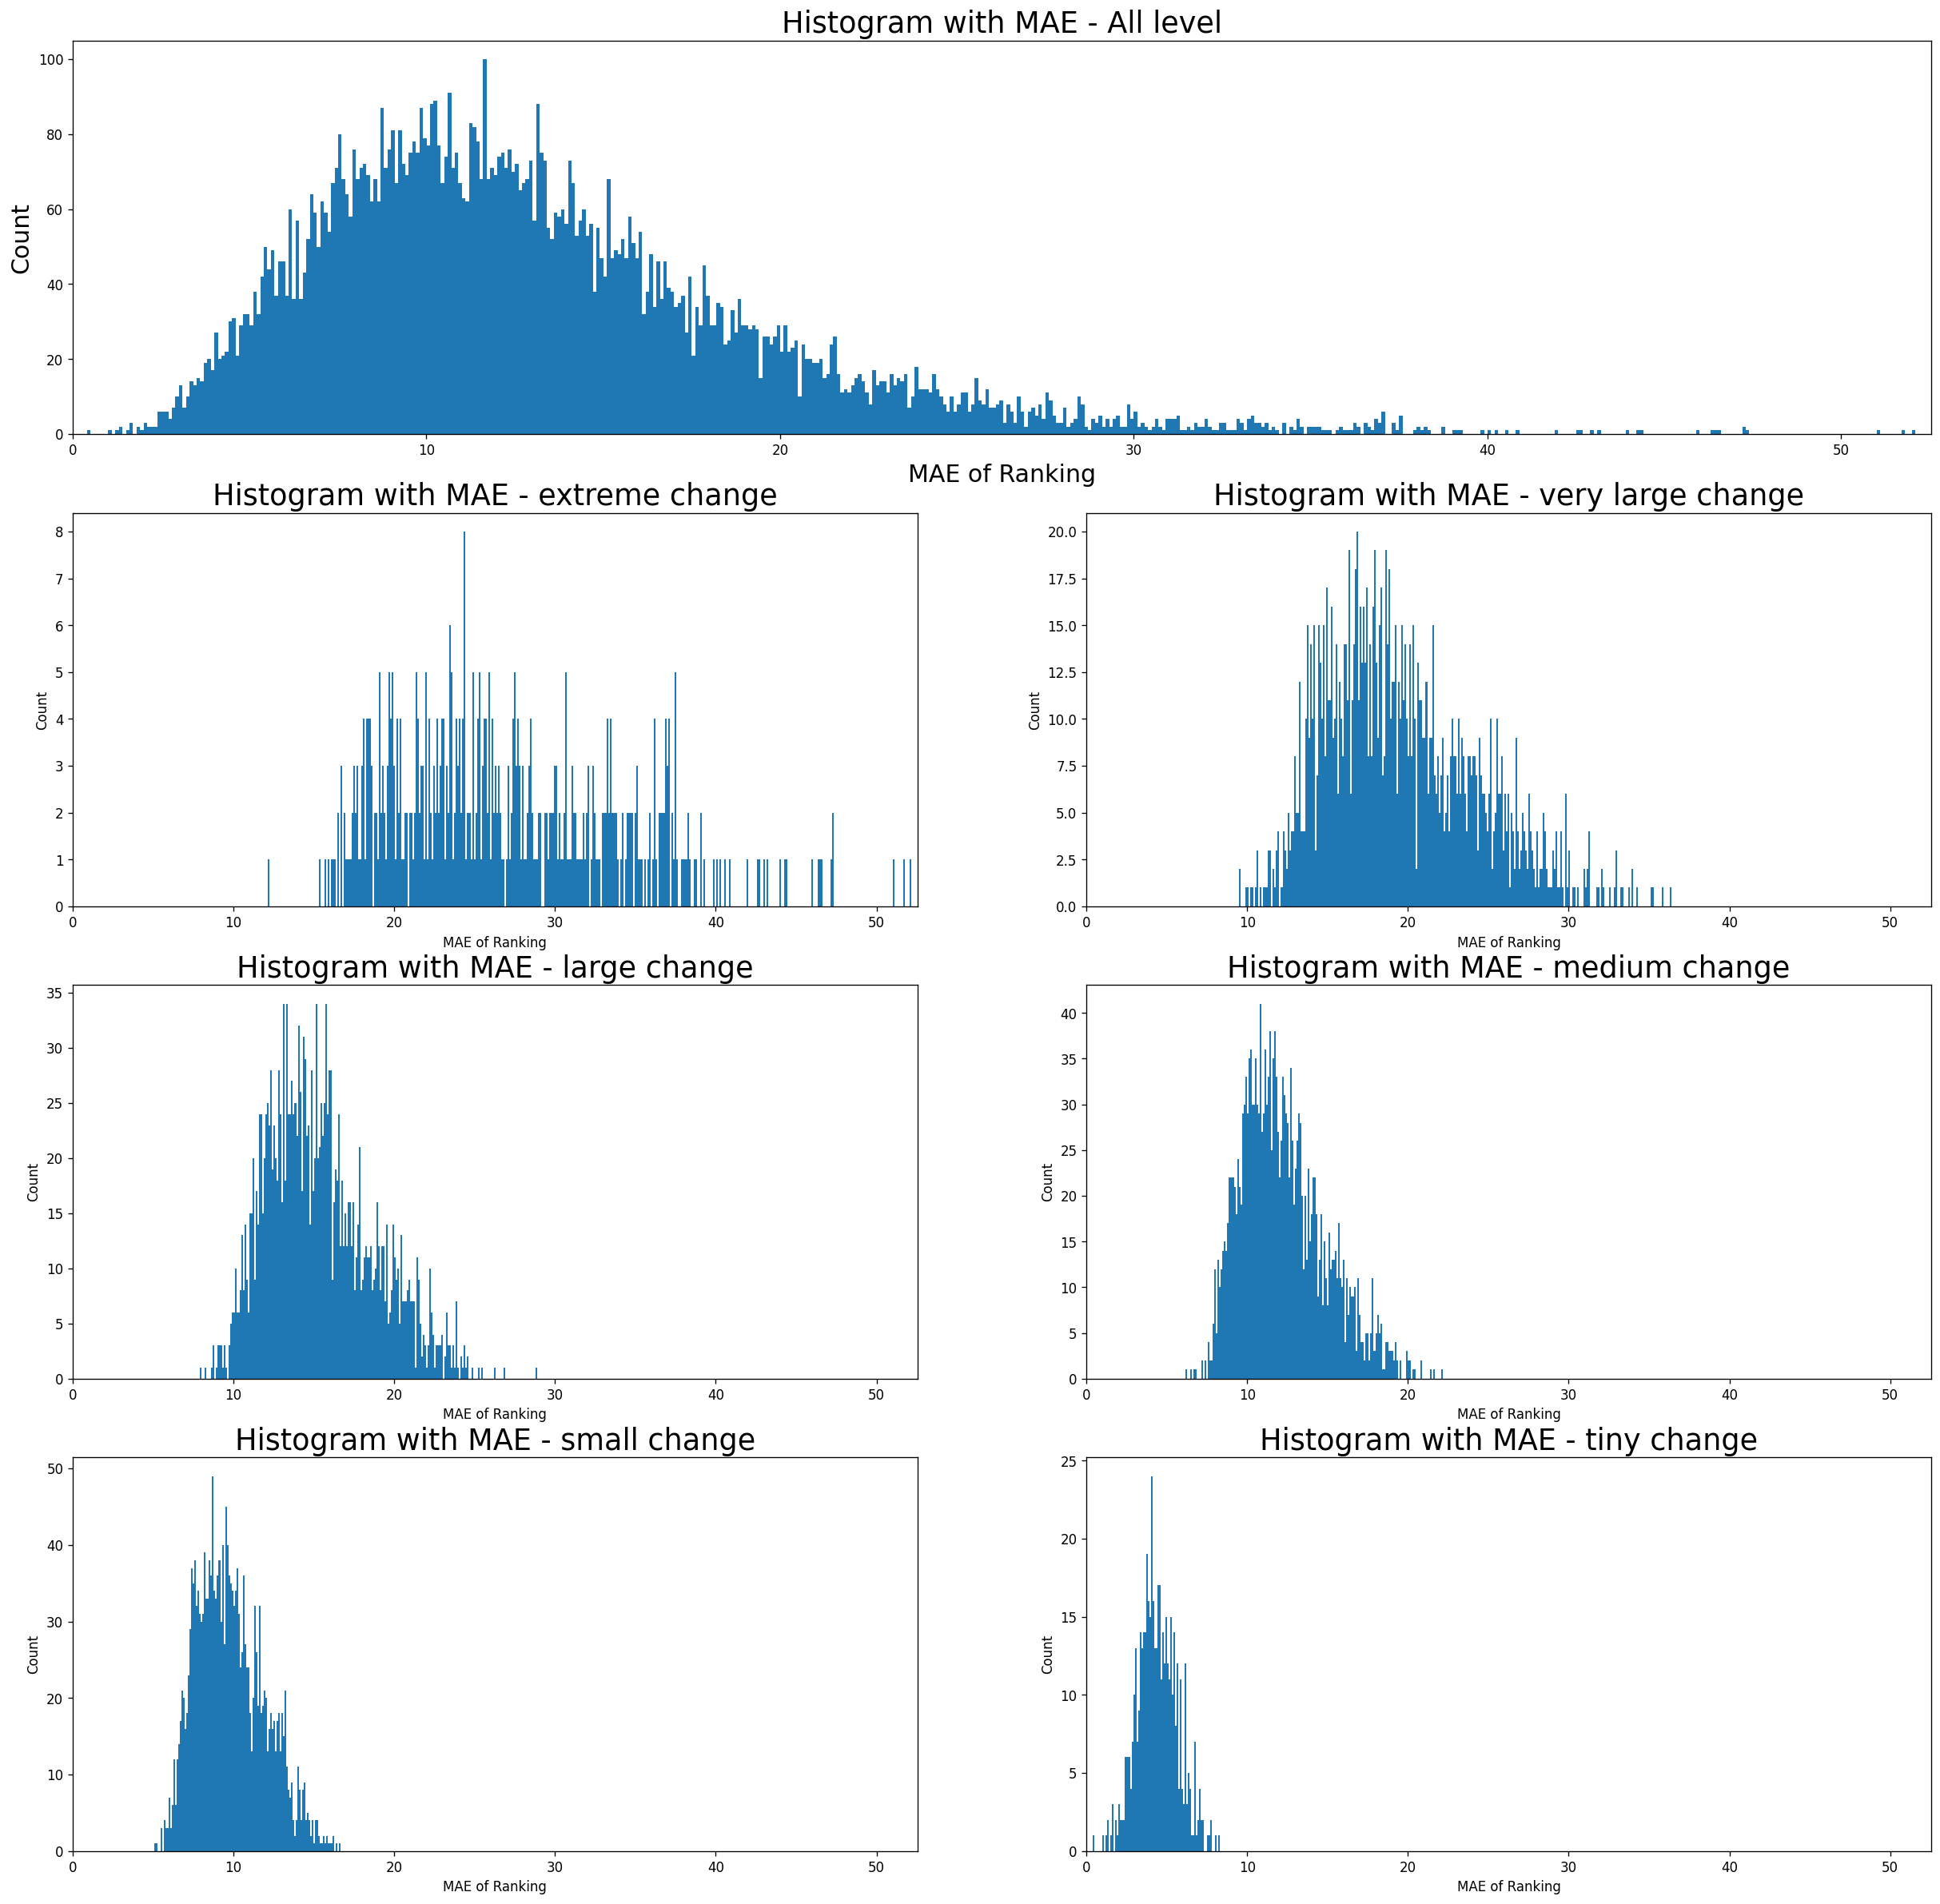

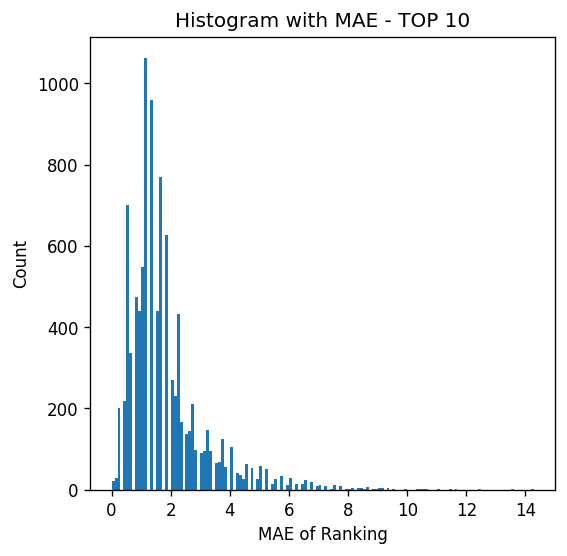

folder name: path_to_500 sd = 0.1: 
min: 0.005532381944789258
quantile 5%: 0.0392822920788416
quantile 20%: 0.059030204557775176
quantile 40%: 0.07631332968532417
quantile 60%: 0.09332769676105312
quantile 80%: 0.11557866222878636
quantile 95%: 0.1511803016377858
max: 0.27634994461120316
mean of MAE for Ranking (All level): 52.403328599999995
mean of MAE for Ranking (Extreme change): 84.888212
mean of MAE for Ranking (very large change): 70.07414133333333
mean of MAE for Ranking (large change): 61.159671
mean of MAE for Ranking (medium change): 52.338823000000005
mean of MAE for Ranking (small change): 44.24099
mean of MAE for Ranking (tiny change): 20.545016
mean of MAE for Ranking (TOP 10 change): 14.269975
 
mode of MAE for Ranking (All level): [(52.528, 5)]
mode of MAE for Ranking (Extreme change): [(76.128, 2)]
mode of MAE for Ranking (very large change): [(59.356, 3)]
mode of MAE for Ranking (large change): [(52.528, 3)]
mode of MAE for Ranking (medium change): [(48.388, 4)]
mode

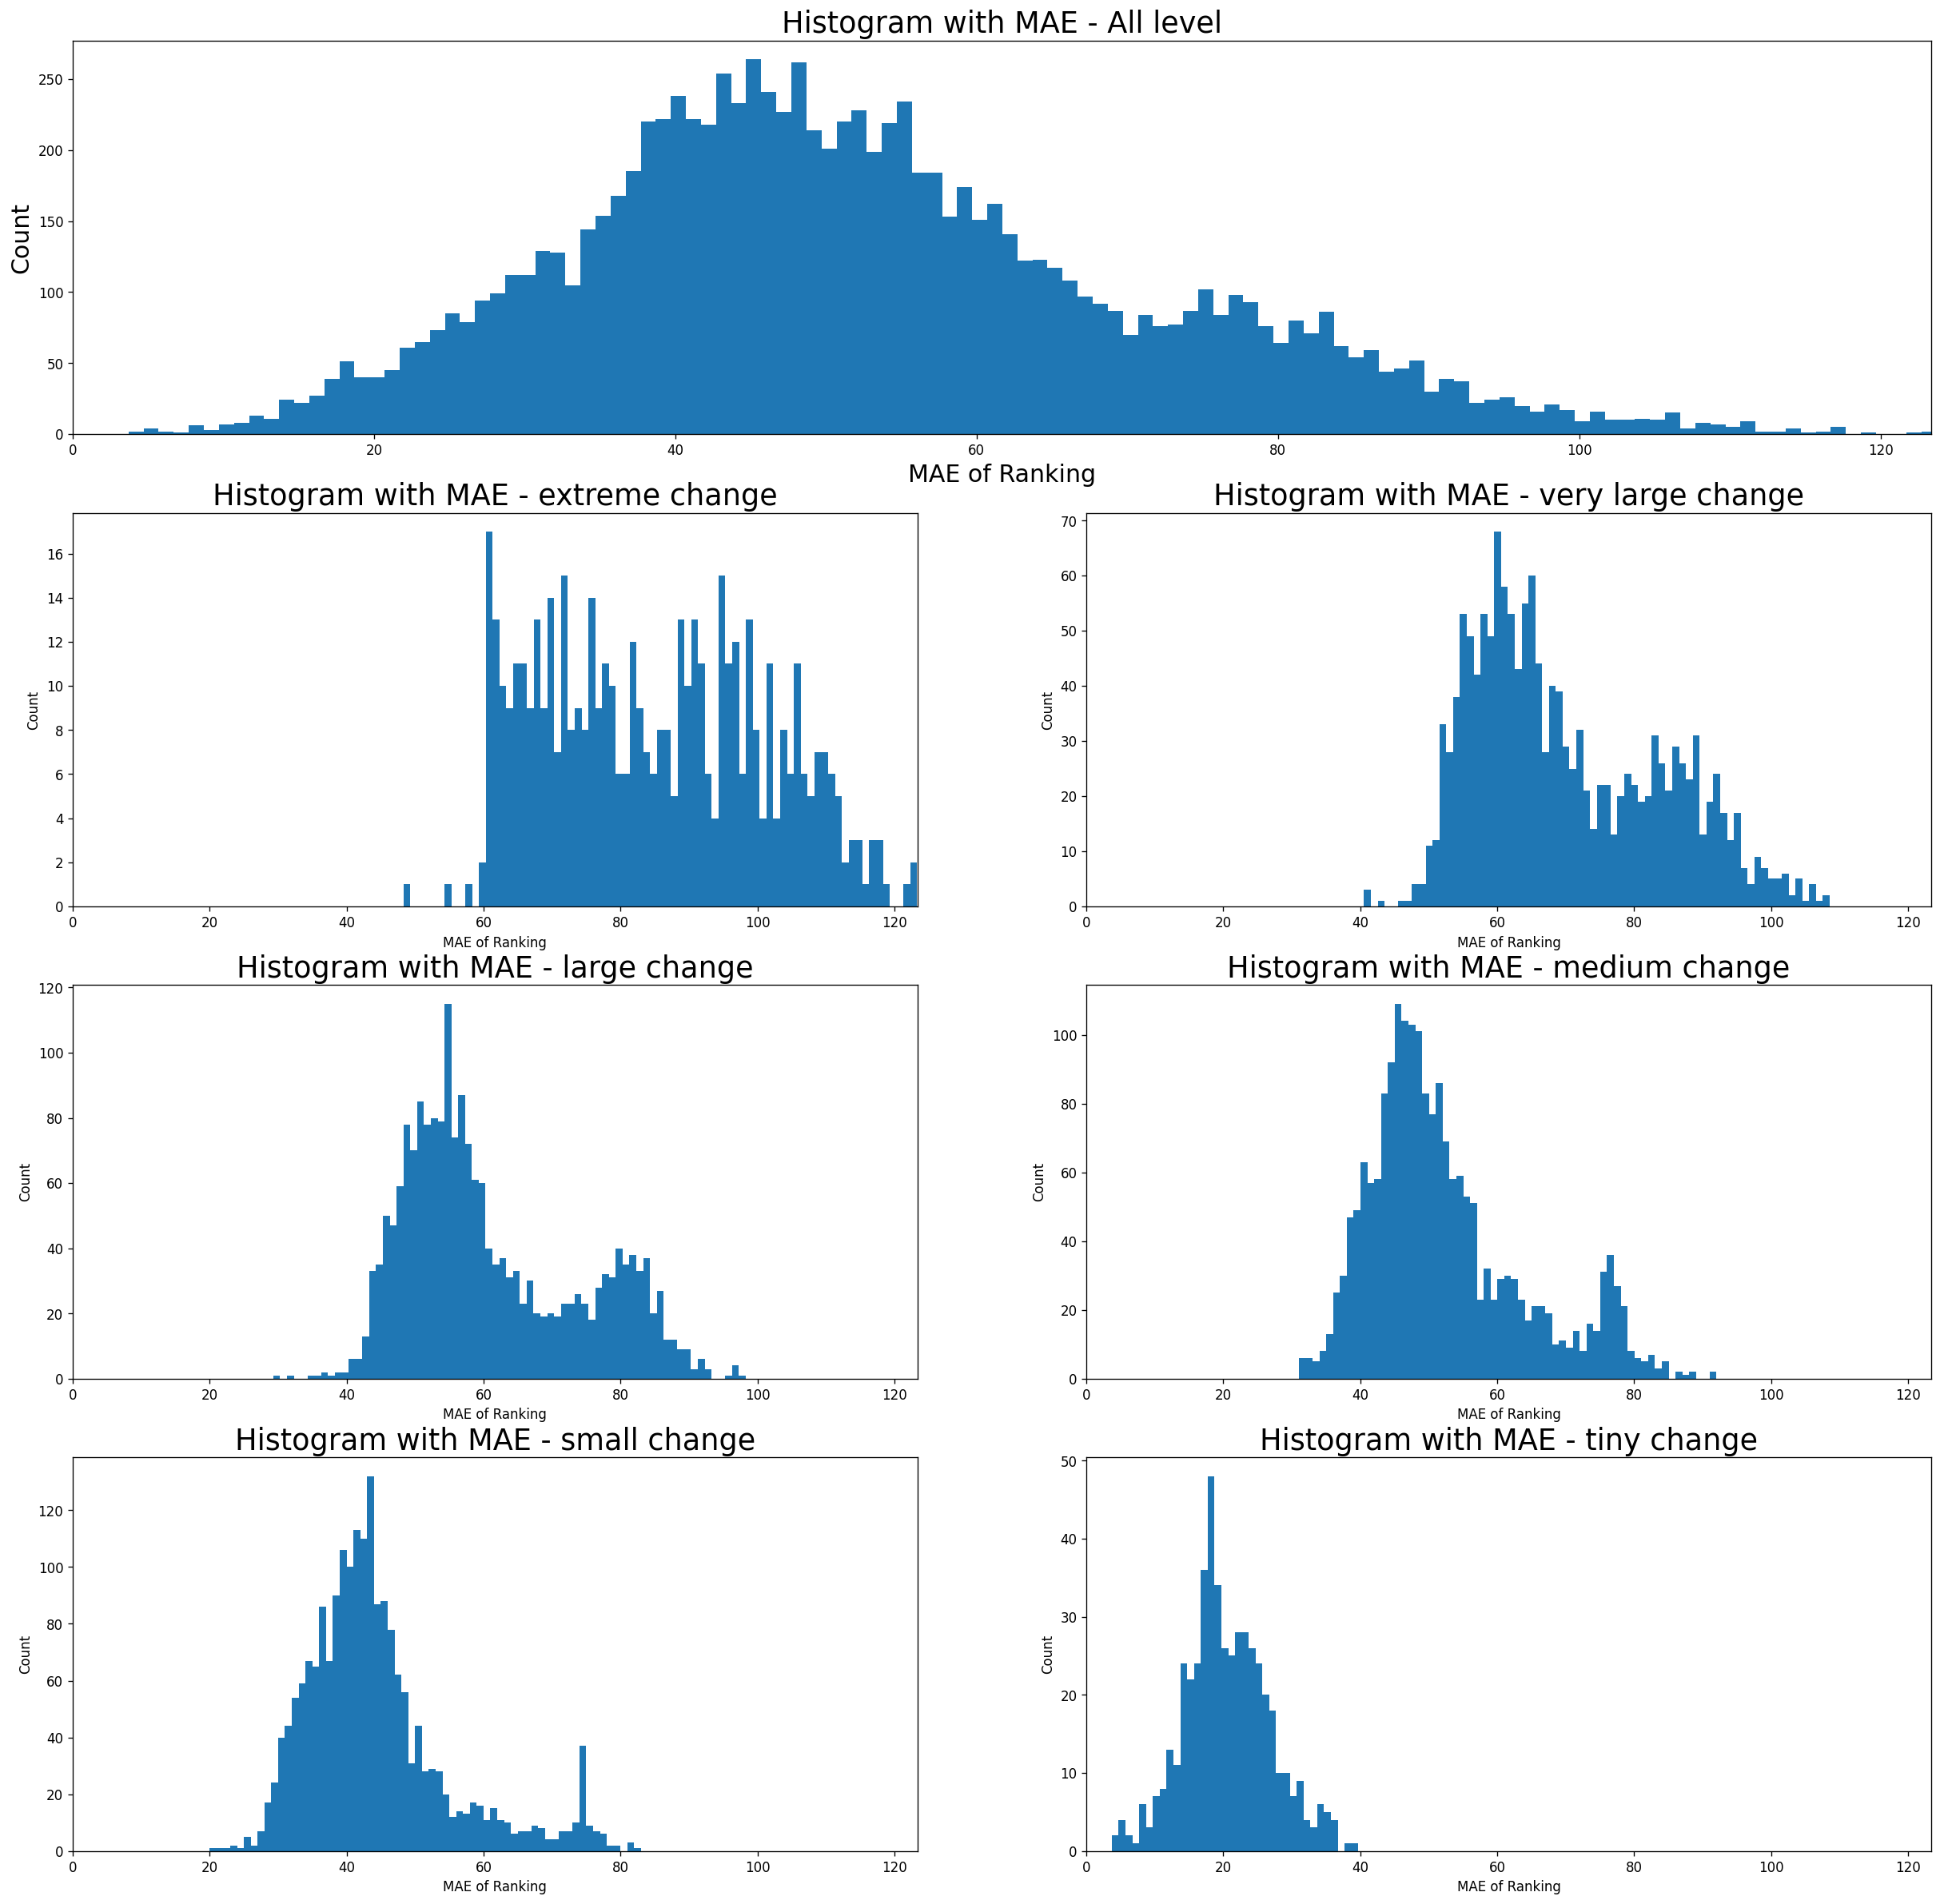

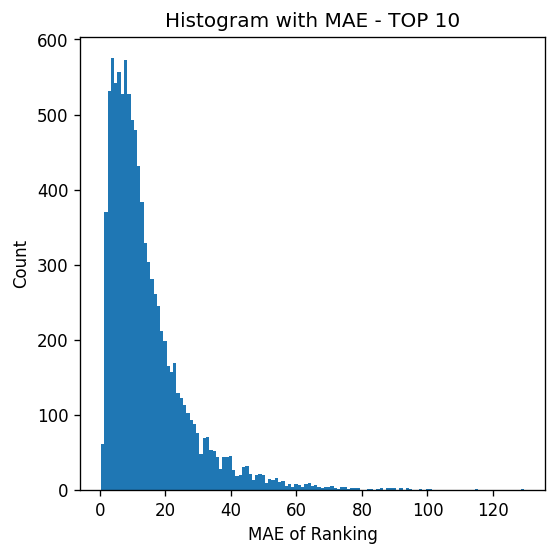

folder name: path_to_1000 sd = 0.003: 
min: 0.00029781055244960106
quantile 5%: 0.001176267688772318
quantile 20%: 0.001828115974058769
quantile 40%: 0.0024174801201343526
quantile 60%: 0.003017471358255707
quantile 80%: 0.0038286874933425408
quantile 95%: 0.00507620979082146
max: 0.00914822404419006
mean of MAE for Ranking (All level): 4.129859799999999
mean of MAE for Ranking (Extreme change): 8.363728000000002
mean of MAE for Ranking (very large change): 6.069530666666667
mean of MAE for Ranking (large change): 4.817247
mean of MAE for Ranking (medium change): 3.910911
mean of MAE for Ranking (small change): 3.151488
mean of MAE for Ranking (tiny change): 1.4931800000000002
mean of MAE for Ranking (TOP 10 change): 0.33033
 
mode of MAE for Ranking (All level): [(3.584, 13)]
mode of MAE for Ranking (Extreme change): [(7.37, 2)]
mode of MAE for Ranking (very large change): [(4.634, 4)]
mode of MAE for Ranking (large change): [(4.374, 6)]
mode of MAE for Ranking (medium change): [(3.33

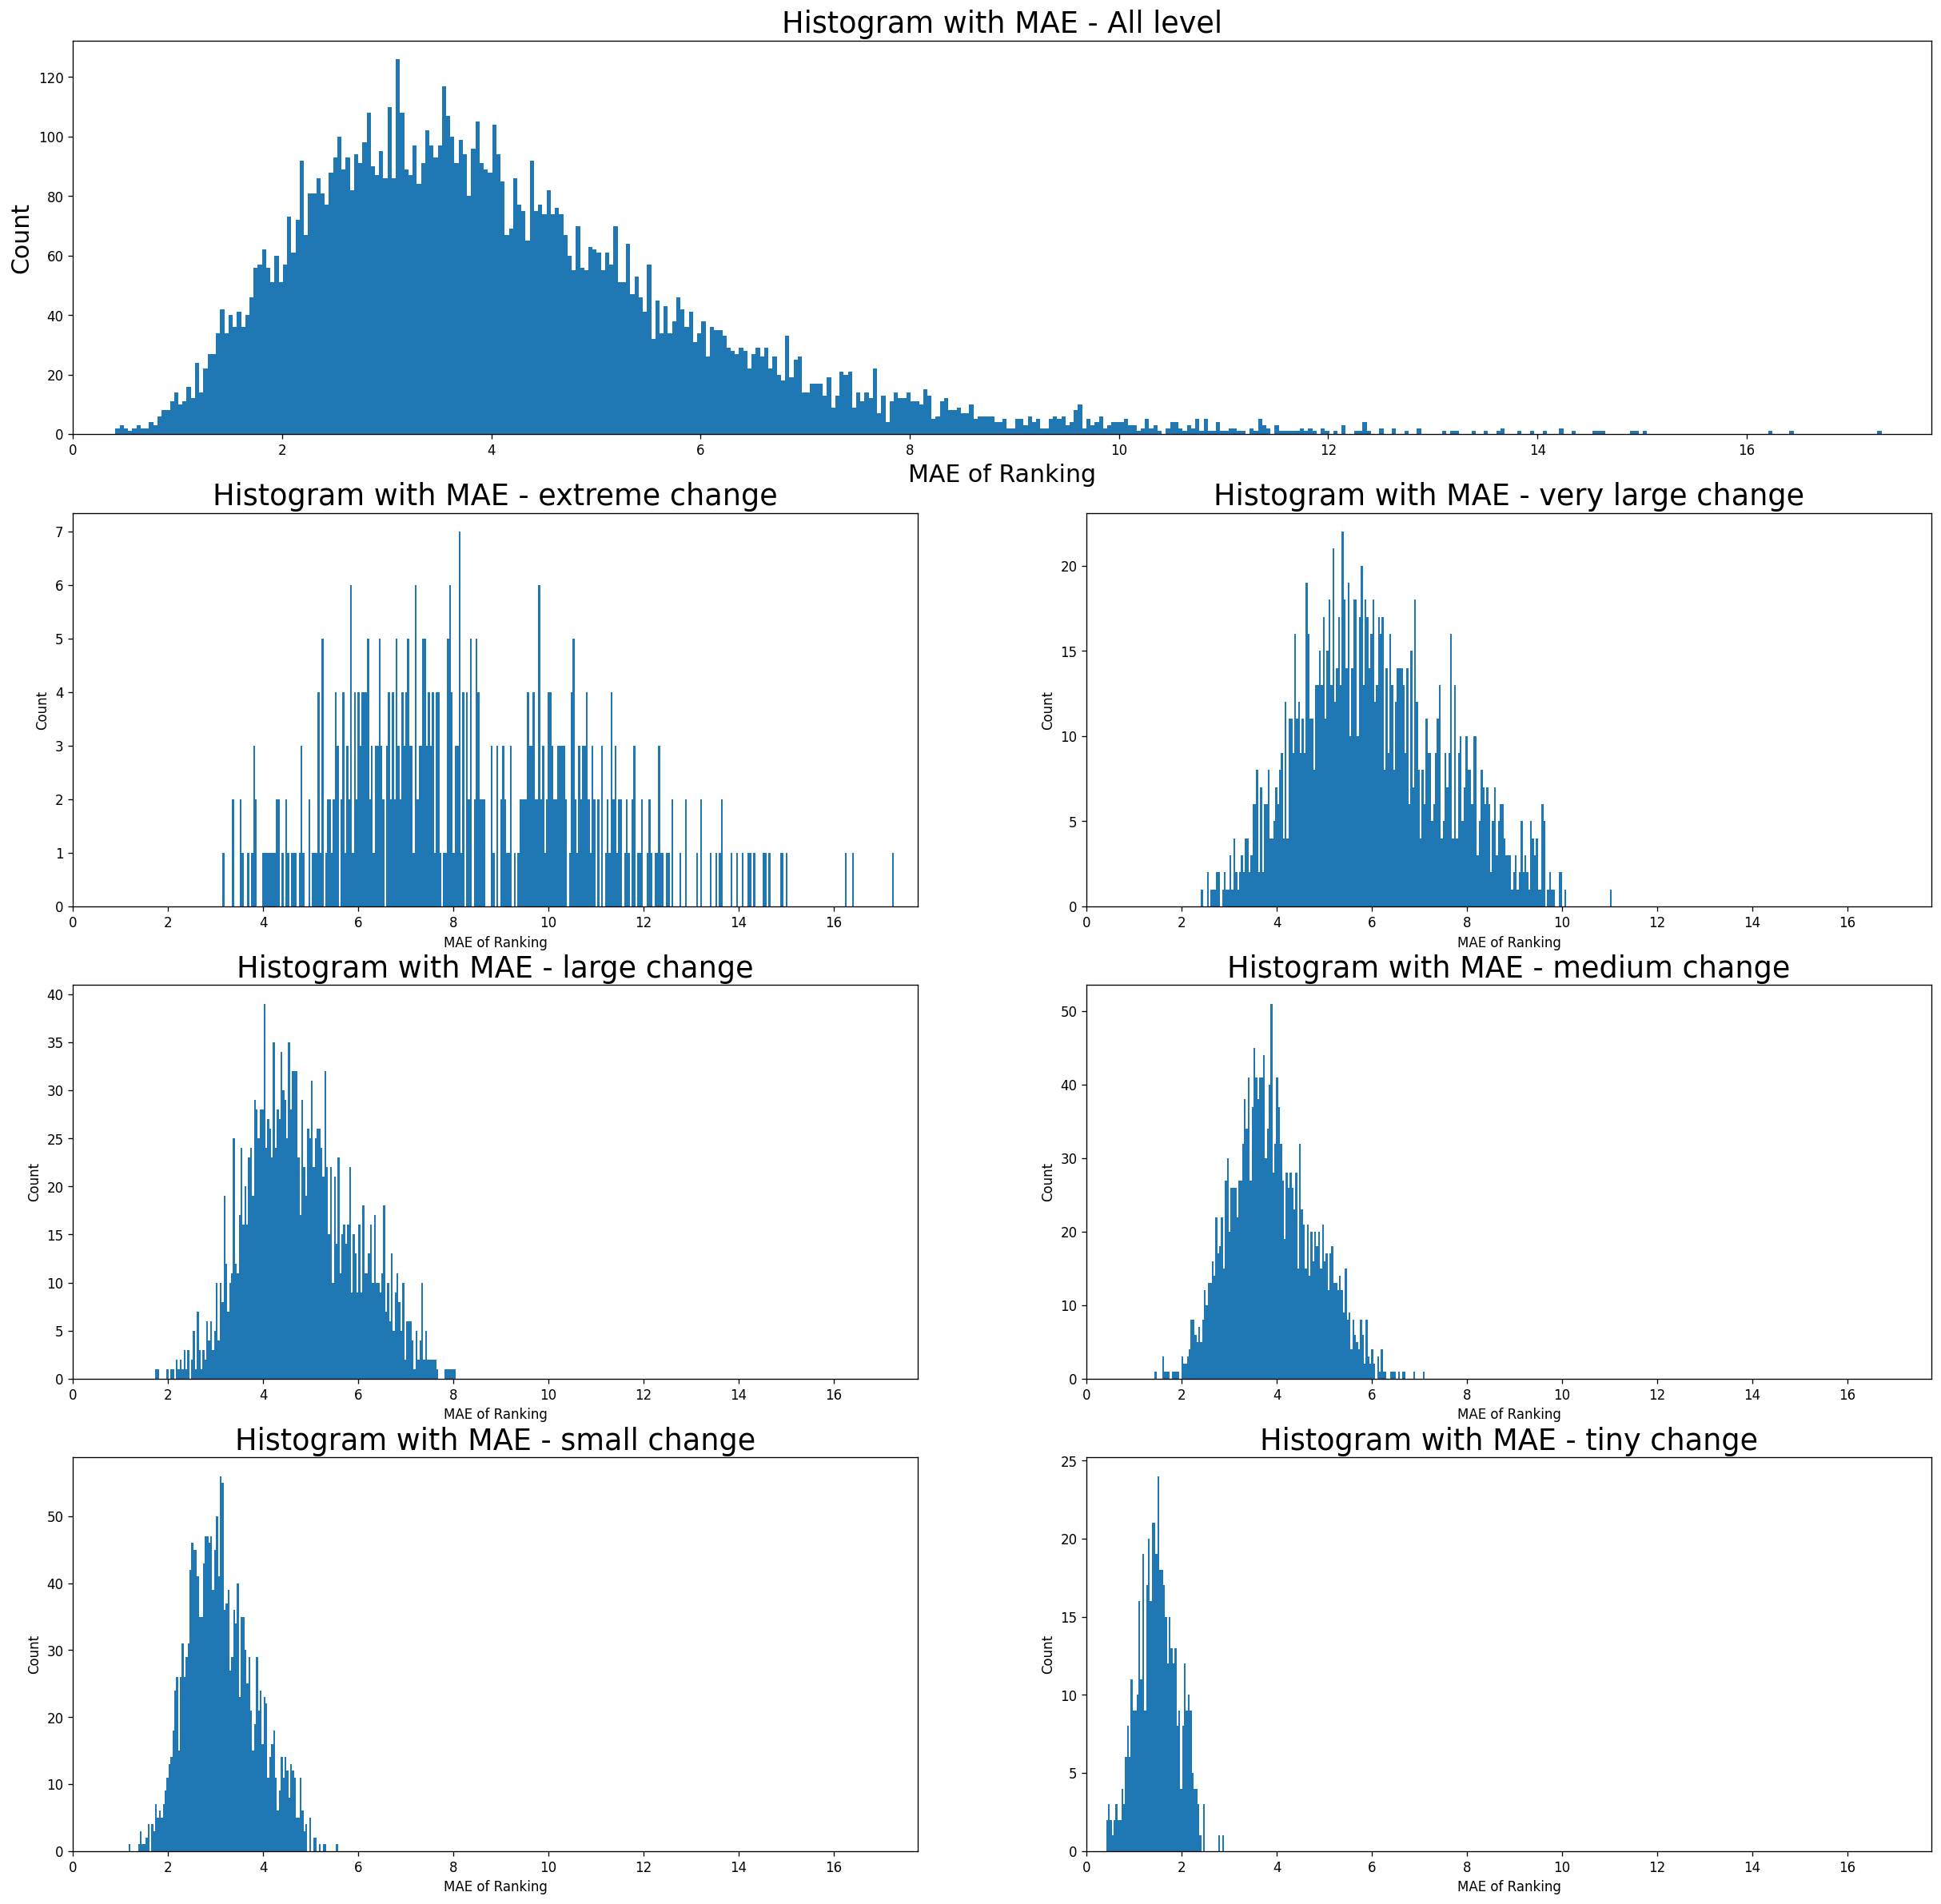

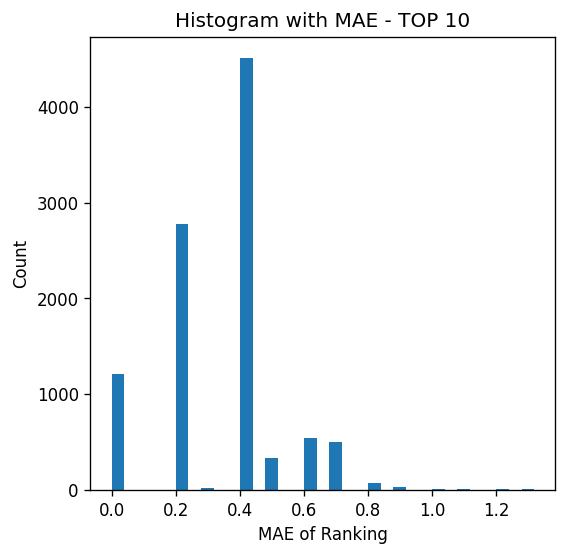

folder name: path_to_1000 sd = 0.02: 
min: 0.001207743598868019
quantile 5%: 0.007752831073476005
quantile 20%: 0.01221143500184827
quantile 40%: 0.016082111356199677
quantile 60%: 0.020113136272041598
quantile 80%: 0.025632722675688783
quantile 95%: 0.03441970282727649
max: 0.06836351473762985
mean of MAE for Ranking (All level): 25.876009099999997
mean of MAE for Ranking (Extreme change): 54.855074
mean of MAE for Ranking (very large change): 39.179530666666665
mean of MAE for Ranking (large change): 30.303936999999998
mean of MAE for Ranking (medium change): 24.256336
mean of MAE for Ranking (small change): 19.106624
mean of MAE for Ranking (tiny change): 8.391243999999999
mean of MAE for Ranking (TOP 10 change): 1.7091
 
mode of MAE for Ranking (All level): [(22.442, 7)]
mode of MAE for Ranking (Extreme change): [(51.36, 2)]
mode of MAE for Ranking (very large change): [(36.132, 2)]
mode of MAE for Ranking (large change): [(22.442, 3)]
mode of MAE for Ranking (medium change): [(21.

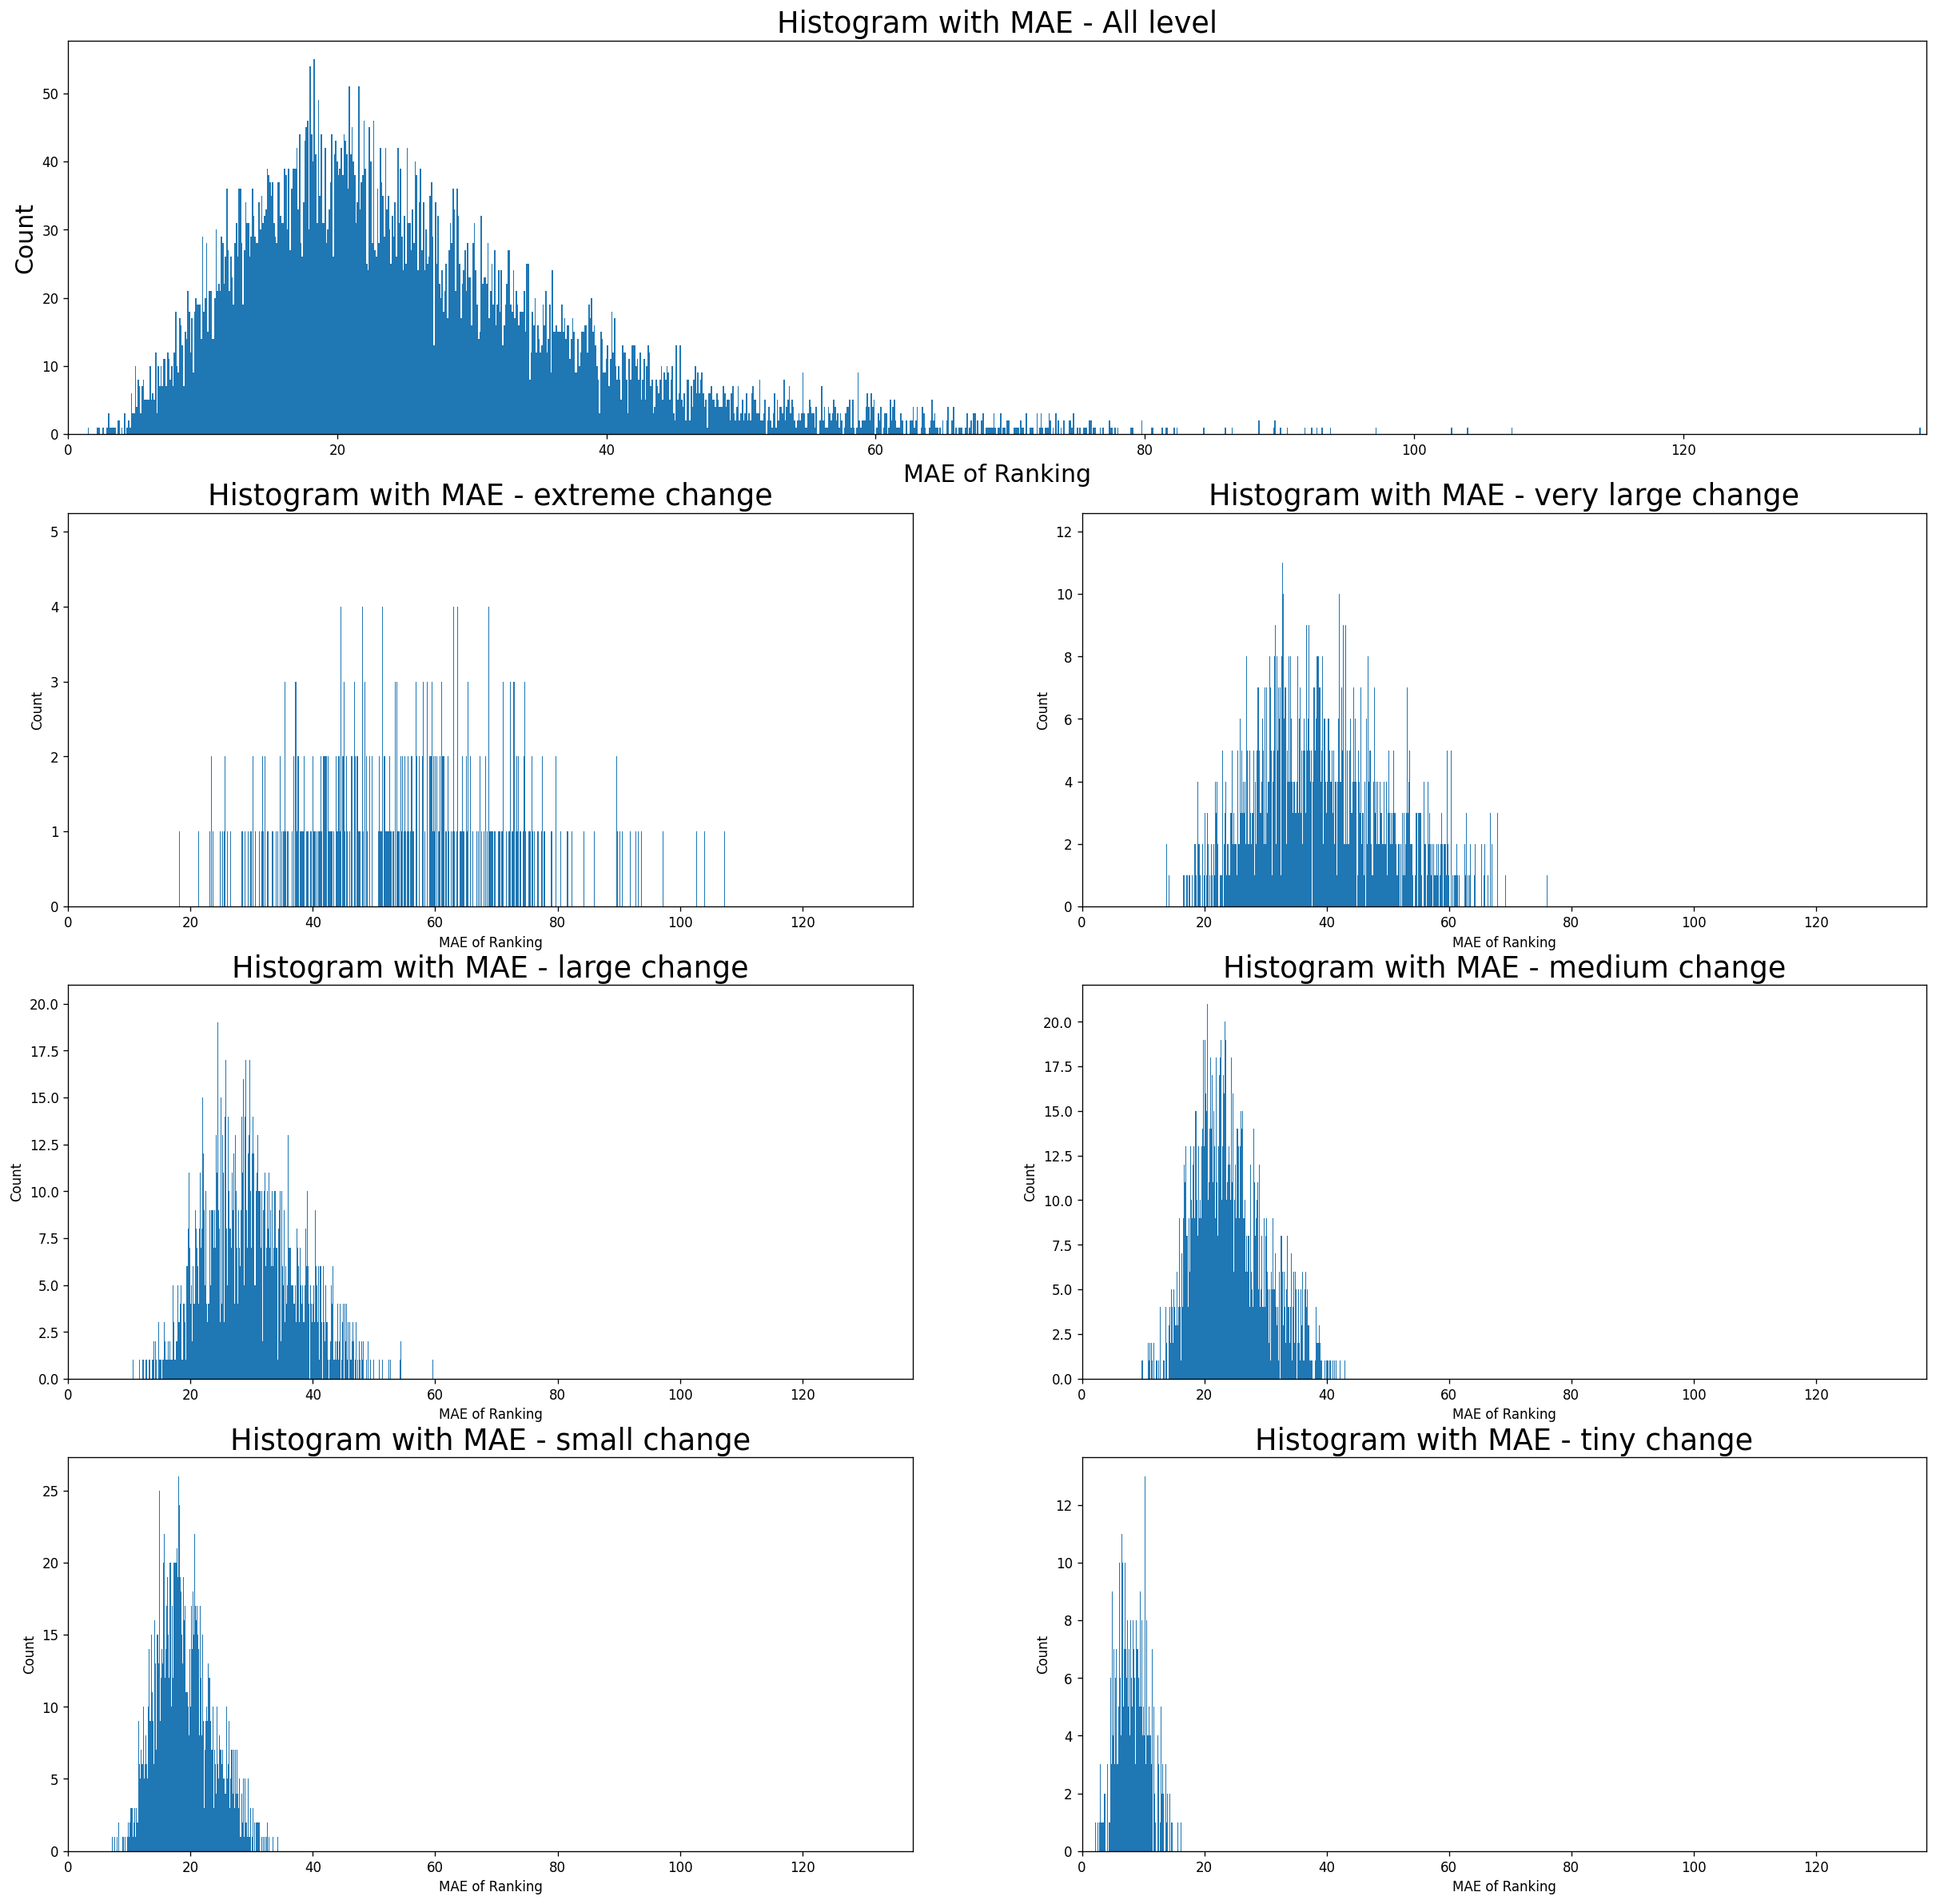

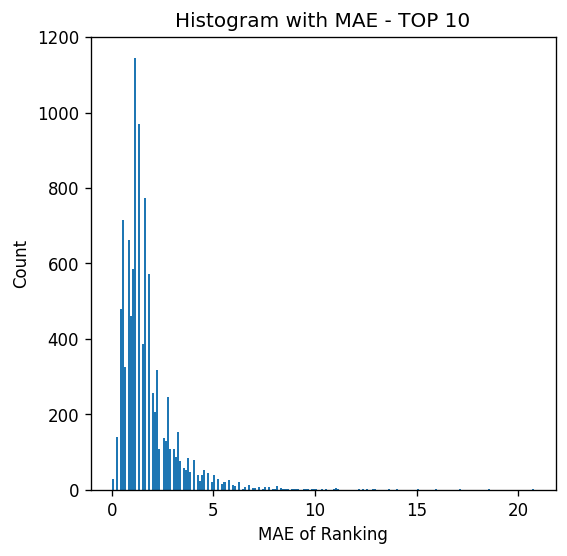

folder name: path_to_1000 sd = 0.1: 
min: 0.005380347252867087
quantile 5%: 0.03831723839759125
quantile 20%: 0.059436673356515354
quantile 40%: 0.07763191484153387
quantile 60%: 0.0947378138225406
quantile 80%: 0.1173135721912974
quantile 95%: 0.15164843379199514
max: 0.25537927961968065
mean of MAE for Ranking (All level): 104.0651905
mean of MAE for Ranking (Extreme change): 167.88152000000002
mean of MAE for Ranking (very large change): 137.787596
mean of MAE for Ranking (large change): 122.5023235
mean of MAE for Ranking (medium change): 103.9145295
mean of MAE for Ranking (small change): 88.39125349999999
mean of MAE for Ranking (tiny change): 40.767296
mean of MAE for Ranking (TOP 10 change): 23.03405
 
mode of MAE for Ranking (All level): [(115.11, 4)]
mode of MAE for Ranking (Extreme change): [(134.172, 2)]
mode of MAE for Ranking (very large change): [(117.126, 2)]
mode of MAE for Ranking (large change): [(96.066, 2)]
mode of MAE for Ranking (medium change): [(93.754, 3)]
mod

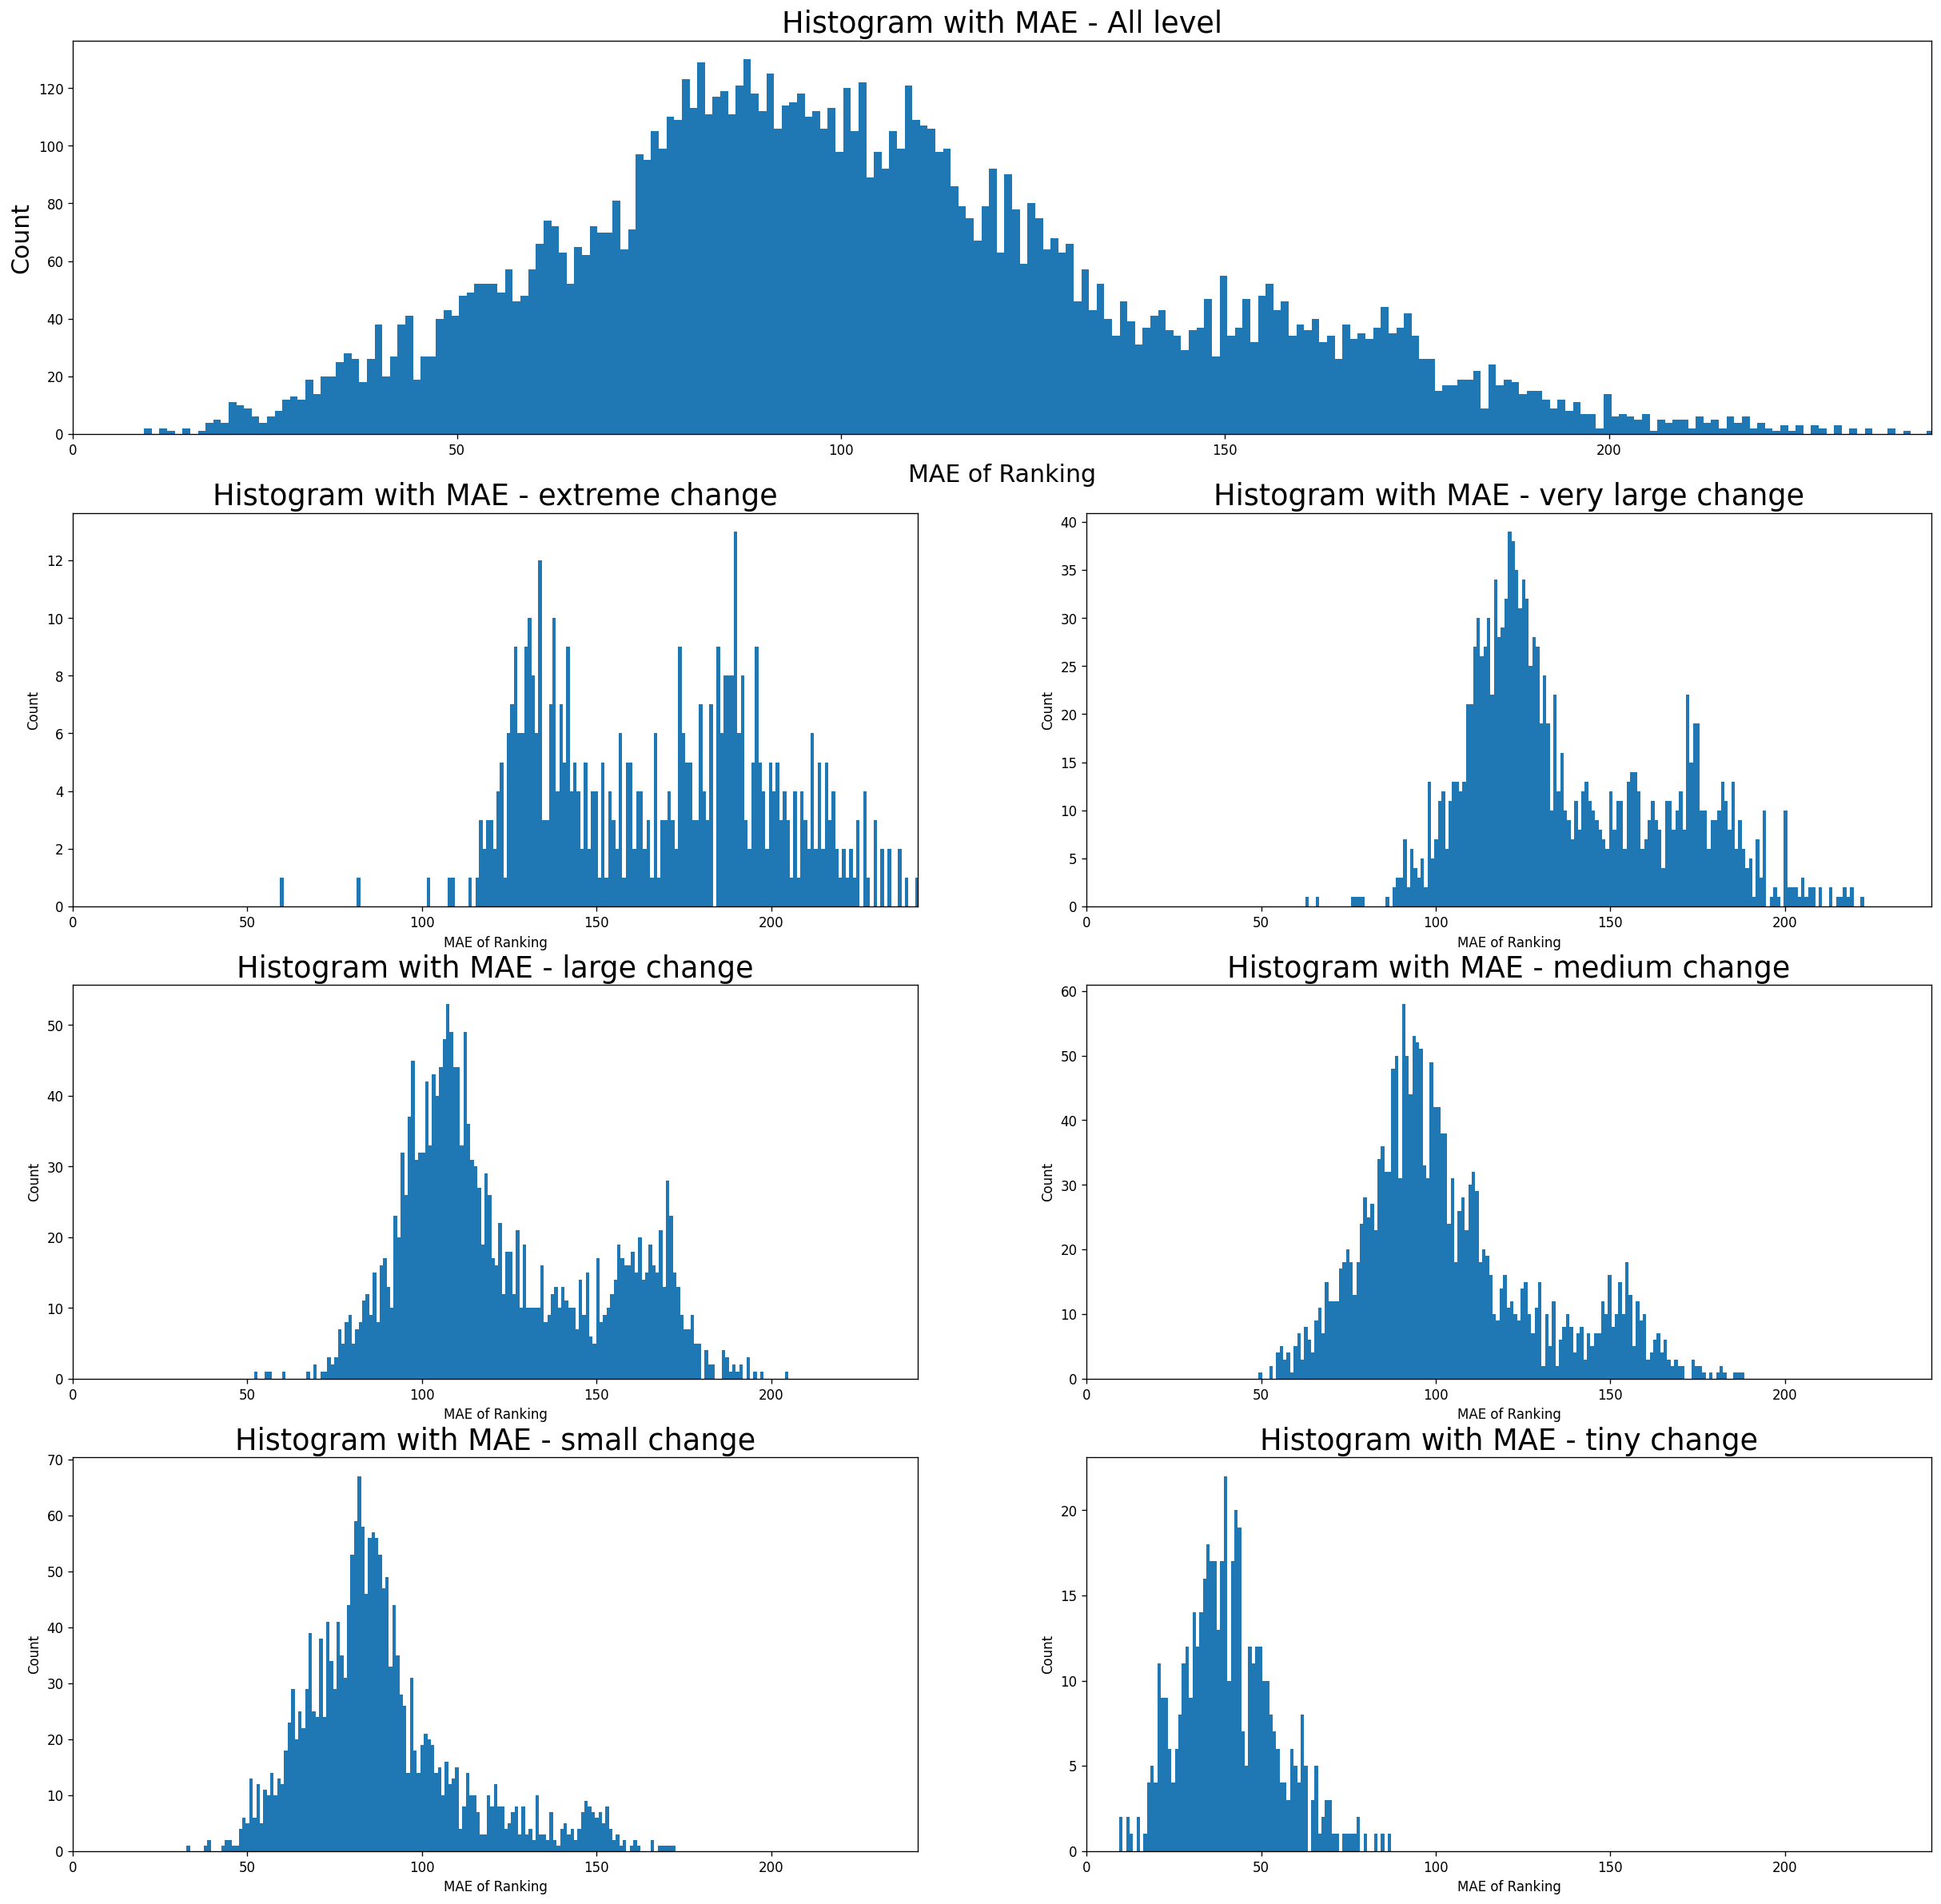

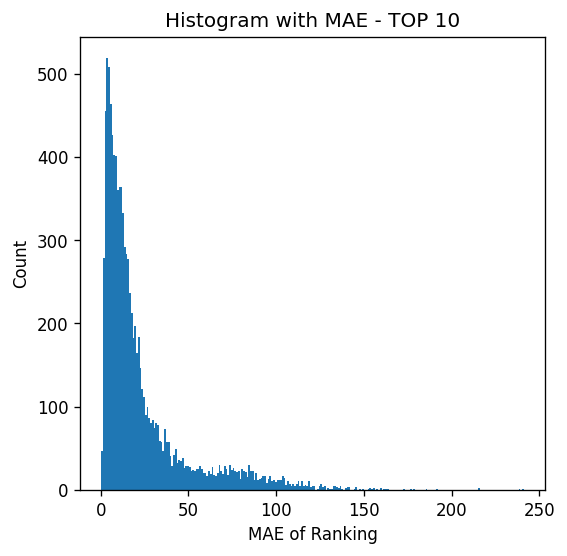

In [ ]:
num = -1
for i in np.arange(0,3):
    num = num + 1
    for j in np.arange(0,3):
        print('folder name: ' + data_set_name[num] + ' sd = ' + str(sd_list[j]) + ': ')
        weight_shuffle_first,first_10_MAE_shuffle_first = One_job_analytics(Raw_data = data_set_list[i], Job_id = 456, baseline_weight= [0.2018,0.3028,0.1014,0.1821,0.2119], sd = sd_list[j], iter_times = 10000,
                            Expert_yrs_set_up = 10, Intermediate_yrs_set_up = 6.5, Beginner_yrs_set_up = 2,
                                proficiency_far_below = 0.6, proficiency_below = 0.8, proficiency_meets = 1, proficiency_above = 1.1, proficiency_far_above = 1.2,
                                        yrs_exp_function_name = col_sigmoid, last_used_function_name = col_sigmoid, 
                                            yrs_slope = 0.5, yrs_horizontal_shift = 7,
                                                last_slope = -0.8, last_horizontal_shift = 6, bin_length = bin_length_list[j])

## Baseline is [0.3,0.2,0.3,0.1,0.1]

folder name: path_to_data_folder sd = 0.003: 
min: 0.00020898953584438384
quantile 5%: 0.0011576914256403667
quantile 20%: 0.0018273047780029434
quantile 40%: 0.0024188454441177714
quantile 60%: 0.0030111085050298003
quantile 80%: 0.0037983241383924573
quantile 95%: 0.005156672105550717
max: 0.009829496644956155
mean of MAE for Ranking (All level): 0.19428301886792448
mean of MAE for Ranking (Extreme change): 0.421433962264151
mean of MAE for Ranking (very large change): 0.29683018867924527
mean of MAE for Ranking (large change): 0.22405660377358488
mean of MAE for Ranking (medium change): 0.17515094339622642
mean of MAE for Ranking (small change): 0.14264150943396225
mean of MAE for Ranking (tiny change): 0.07373584905660377
mean of MAE for Ranking (TOP 10 change): 0.19589000000000004
 
mode of MAE for Ranking (All level): [(0.1509433962264151, 1696)]
mode of MAE for Ranking (Extreme change): [(0.37735849056603776, 60)]
mode of MAE for Ranking (very large change): [(0.3396226415094339

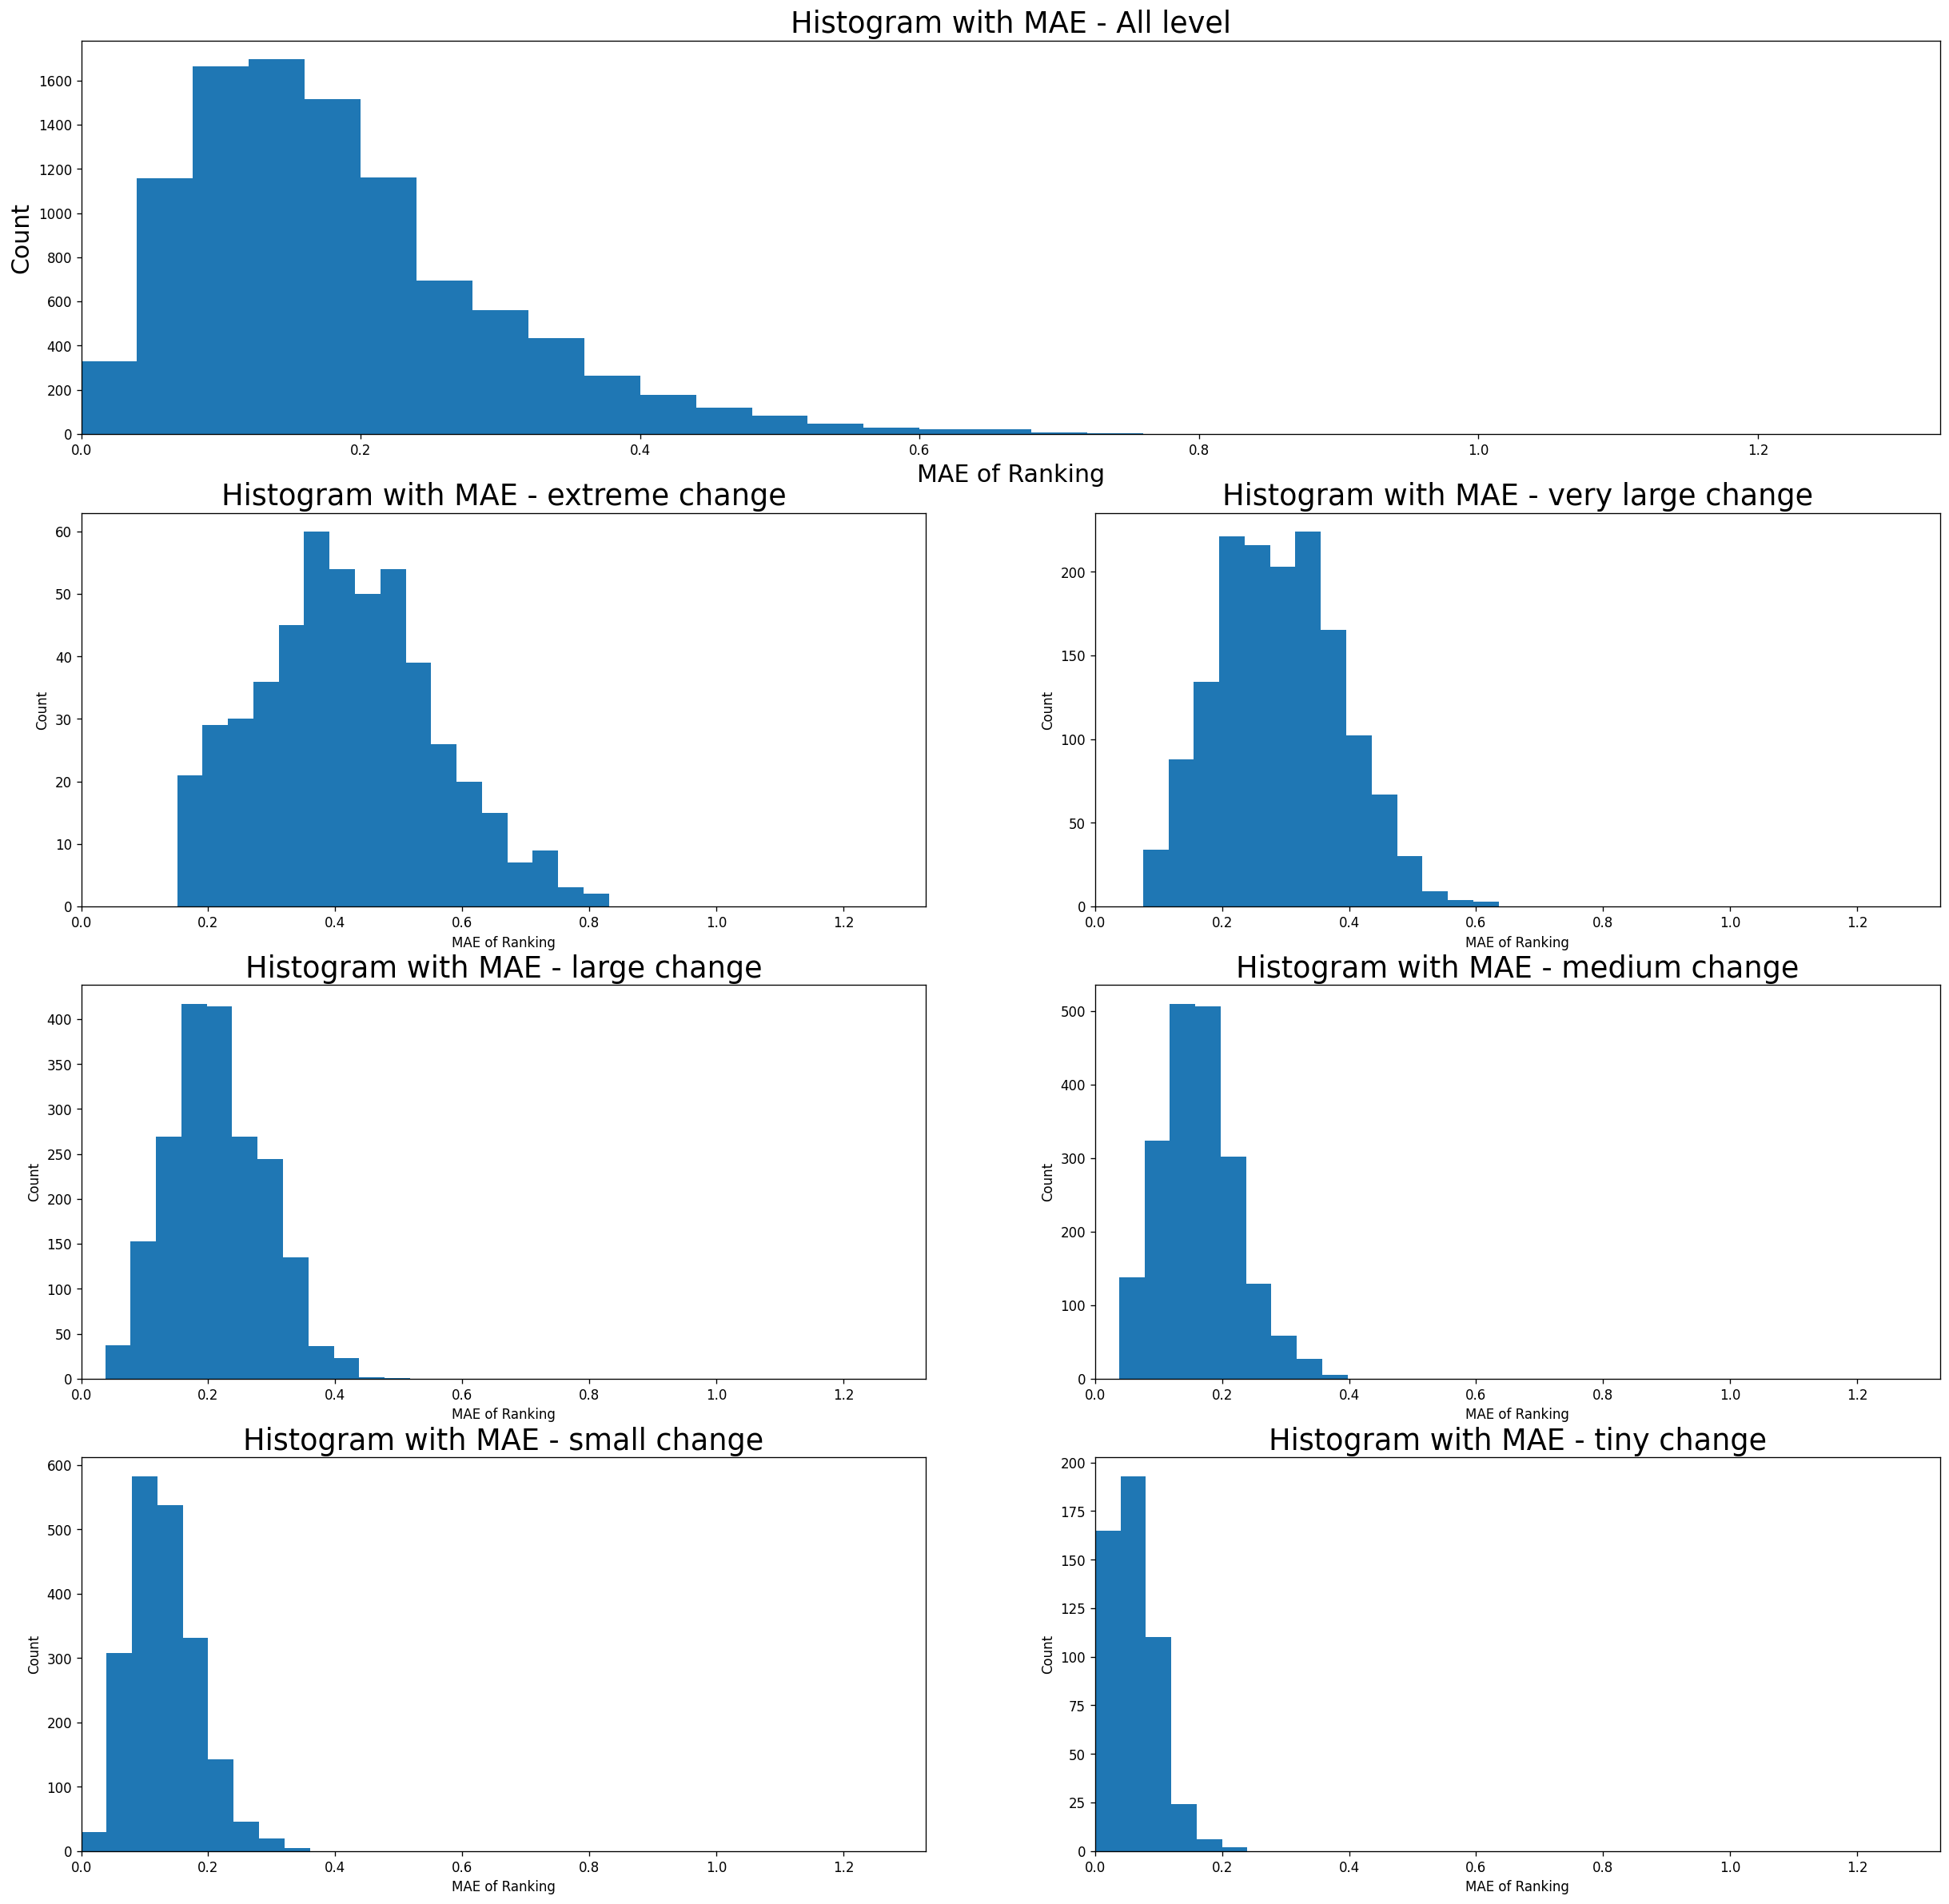

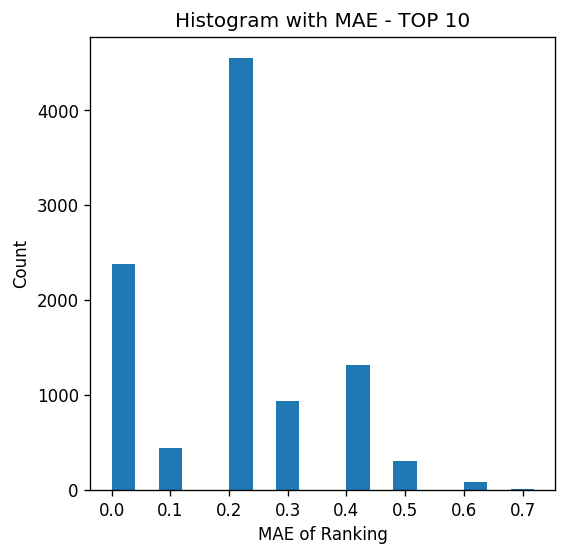

folder name: path_to_data_folder sd = 0.02: 
min: 0.001613199725885428
quantile 5%: 0.007786298585974533
quantile 20%: 0.012157719137311413
quantile 40%: 0.01593858179200138
quantile 60%: 0.020082929364211778
quantile 80%: 0.025462679949379743
quantile 95%: 0.03419981326684623
max: 0.060609673932057205
mean of MAE for Ranking (All level): 1.180045283018868
mean of MAE for Ranking (Extreme change): 2.3393962264150945
mean of MAE for Ranking (very large change): 1.7443270440251573
mean of MAE for Ranking (large change): 1.3740943396226417
mean of MAE for Ranking (medium change): 1.1191509433962266
mean of MAE for Ranking (small change): 0.8949056603773585
mean of MAE for Ranking (tiny change): 0.42052830188679247
mean of MAE for Ranking (TOP 10 change): 0.77049
 
mode of MAE for Ranking (All level): [(0.7924528301886793, 366)]
mode of MAE for Ranking (Extreme change): [(1.849056603773585, 17)]
mode of MAE for Ranking (very large change): [(1.6603773584905661, 72)]
mode of MAE for Ranking

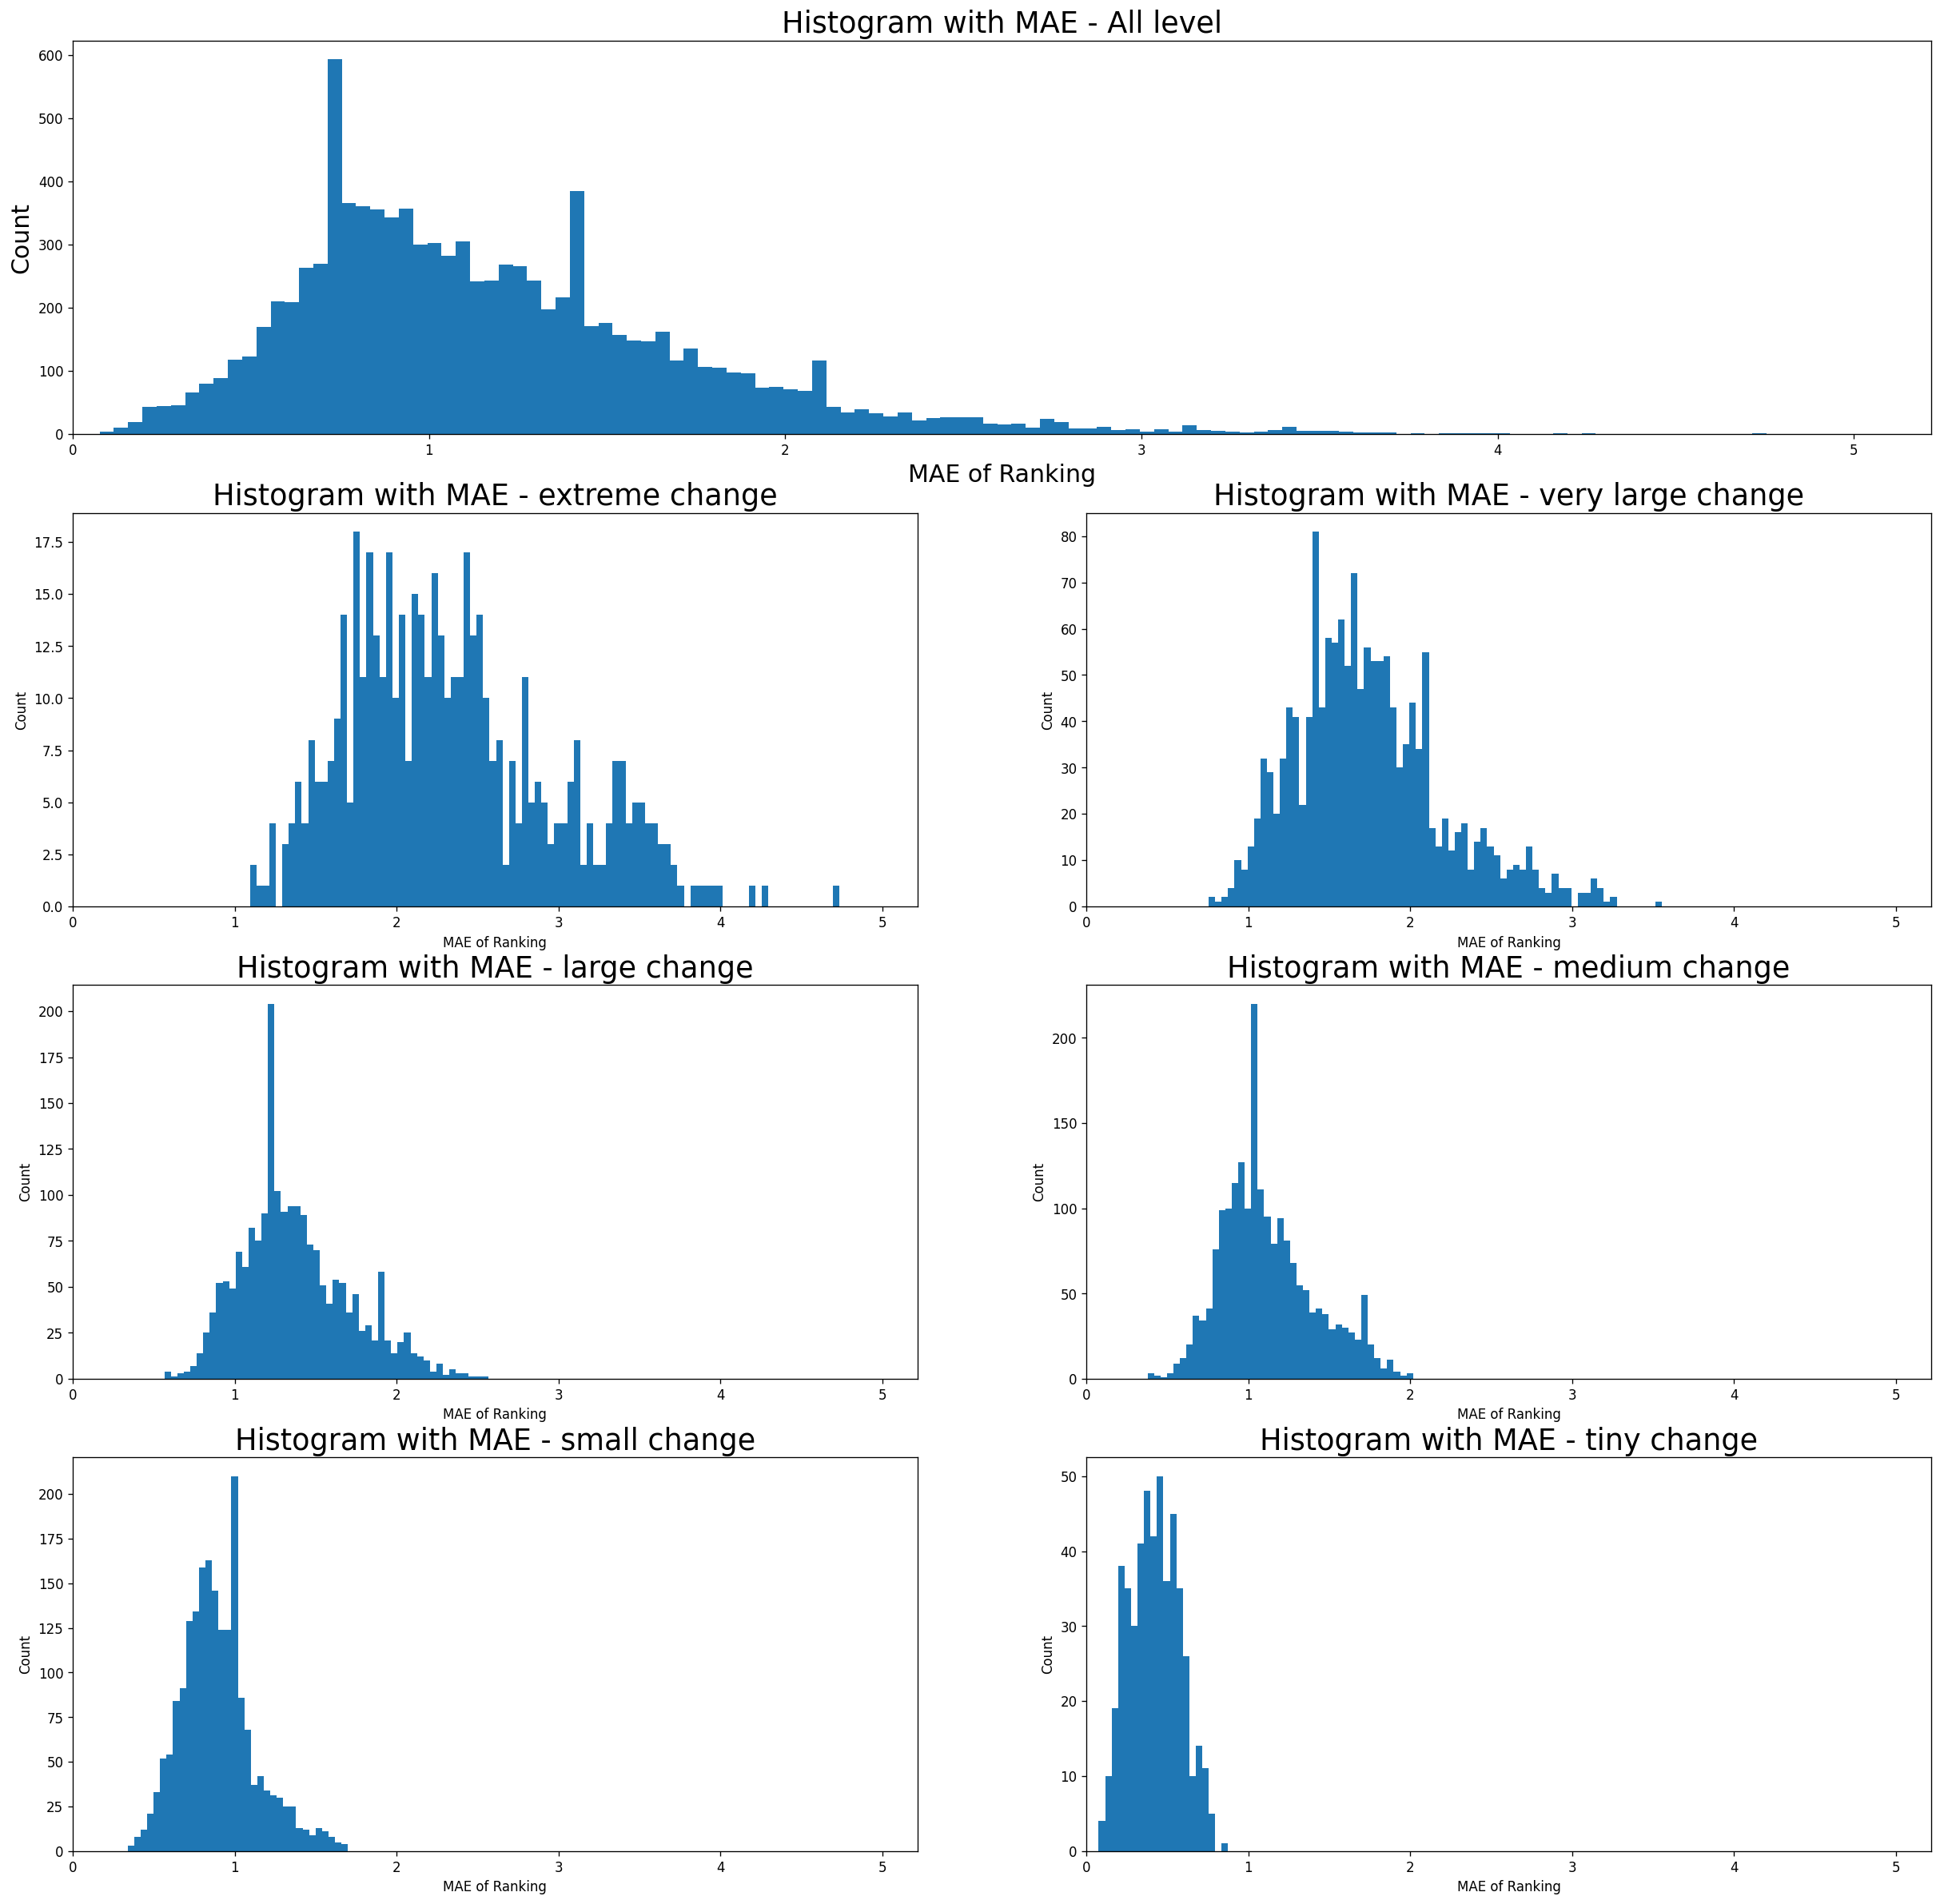

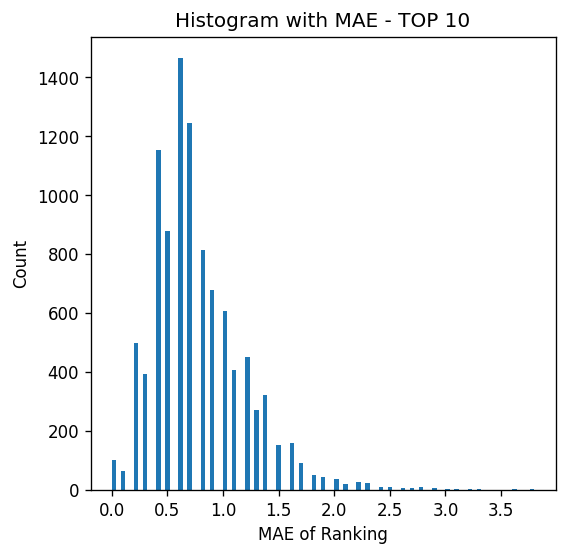

folder name: path_to_data_folder sd = 0.1: 
min: 0.005058754045942082
quantile 5%: 0.03888688200927667
quantile 20%: 0.05706810955655334
quantile 40%: 0.07476009378798407
quantile 60%: 0.09057692487209992
quantile 80%: 0.1142979642202018
quantile 95%: 0.14717486506318472
max: 0.2682025067328707
mean of MAE for Ranking (All level): 4.682467924528302
mean of MAE for Ranking (Extreme change): 8.75177358490566
mean of MAE for Ranking (very large change): 6.723245283018868
mean of MAE for Ranking (large change): 5.381358490566037
mean of MAE for Ranking (medium change): 4.442169811320755
mean of MAE for Ranking (small change): 3.7160943396226416
mean of MAE for Ranking (tiny change): 1.7805283018867926
mean of MAE for Ranking (TOP 10 change): 3.55237
 
mode of MAE for Ranking (All level): [(3.6226415094339623, 146)]
mode of MAE for Ranking (Extreme change): [(10.226415094339623, 7)]
mode of MAE for Ranking (very large change): [(4.716981132075472, 24)]
mode of MAE for Ranking (large change)

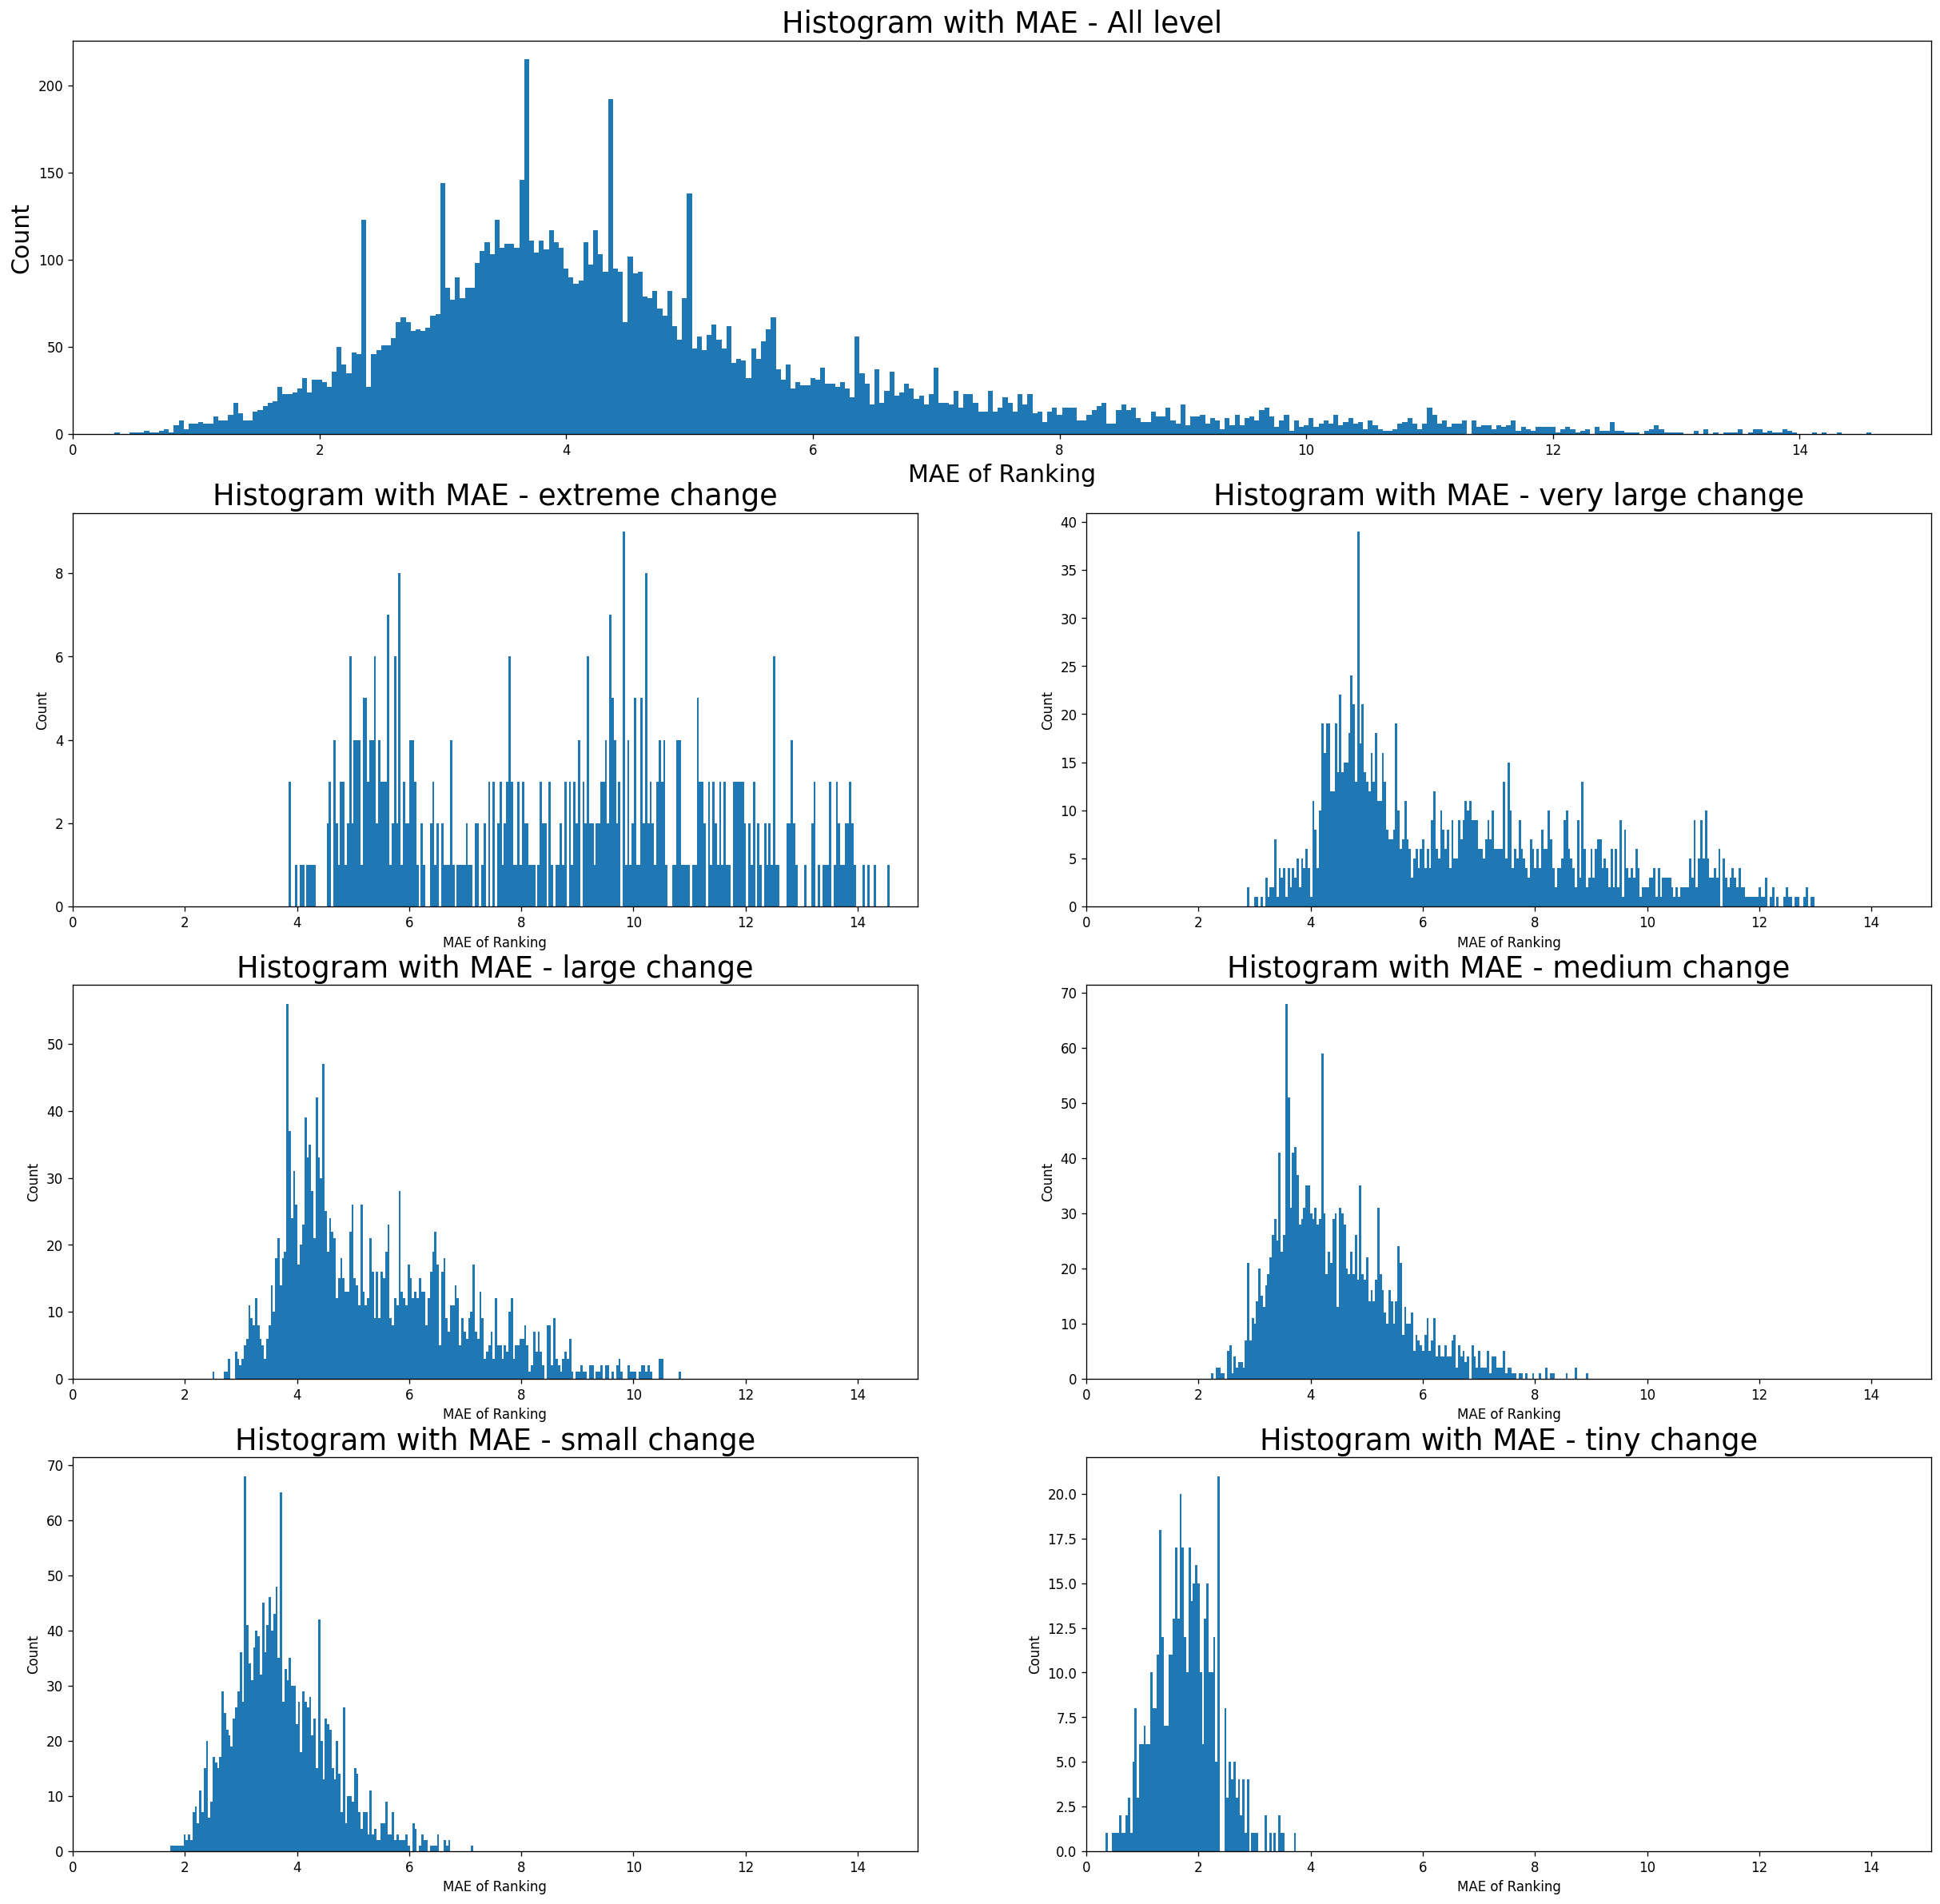

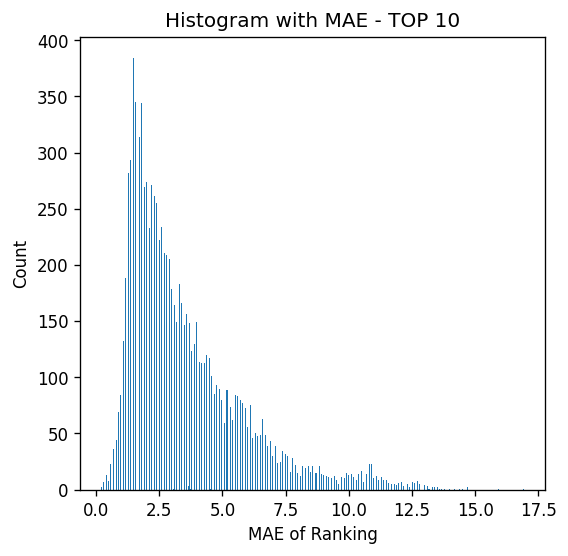

folder name: path_to_500 sd = 0.003: 
min: 0.0001570171395058384
quantile 5%: 0.0011842653778330846
quantile 20%: 0.001809207367812682
quantile 40%: 0.0024064565085913335
quantile 60%: 0.00302512286317188
quantile 80%: 0.0038389129464954895
quantile 95%: 0.005159463560723473
max: 0.011409666275794417
mean of MAE for Ranking (All level): 1.8495428
mean of MAE for Ranking (Extreme change): 3.674144
mean of MAE for Ranking (very large change): 2.719170666666667
mean of MAE for Ranking (large change): 2.166202
mean of MAE for Ranking (medium change): 1.7549560000000002
mean of MAE for Ranking (small change): 1.410566
mean of MAE for Ranking (tiny change): 0.660984
mean of MAE for Ranking (TOP 10 change): 0.34880000000000005
 
mode of MAE for Ranking (All level): [(1.432, 32)]
mode of MAE for Ranking (Extreme change): [(3.176, 5)]
mode of MAE for Ranking (very large change): [(2.432, 10)]
mode of MAE for Ranking (large change): [(1.96, 15)]
mode of MAE for Ranking (medium change): [(1.64, 1

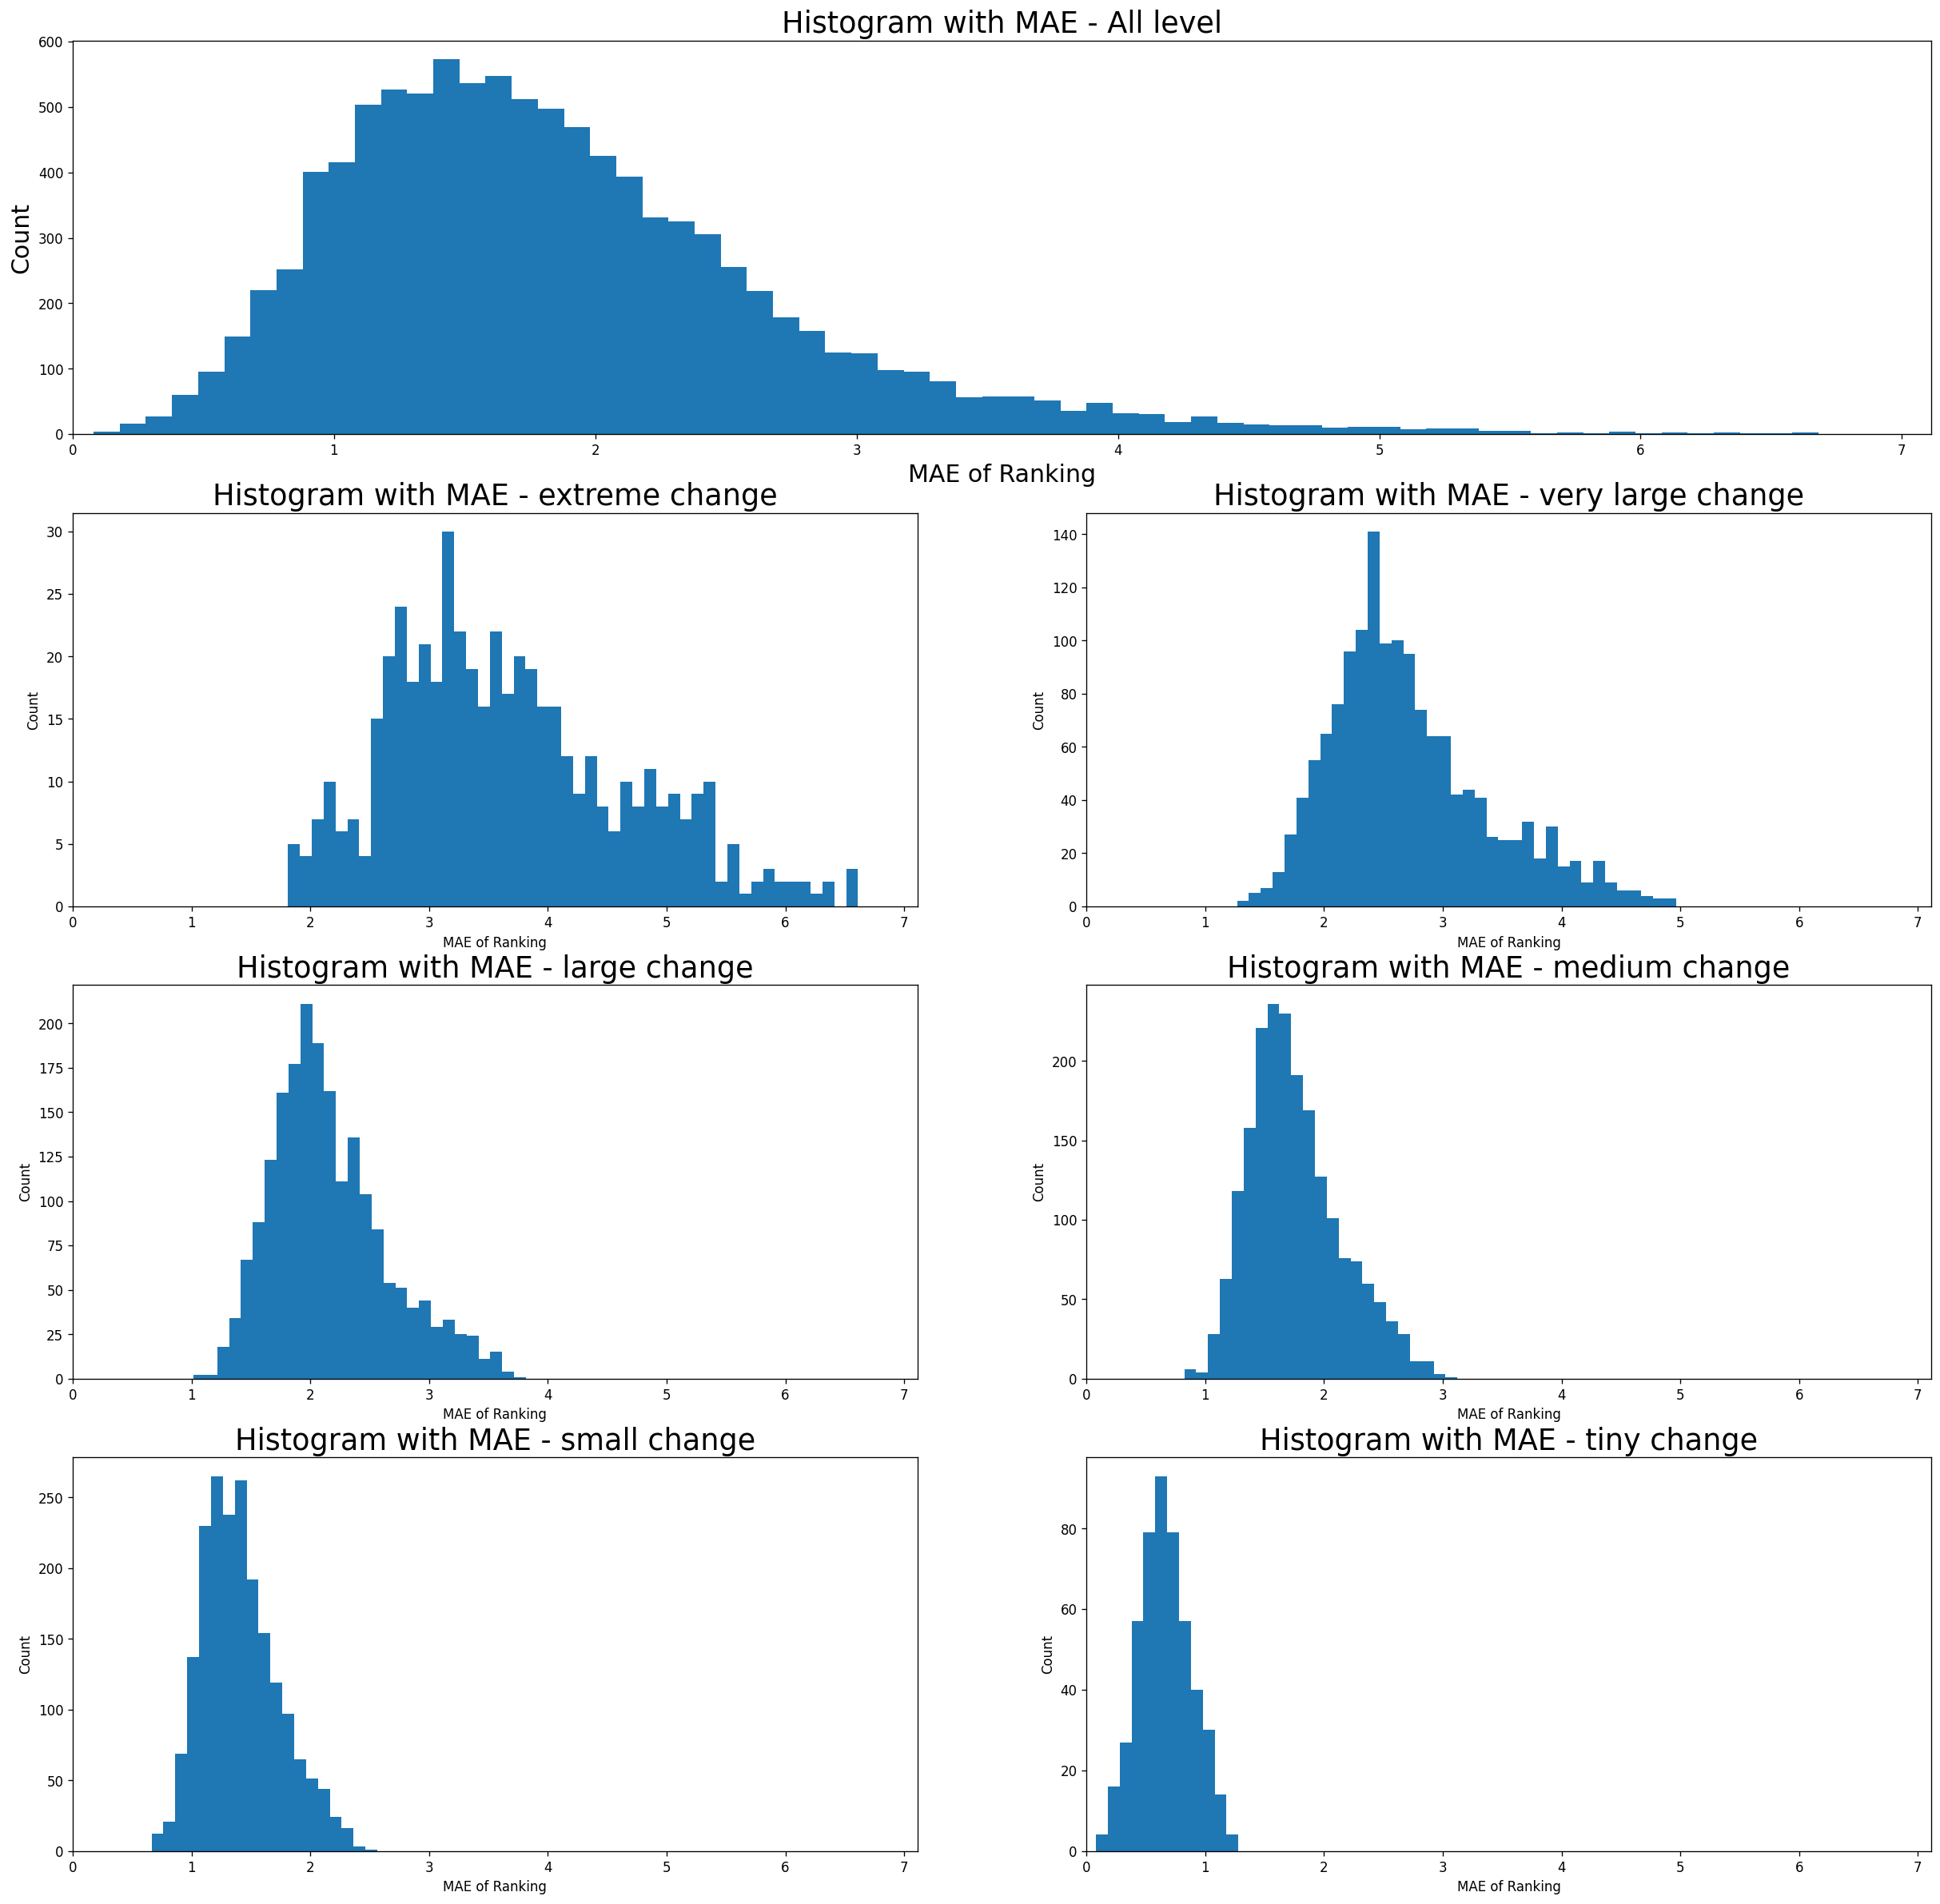

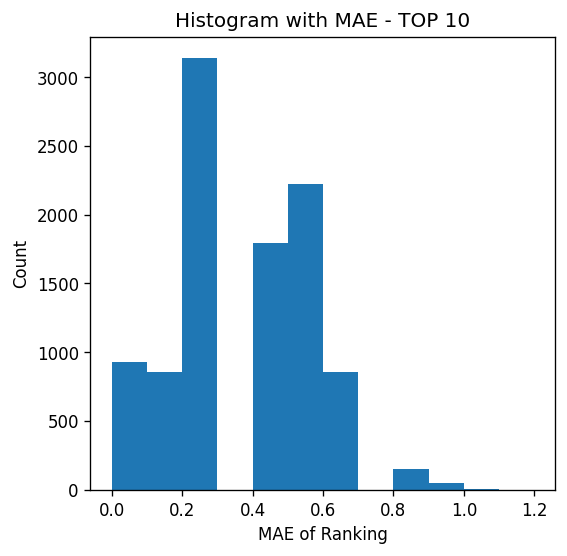

folder name: path_to_500 sd = 0.02: 
min: 0.001241468657921374
quantile 5%: 0.007795348611056529
quantile 20%: 0.012200046860823193
quantile 40%: 0.016083465880918236
quantile 60%: 0.020080259411004227
quantile 80%: 0.025234420504651238
quantile 95%: 0.03378472125424466
max: 0.05678623034021313
mean of MAE for Ranking (All level): 10.943607799999999
mean of MAE for Ranking (Extreme change): 21.914836
mean of MAE for Ranking (very large change): 16.304544
mean of MAE for Ranking (large change): 12.841417999999999
mean of MAE for Ranking (medium change): 10.390072
mean of MAE for Ranking (small change): 8.246955999999999
mean of MAE for Ranking (tiny change): 3.7205199999999996
mean of MAE for Ranking (TOP 10 change): 1.1262800000000002
 
mode of MAE for Ranking (All level): [(9.292, 12)]
mode of MAE for Ranking (Extreme change): [(25.252, 3)]
mode of MAE for Ranking (very large change): [(15.872, 5)]
mode of MAE for Ranking (large change): [(12.888, 5)]
mode of MAE for Ranking (medium c

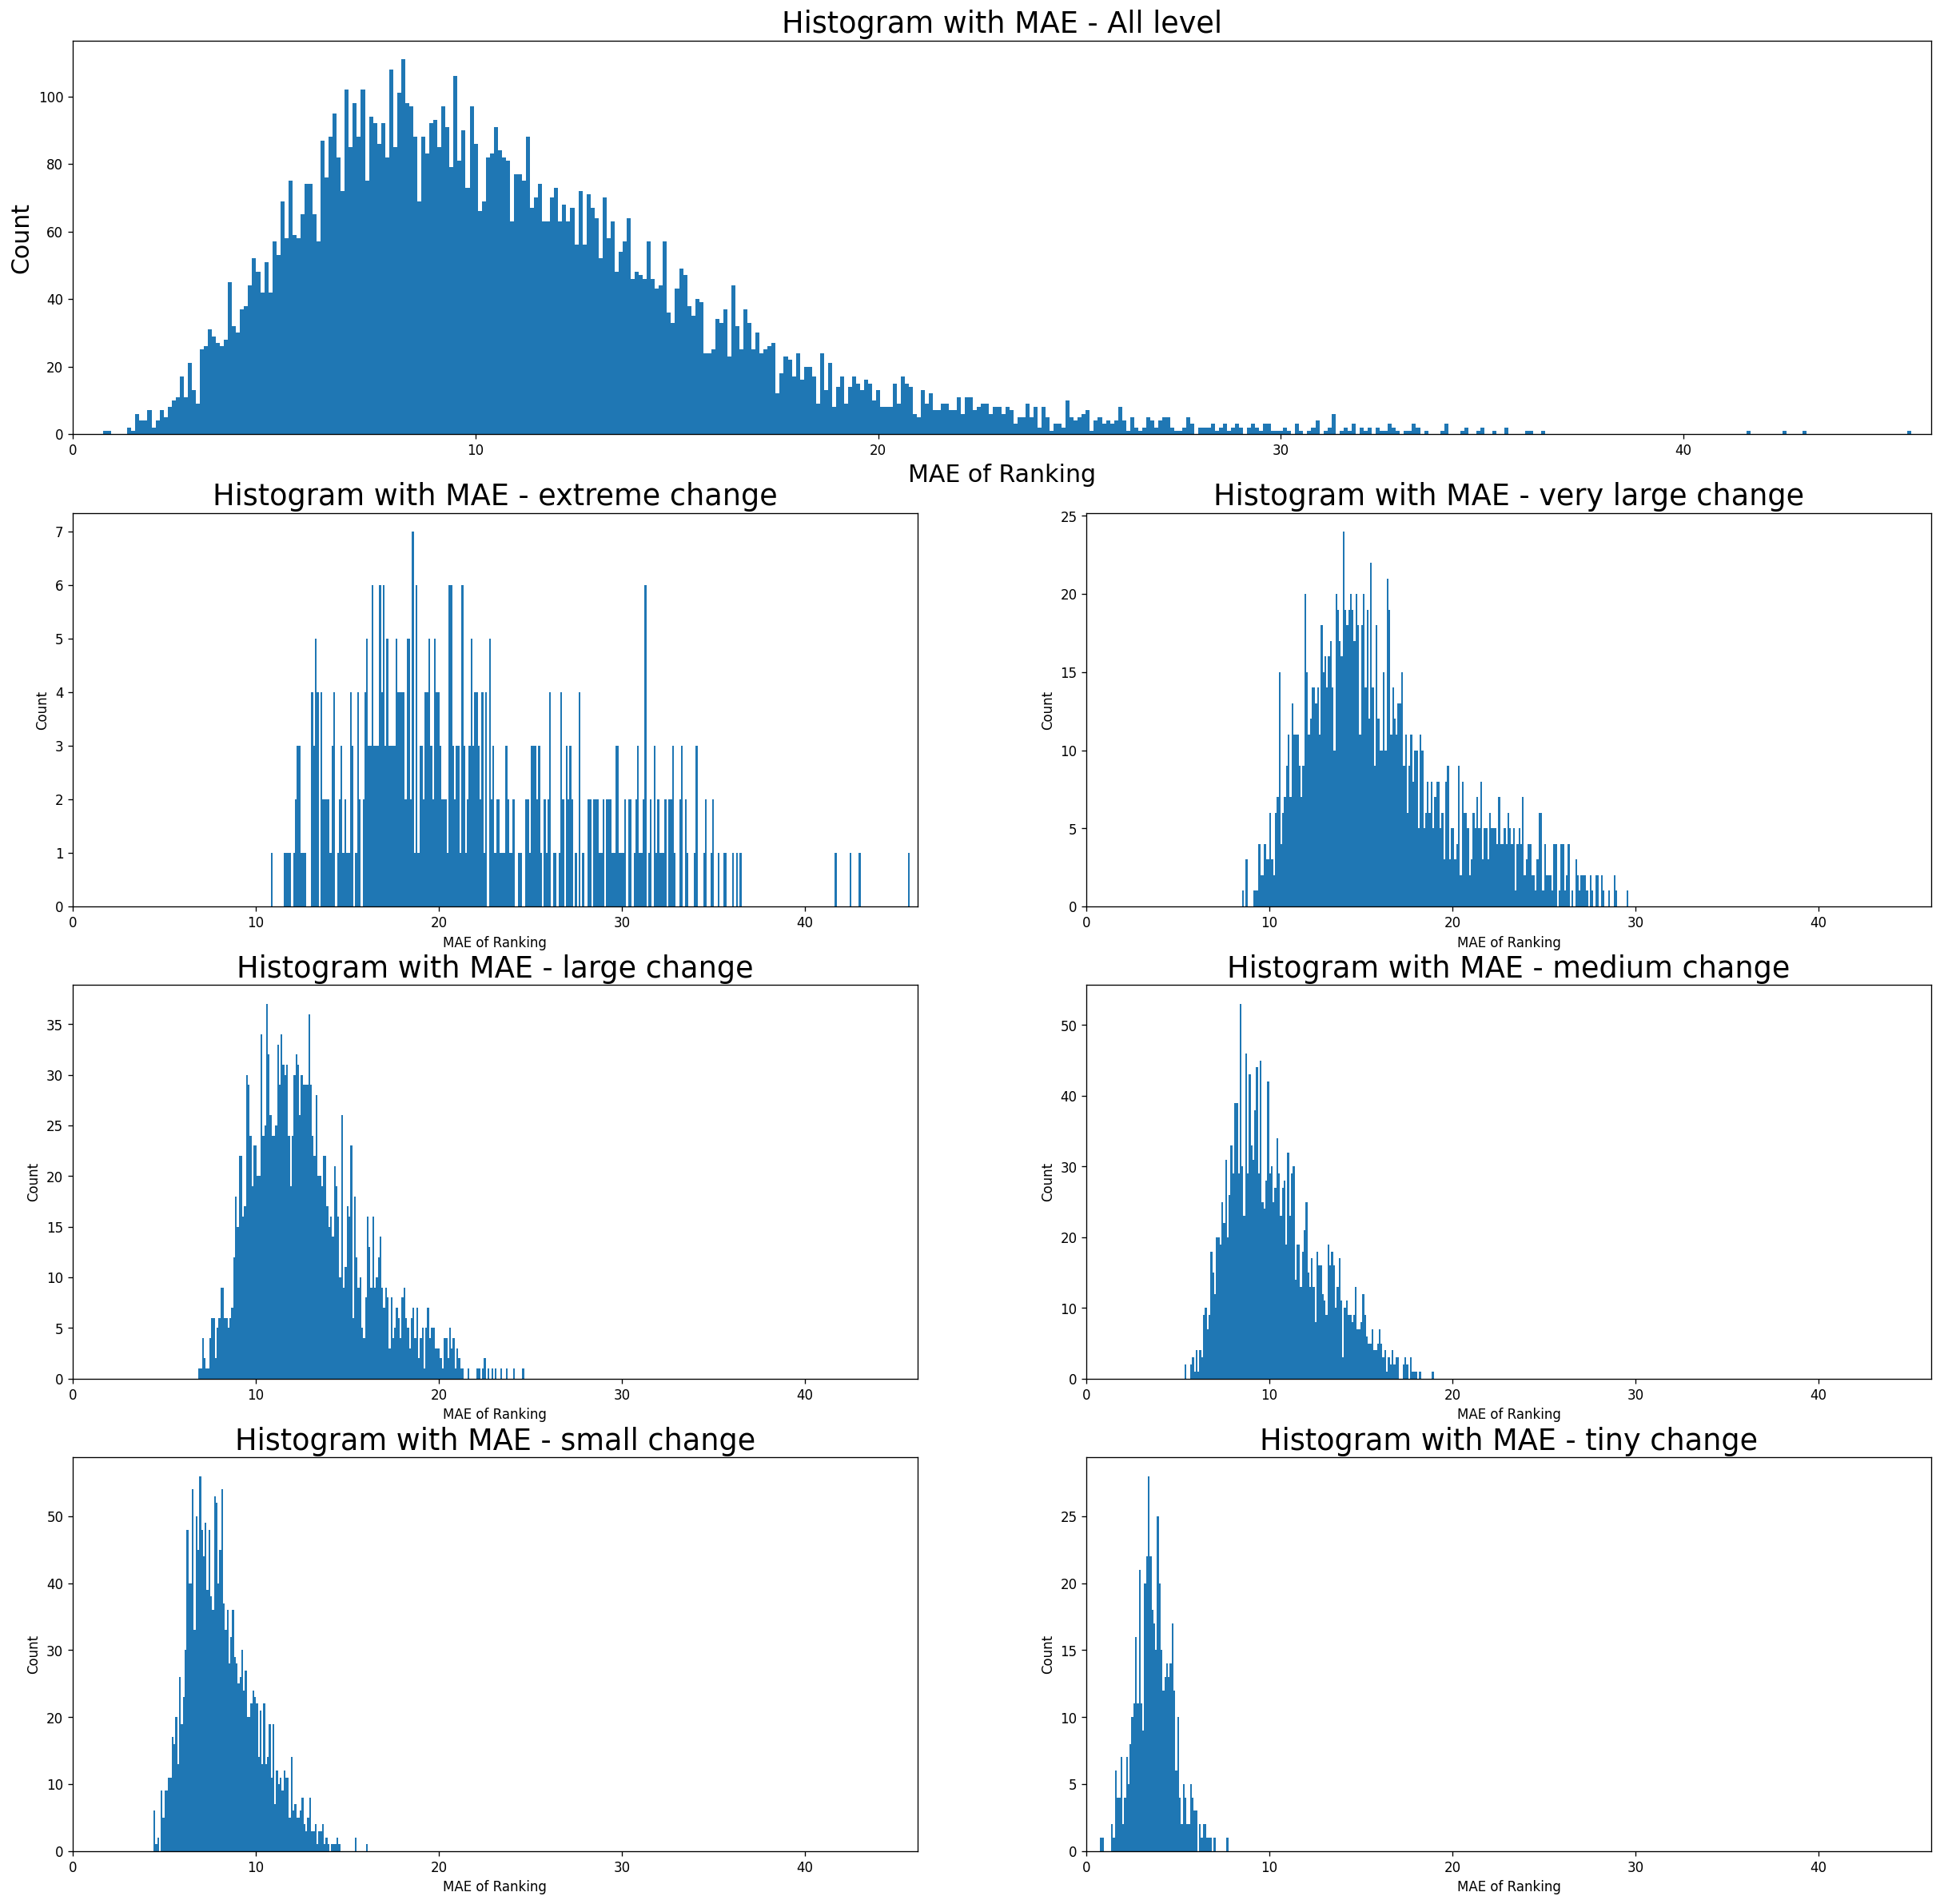

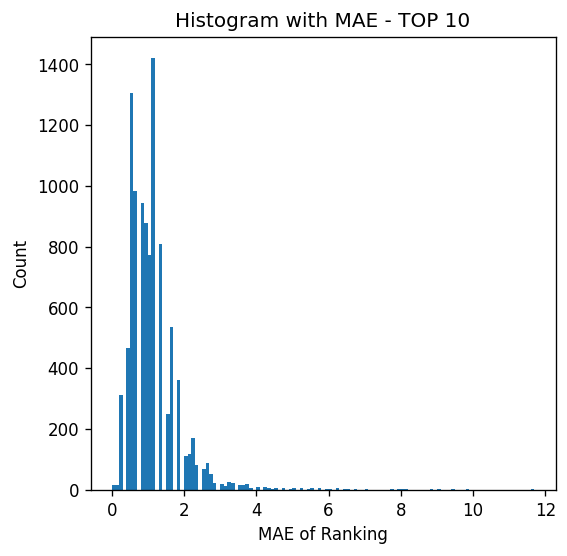

folder name: path_to_500 sd = 0.1: 
min: 0.009090473596857884
quantile 5%: 0.03837140257505314
quantile 20%: 0.0567579462221511
quantile 40%: 0.07448991241304384
quantile 60%: 0.09094925623201466
quantile 80%: 0.11522115061697878
quantile 95%: 0.14800746303563272
max: 0.2690893102211716
mean of MAE for Ranking (All level): 45.5170878
mean of MAE for Ranking (Extreme change): 83.577308
mean of MAE for Ranking (very large change): 66.40052933333332
mean of MAE for Ranking (large change): 52.640703
mean of MAE for Ranking (medium change): 43.078672000000005
mean of MAE for Ranking (small change): 35.88036
mean of MAE for Ranking (tiny change): 17.3292
mean of MAE for Ranking (TOP 10 change): 14.230075
 
mode of MAE for Ranking (All level): [(41.02, 8)]
mode of MAE for Ranking (Extreme change): [(55.624, 2)]
mode of MAE for Ranking (very large change): [(42.708, 3)]
mode of MAE for Ranking (large change): [(55.412, 3)]
mode of MAE for Ranking (medium change): [(41.02, 6)]
mode of MAE for R

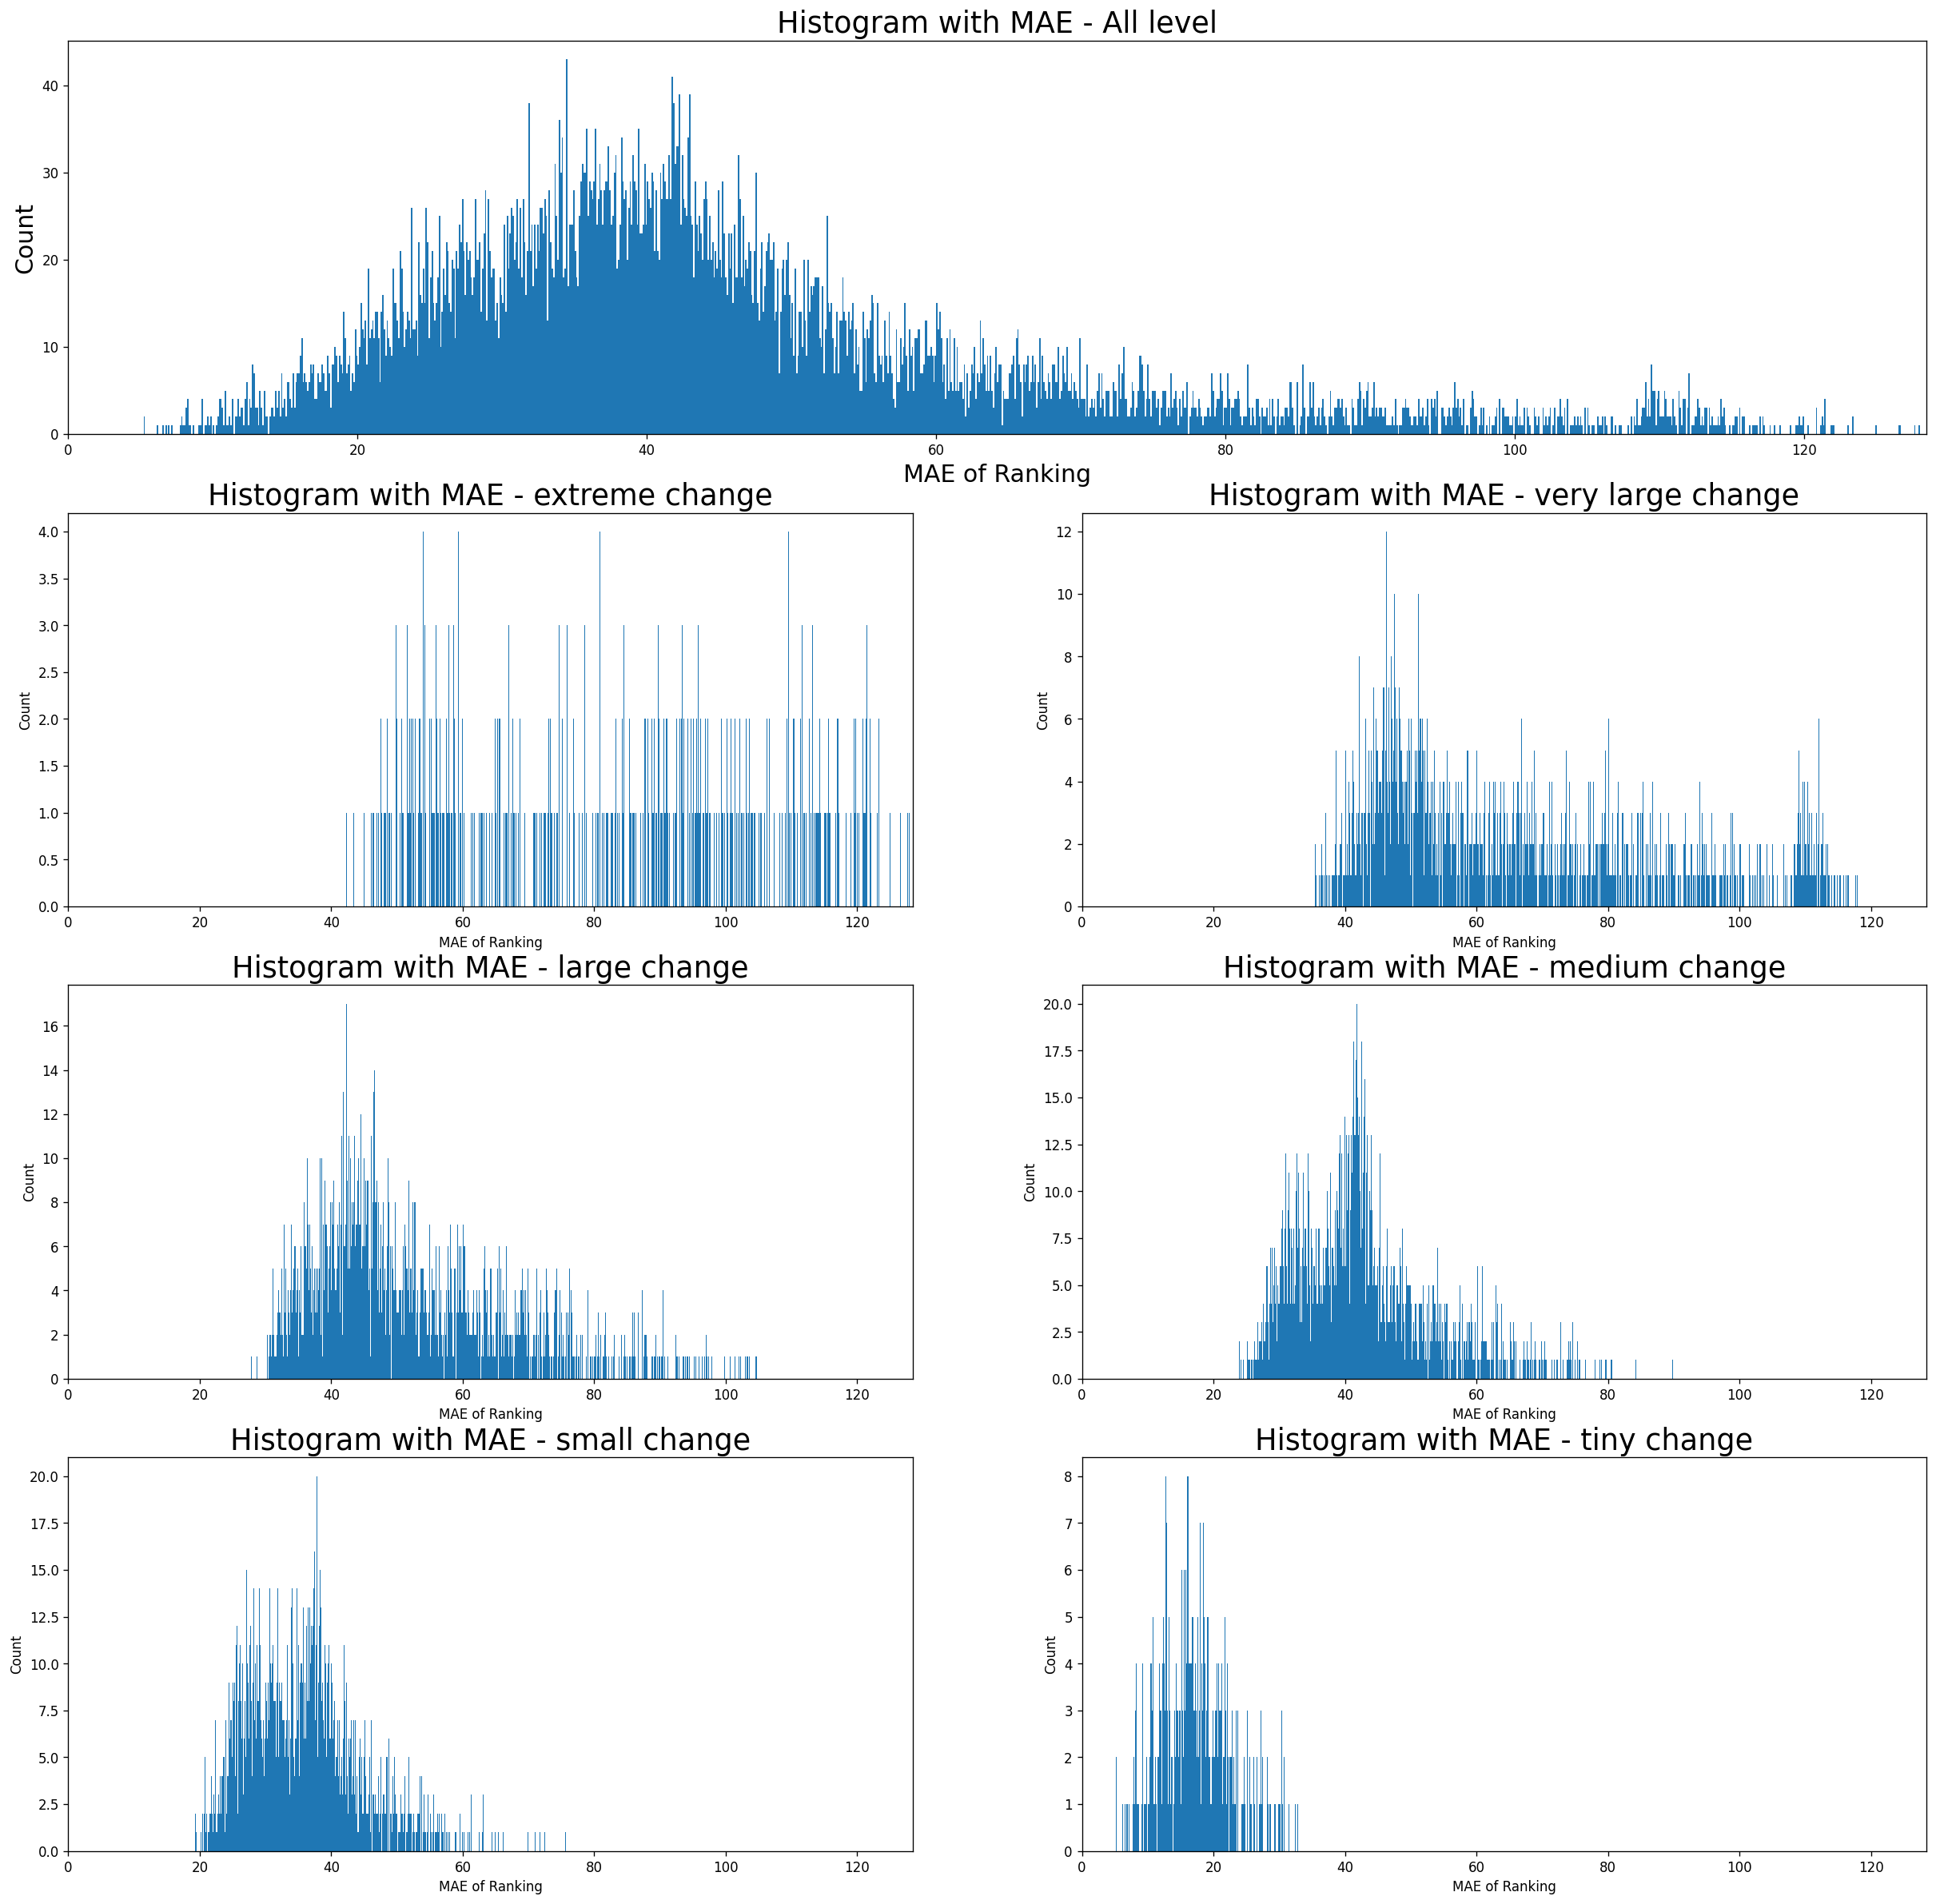

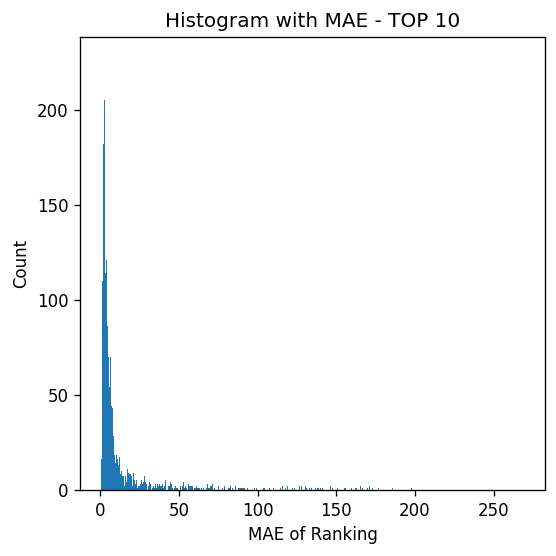

folder name: path_to_1000 sd = 0.003: 
min: 0.00015685909839691924
quantile 5%: 0.0011615690222187606
quantile 20%: 0.001804155548752896
quantile 40%: 0.002401370416961652
quantile 60%: 0.003015053006097742
quantile 80%: 0.003853591954268658
quantile 95%: 0.005146428301696089
max: 0.009630483890509153
mean of MAE for Ranking (All level): 3.4923165999999997
mean of MAE for Ranking (Extreme change): 7.11772
mean of MAE for Ranking (very large change): 5.218302666666666
mean of MAE for Ranking (large change): 4.092056
mean of MAE for Ranking (medium change): 3.296311
mean of MAE for Ranking (small change): 2.6256310000000003
mean of MAE for Ranking (tiny change): 1.245096
mean of MAE for Ranking (TOP 10 change): 0.31449999999999995
 
mode of MAE for Ranking (All level): [(2.998, 14)]
mode of MAE for Ranking (Extreme change): [(5.212, 2)]
mode of MAE for Ranking (very large change): [(4.224, 5)]
mode of MAE for Ranking (large change): [(3.344, 6)]
mode of MAE for Ranking (medium change): [

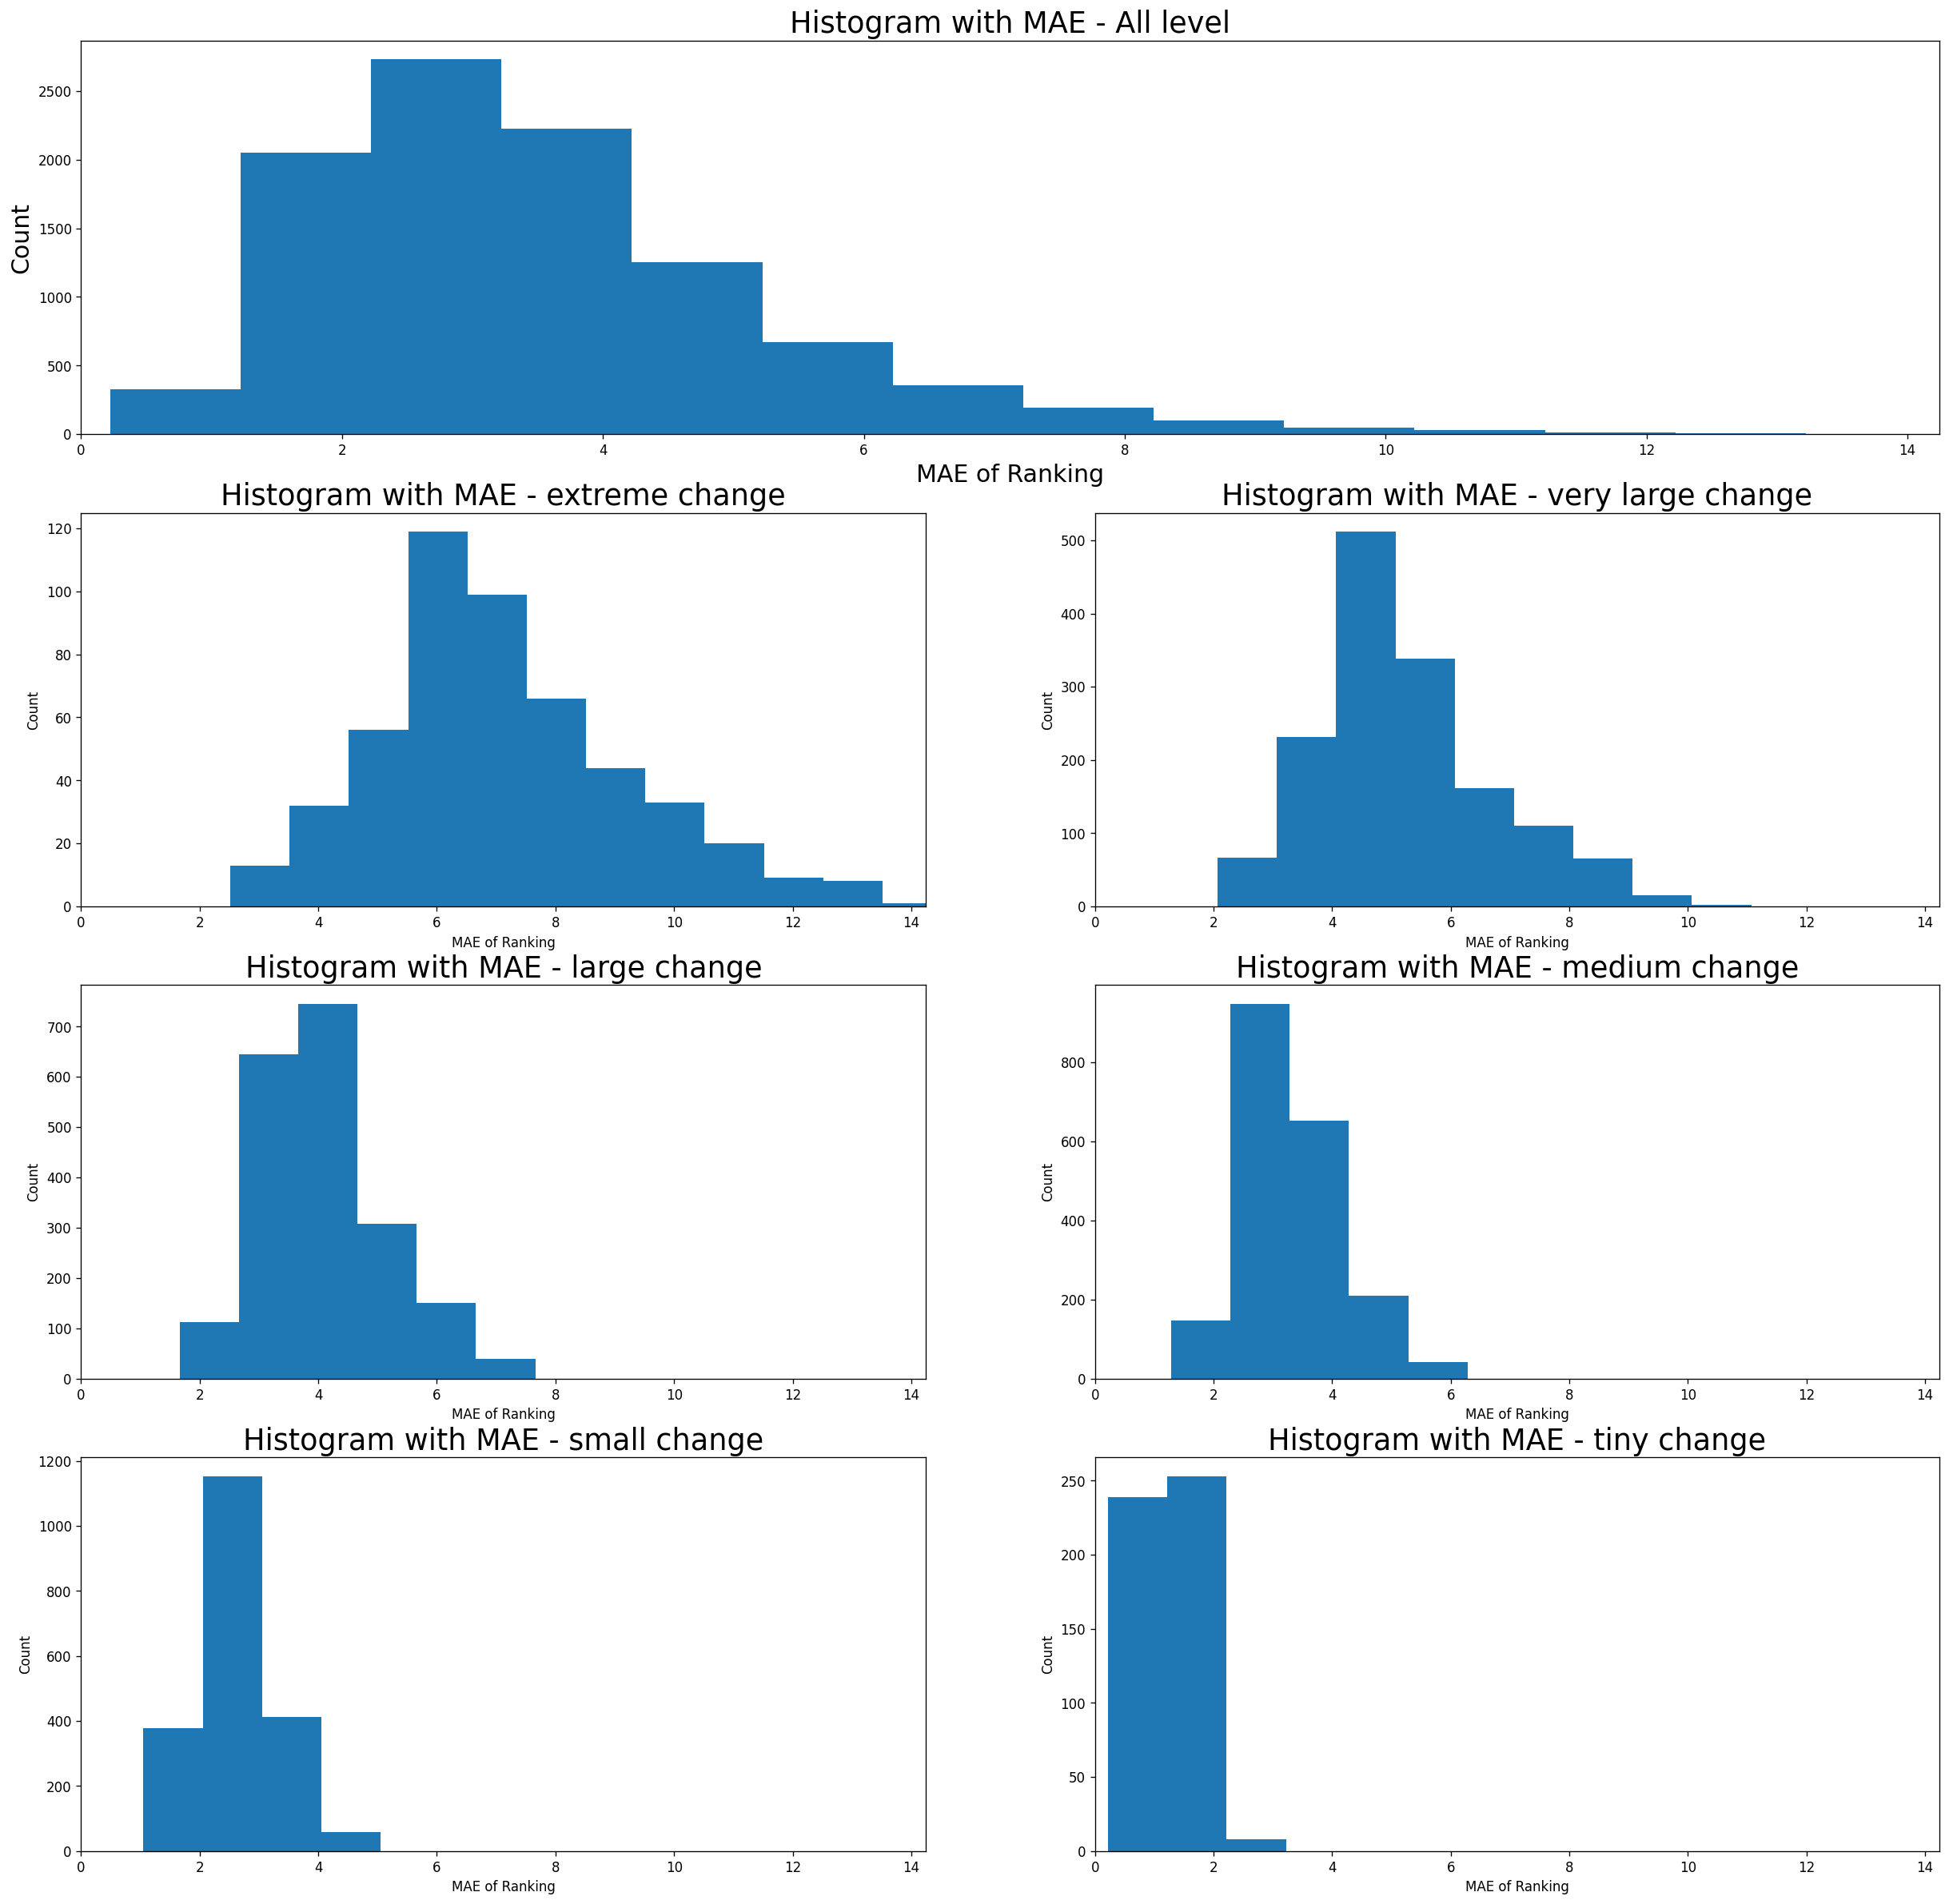

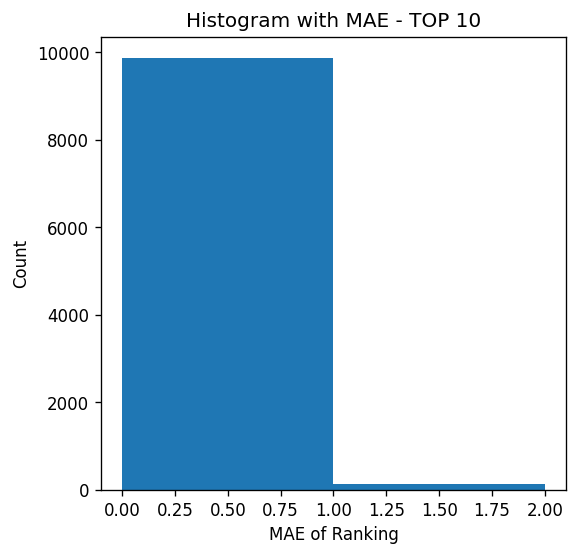

folder name: path_to_1000 sd = 0.02: 
min: 0.0012592549878424537
quantile 5%: 0.007779279549946252
quantile 20%: 0.012187111818622143
quantile 40%: 0.016067997151784526
quantile 60%: 0.020044458619992926
quantile 80%: 0.02554812641449353
quantile 95%: 0.03448181212505775
max: 0.06554961374550458
mean of MAE for Ranking (All level): 21.750092499999997
mean of MAE for Ranking (Extreme change): 44.54977
mean of MAE for Ranking (very large change): 33.131884
mean of MAE for Ranking (large change): 25.339353000000003
mean of MAE for Ranking (medium change): 20.424286
mean of MAE for Ranking (small change): 16.303152
mean of MAE for Ranking (tiny change): 7.3312479999999995
mean of MAE for Ranking (TOP 10 change): 1.1967599999999998
 
mode of MAE for Ranking (All level): [(13.644, 5)]
mode of MAE for Ranking (Extreme change): [(60.806, 1)]
mode of MAE for Ranking (very large change): [(24.496, 3)]
mode of MAE for Ranking (large change): [(22.11, 3)]
mode of MAE for Ranking (medium change): [

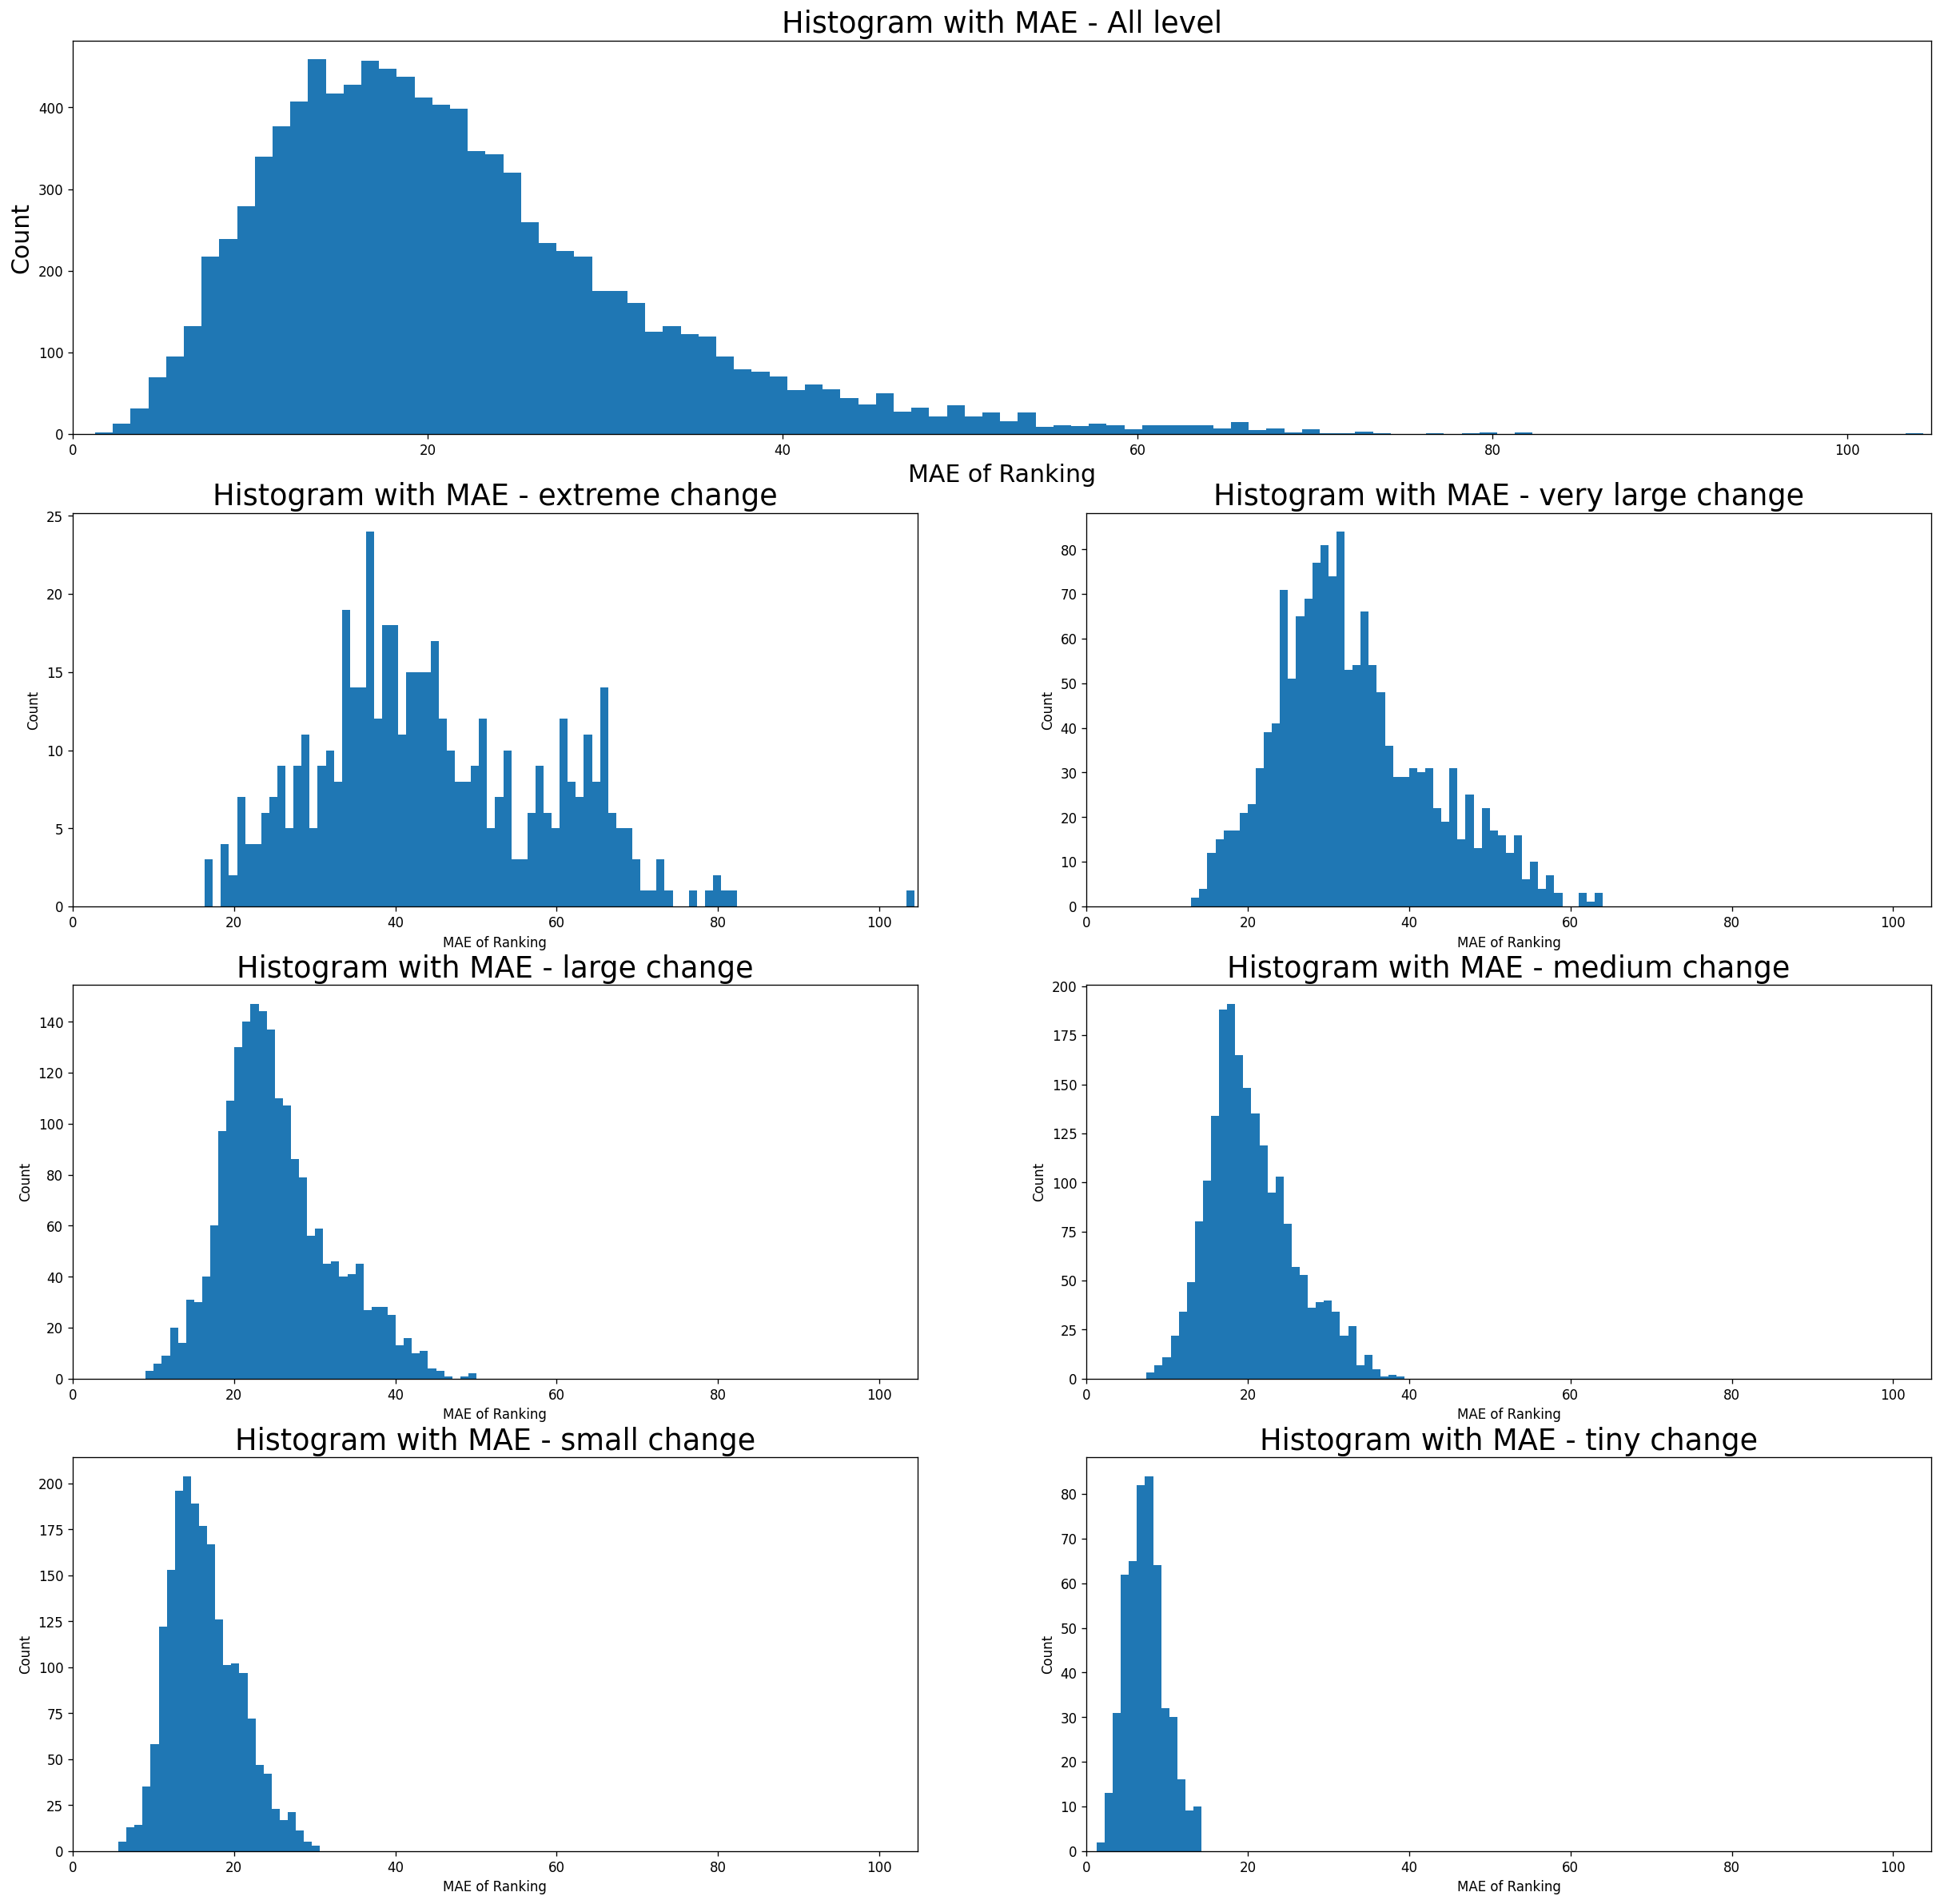

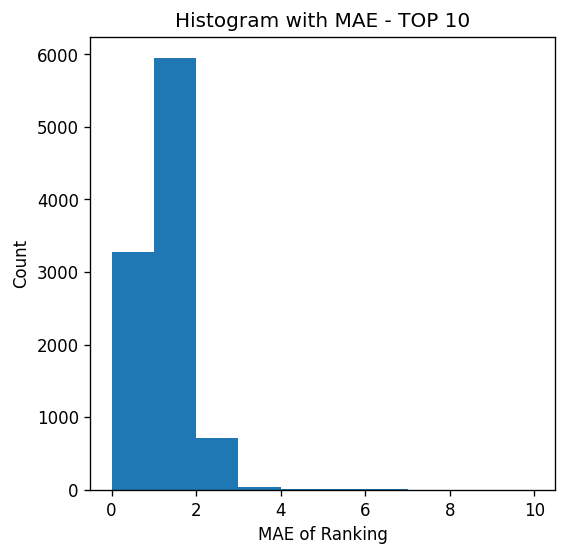

folder name: path_to_1000 sd = 0.1: 
min: 0.006113465025638332
quantile 5%: 0.039410627169870385
quantile 20%: 0.057410164212632404
quantile 40%: 0.07532172190227703
quantile 60%: 0.09154271868054253
quantile 80%: 0.11497526811025315
quantile 95%: 0.14765993037507424
max: 0.24
mean of MAE for Ranking (All level): 89.93430890000002
mean of MAE for Ranking (Extreme change): 163.304918
mean of MAE for Ranking (very large change): 128.66288733333332
mean of MAE for Ranking (large change): 104.02517350000001
mean of MAE for Ranking (medium change): 85.98811550000002
mean of MAE for Ranking (small change): 71.2875485
mean of MAE for Ranking (tiny change): 35.158179999999994
mean of MAE for Ranking (TOP 10 change): 18.28838
 
mode of MAE for Ranking (All level): [(68.108, 4)]
mode of MAE for Ranking (Extreme change): [(168.645, 1)]
mode of MAE for Ranking (very large change): [(124.648, 2)]
mode of MAE for Ranking (large change): [(104.85, 2)]
mode of MAE for Ranking (medium change): [(68.108

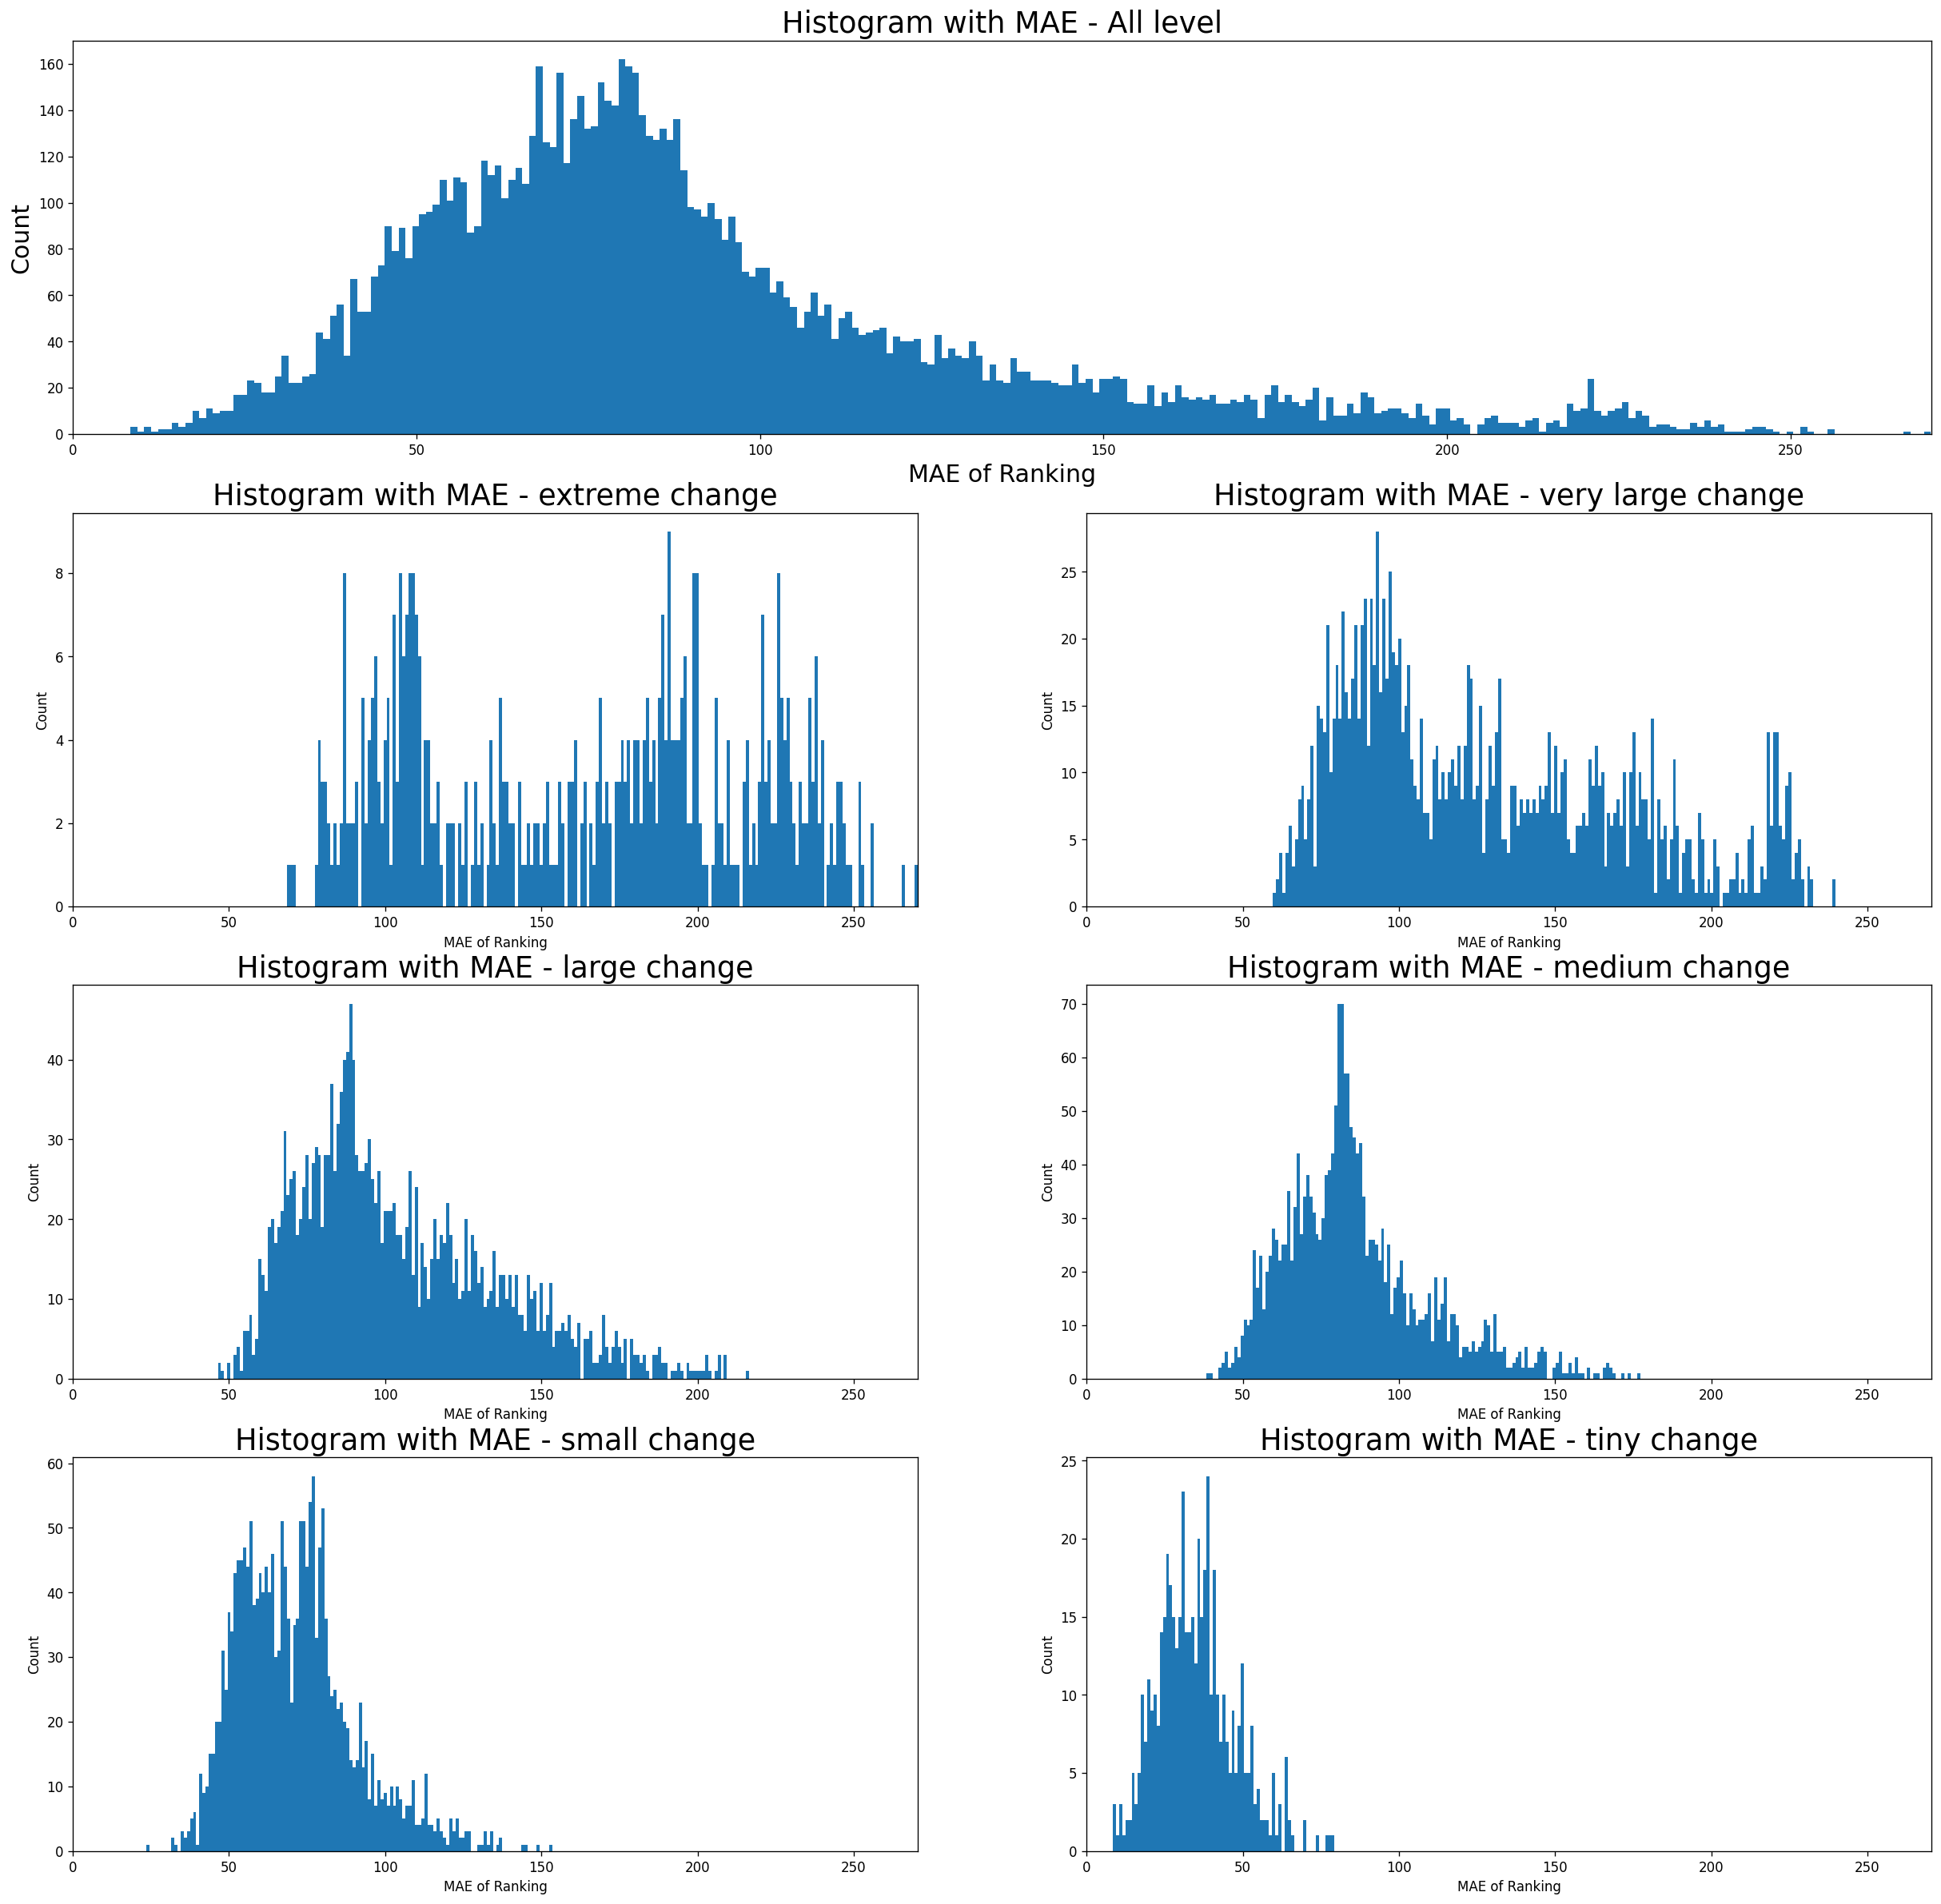

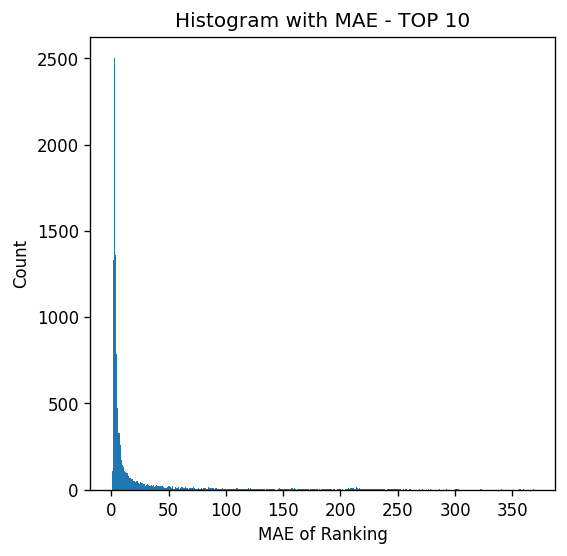

In [ ]:
num = -1
for i in data_set_list:
    num = num + 1
    for j in np.arange(0,3):
        print('folder name: ' + data_set_name[num] + ' sd = ' + str(sd_list[j]) + ': ')
        weight_shuffle_first,first_10_MAE_shuffle_first = One_job_analytics(Raw_data = i, Job_id = 456, baseline_weight= [0.3,0.2,0.3,0.1,0.1], sd = sd_list[j], iter_times = 10000,
                            Expert_yrs_set_up = 10, Intermediate_yrs_set_up = 6.5, Beginner_yrs_set_up = 2,
                                proficiency_far_below = 0.6, proficiency_below = 0.8, proficiency_meets = 1, proficiency_above = 1.1, proficiency_far_above = 1.2,
                                        yrs_exp_function_name = col_sigmoid, last_used_function_name = col_sigmoid, 
                                            yrs_slope = 0.5, yrs_horizontal_shift = 7,
                                                last_slope = -0.8, last_horizontal_shift = 6, bin_length = bin_length_list[num])

# Test part

### Test

In [ ]:
test_job_csv_array, test_application_csv_array = import_data(path_to_data_folder)
test_job_csv_array[1]

Job_Id         Title  Yrs_Exp  Importance  Disqualifying
0     123  department10       14          25           True
1     123  department19        5          25          False
2     456  department18        3          75          False
3     456   department3        7          25           True
4     789   department7       20          25           True
5     789  department15       13         100          False

In [ ]:
test_application_specific_job = filter_application_for_specific_job(456,test_job_csv_array, test_application_csv_array)
test_application_specific_job[0]

Application_Id     Title  Yrs_Exp   Proficiency  Last_Used  Importance  \
0              376  sector11        6        EXPERT         21          75   
1              120  sector11       19  INTERMEDIATE         17          75   
2              191  sector11        2  INTERMEDIATE         17          75   
3              444  sector11       16      BEGINNER          3          75   
4               23  sector11        7        EXPERT         21          75   
5              182  sector11       10      BEGINNER         22          75   
6               51   sector9       11        EXPERT         21          25   
7              260   sector9       20  INTERMEDIATE          6          25   
8              462   sector9       15  INTERMEDIATE         17          25   
9              347   sector9       15      BEGINNER          9          25   
10             169   sector9       15  INTERMEDIATE         21          25   

    Relative_importance  
0                  0.75  
1                  0.75  
2                  0.75  
3                  0.75  
4                  0.75  
5                  0.75  
6                  0.25  
7                  0.25  
8                  0.25  
9                  0.25  
10                 0.25

In [ ]:
test_sector_relative_importance = relative_importance_within_cluster(test_job_csv_array,456)
test_sector_relative_importance

[0.4,
 0.4,
 0.2,
 0.18181818181818182,
 0.13636363636363635,
 0.22727272727272727,
 0.3181818181818182,
 0.13636363636363635,
 1,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333]

In [ ]:
test_parity_cluster = parity_weight(456,test_job_csv_array,test_sector_relative_importance,test_application_specific_job,10,6.5,2,0,1,2,3,4,col_sigmoid,col_sigmoid,1,0,-1,0)
test_parity_cluster

[0.49267137483483814, 1.48894628281697, 2.0, 1.0, 20.0]

In [ ]:
test_applicant_total_score_dataframe = Applicant_total_score(456,test_job_csv_array,test_sector_relative_importance,test_application_specific_job,0,1,2,3,4,col_sigmoid,col_sigmoid,1,0,-1,0)
test_applicant_total_score_dataframe[0]

Yrs_Exp     Last_Used  Importance  Relative_importance  \
Application_Id                                                            
23              0.999089  7.582560e-10          75                 0.75   
51              0.999983  7.582560e-10          25                 0.25   
120             1.000000  4.139938e-08          75                 0.75   
169             1.000000  7.582560e-10          25                 0.25   
182             0.999955  2.789468e-10          75                 0.75   
191             0.880797  4.139938e-08          75                 0.75   
260             1.000000  2.472623e-03          25                 0.25   
347             1.000000  1.233946e-04          25                 0.25   
376             0.997527  7.582560e-10          75                 0.75   
444             1.000000  4.742587e-02          75                 0.75   
462             1.000000  4.139938e-08          25                 0.25   

                 Total_Score  Applicant_Id  
Application_Id                              
23              2.272696e-10            23  
51              7.582434e-11            51  
120             1.241981e-08           120  
169             7.582558e-11           169  
182             8.368024e-11           182  
191             1.093933e-08           191  
260             2.472623e-04           260  
347             1.233945e-05           347  
376             2.269143e-10           376  
444             1.422776e-02           444  
462             4.139936e-09           462

In [ ]:
test_cluster = applicant_cluster_score(test_applicant_total_score_dataframe)
test_cluster[0]

Total_Score
Applicant_Id              
14            2.472618e-04
23            2.221942e-07
27            8.315280e-08
34            6.692845e-04
44            2.368828e-02
51            7.582434e-11
85            1.422776e-02
93            5.411771e-07
120           1.655972e-08
126           1.233945e-05
169           3.066604e-08
182           8.993106e-04
191           1.104239e-08
209           1.595096e-10
250           1.130162e-07
260           9.165469e-04
308           2.689414e-02
316           1.798018e-03
337           3.059022e-08
338           6.674271e-07
347           1.233945e-05
365           8.312492e-08
376           2.688512e-02
421           6.144175e-07
444           1.422776e-02
457           7.066071e-04
462           4.139936e-09

In [ ]:
test_baseline_weight = [0.2,0.2,0.2,0.2,0.2]
test_baseline = baseline_df(test_baseline_weight,test_parity_cluster,test_cluster)
test_baseline

Cluster1      Cluster2  Cluster3  Cluster4   Cluster5  \
Applicant_Id                                                              
20            0.000000e+00  1.824769e-03  2.000000  0.333333  10.428571   
37            0.000000e+00  8.136994e-03  2.000000  0.333333  10.285714   
114           0.000000e+00  1.137752e-06  2.000000  0.333333   8.714286   
444           1.422776e-02  1.216881e-03  2.000000  0.166667  10.142857   
182           8.993106e-04  1.467270e-01  2.000000  0.000000  11.571429   
169           3.066604e-08  0.000000e+00  1.333333  0.500000  10.142857   
44            2.368828e-02  1.241321e-04  1.333333  0.500000   9.000000   
191           1.104239e-08  2.308354e-04  2.000000  0.166667   8.857143   
64            0.000000e+00  7.585153e-06  2.000000  0.000000  11.857143   
308           2.689414e-02  2.727231e-01  1.333333  0.333333   6.285714   
457           7.066071e-04  1.348703e-03  2.000000  0.166667   7.000000   
176           0.000000e+00  1.126069e-01  1.333333  0.333333   8.571429   
213           0.000000e+00  1.232949e-06  1.666667  0.166667  10.000000   
40            0.000000e+00  1.721002e-10  1.333333  0.333333   9.714286   
140           0.000000e+00  1.018679e-09  1.666667  0.166667   8.571429   
139           0.000000e+00  6.467084e-03  1.333333  0.333333   8.428571   
95            0.000000e+00  5.597389e-11  1.666667  0.166667   8.000000   
216           0.000000e+00  6.010261e-03  1.333333  0.166667  10.428571   
316           1.798018e-03  3.959791e-04  0.666667  0.500000   9.857143   
34            6.692845e-04  1.010031e-11  1.000000  0.333333   9.714286   
337           3.059022e-08  2.638647e-01  1.333333  0.166667   6.142857   
369           0.000000e+00  6.743518e-04  1.333333  0.166667   9.428571   
120           1.655972e-08  2.236504e-06  1.333333  0.166667   9.428571   
117           0.000000e+00  6.097275e-05  1.333333  0.000000  12.142857   
93            5.411771e-07  4.892432e-02  0.666667  0.333333  11.428571   
365           8.312492e-08  4.912645e-06  1.333333  0.166667   8.714286   
203           0.000000e+00  1.124331e-05  1.333333  0.166667   7.857143   
39            0.000000e+00  2.807201e-08  1.000000  0.333333   7.857143   
376           2.688512e-02  6.351292e-05  0.666667  0.333333   9.000000   
23            2.221942e-07  0.000000e+00  0.333333  0.333333  13.142857   
150           0.000000e+00  2.243619e-05  1.000000  0.166667   9.428571   
338           6.674271e-07  7.621594e-05  0.666667  0.166667  11.714286   
264           0.000000e+00  1.244464e-01  1.000000  0.166667   6.285714   
421           6.144175e-07  7.347238e-02  0.666667  0.166667  10.000000   
53            0.000000e+00  7.762484e-06  0.666667  0.166667   9.714286   
51            7.582434e-11  3.272049e-03  0.666667  0.333333   5.857143   
209           1.595096e-10  2.441814e-03  0.666667  0.166667   9.000000   
219           0.000000e+00  2.160631e-02  0.666667  0.166667   8.714286   
85            1.422776e-02  1.146778e-07  0.666667  0.000000  10.714286   
7             0.000000e+00  2.813415e-07  0.333333  0.166667  11.000000   
254           0.000000e+00  1.502209e-07  0.000000  0.333333  10.428571   
347           1.233945e-05  8.254005e-06  0.666667  0.000000  10.285714   
260           9.165469e-04  2.054580e-01  1.000000  0.000000   4.000000   
119           0.000000e+00  0.000000e+00  0.666667  0.166667   6.428571   
389           0.000000e+00  2.064539e-02  0.000000  0.333333   9.000000   
14            2.472618e-04  3.270219e-03  0.666667  0.000000   9.142857   
250           1.130162e-07  2.247788e-04  0.333333  0.166667   7.428571   
402           0.000000e+00  9.811268e-03  0.000000  0.166667   9.285714   
27            8.315280e-08  6.073295e-06  0.333333  0.166667   6.000000   
126           1.233945e-05  5.670488e-05  0.333333  0.000000   9.142857   
462           4.139936e-09  2.410000e-04  0.000000  0.166667   6.571429   
433           0.000000e+00  1.732798e-02  0

In [ ]:
test_baseline_weight = [0.2,0.2,0.2,0.2,0.2]
test_weight,test_first_10_MAE = iteration(test_baseline_weight, 0.3, test_baseline, 1, test_parity_cluster)
test_weight

min: 0.21572900163933723
quantile 5%: 0.21572900163933723
quantile 20%: 0.21572900163933723
quantile 40%: 0.21572900163933723
quantile 60%: 0.21572900163933723
quantile 80%: 0.21572900163933723
quantile 95%: 0.21572900163933723
max: 0.21572900163933723


cluster_weight_1  cluster_weight_2  cluster_weight_3  cluster_weight_4  \
0                 0          0.616438          0.060677          0.322884   

   cluster_weight_5    change       MAE              level  
0               0.0  0.215729  9.660377  very large change

In [ ]:
test_first_10_MAE

[11.6]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed78b838-2736-41d2-b49f-3fbbc09b6361' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>